# QuantumMusic - Unified Version

### Introduction

This is the Python notebook for the entire quantum music analysis project
Author: Rohan Agarwal

Now we want to expand our notebook to do comparison between two tracks - a teacher and a student
Add a new module for this
This module will: a) take two tracks one called "teacher" and one called "student".  Currently we have hard coded a filename in grade_single_file.  This piece should be replaced with the file names being passed from this function  b) run the complete program on each track and collect all metrics for both tracks, c) write new functionality that will compare the two tracks and generate a detailed comparison of the two tracks and store all the differences in a different data structure.  This comparison will be interesting because you are assuming that the "teacher" track is correct.  Therefore, even if the "student" track is not off pitch but it differs from the "teacher" track at that point, you will mark the difference.  You will have to write some proper code to compare and contrast two tracks and see where the differences are.  Do a first pass now and then we can refine from there. 

## 1. Constants & Imports

In [271]:
# 1. CONSTANTS & IMPORTS

import os
import sys
import psycopg2
from psycopg2.extras import Json
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import re
from matplotlib import colormaps
import scipy.signal  # (if not already imported)
from scipy.signal import find_peaks
from scipy.signal import iirnotch, filtfilt
import math
import numpy as np
import matplotlib.pyplot as plt
import logging
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator  # Updated import for Qiskit Aer
from qiskit.circuit import ParameterVector
from qiskit.visualization import plot_histogram
import optuna

from scipy.signal import butter, filtfilt

# For Praat-based HNR
import parselmouth
from parselmouth.praat import call

# For audio playback in Jupyter
from IPython.display import Audio, display

# For LUFS-based loudness
try:
    import pyloudnorm as pyln
    LOUDNORM_AVAILABLE = True
except ImportError:
    LOUDNORM_AVAILABLE = False
    print("Warning: pyloudnorm not installed, LUFS computations will be skipped.")

# Quantum Computing imports
# Qiskit imports
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator  # modern Aer simulator from qiskit-aer


# Directory constants
INPUT_DIR = "data/trainingdata"
OUTPUT_DIR = "output"

# Database constants
DB_NAME = "quantummusic"
DB_HOST = "localhost"
DB_USER = "postgres"  # placeholder
DB_PASSWORD = "postgres"  # placeholder

# Audio processing constants
STANDARD_SR = 44100  # Standard sampling rate
SILENCE_THRESHOLD_DB = 30  # dB threshold for silence trimming

# Band-pass filter constants
LOW_FREQ = 80.0
HIGH_FREQ = 3000.0

# Visualization constants
FIG_SIZE = (10, 4)

# Save-to-DB constant
SAVE_TO_DB = True

# Frame-based approach for pitch detection
FRAME_SIZE = 2048
HOP_LENGTH = 512  # normal frames
# Praat-based chunk size
PRAAT_CHUNK_SIZE = 2048  # for Praat

# Deviation threshold in cents, for dev_flag
DEVIATION_THRESHOLD = 50.0

# Multi-chunk tempo analysis
TEMPO_CHUNK_SIZE_MEDIUM = 4096
TEMPO_CHUNK_SIZE_LARGE = 16384

# New constants for advanced vocal feature extraction
VOCAL_FEATURE_CHUNK_SIZE = 16384       # New chunk size for advanced feature extraction (samples)
VOCAL_FEATURE_CHUNK_HOP = 4096        # Hop size for overlapping chunks (e.g., 50% overlap)

# NEW constant for LUFS calculations (0.5s @ 44.1kHz)
LUFS_CHUNK_SIZE = 22050

# --- NEW CONSTANTS FOR ADVANCED VOCAL FEATURE EXTRACTION ---

# Formant analysis parameters
FORMANT_ANALYSIS_TIME = 0.1            # Time (in seconds) at which to extract formants
FORMANT_TIME_STEP = 0.01               # Time step for formant analysis
MAX_NUMBER_OF_FORMANTS = 5             # Maximum number of formants computed by Praat
MAXIMUM_FORMANT_FREQUENCY = 5500       # Maximum frequency considered for formant analysis
NUM_FORMANTS_TO_EXTRACT = 3            # Number of formants to extract (e.g., F1, F2, F3)

# Pitch / jitter / shimmer parameters
MIN_F0 = 75                          # Minimum expected fundamental frequency (Hz)
MAX_F0 = 500                         # Maximum expected fundamental frequency (Hz)
JITTER_TIME_STEP = 0.0001             # Time step for jitter computation
JITTER_MIN_PERIOD = 0.02              # Minimum period threshold for jitter
JITTER_MAX_PERIOD = 1.3               # Maximum period threshold factor for jitter
SHIMMER_MIN_AMPLITUDE = 0.0001         # Minimum amplitude threshold for shimmer
SHIMMER_MAX_AMPLITUDE = 0.02           # Maximum amplitude threshold for shimmer
SHIMMER_FACTOR = 1.6                 # Shimmer factor (per Praat defaults)

# Vibrato analysis parameters
VIBRATO_MIN_HZ = 3                   # Lower bound for vibrato rate (Hz)
VIBRATO_MAX_HZ = 10                  # Upper bound for vibrato rate (Hz)
MEDIAN_FILTER_KERNEL_SIZE = 9        # Kernel size for median filtering pitch contours


# Ensure output directories exist
os.makedirs(INPUT_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

def test_imports():
    print("Imports tested, all modules are available.")

test_imports()

Imports tested, all modules are available.


## 2 - Converting Numbers to Labels

In [272]:
########################
# NEW: Classification Helpers
########################

def classify_pitch_deviation(dev_cents):
    """
    Classify pitch deviation into categories based on absolute distance from nearest note.
    """
    if dev_cents is None or np.isnan(dev_cents):
        return "unknown"
    dev_abs = abs(dev_cents)
    if dev_abs < 10:
        return "perfect"
    elif dev_abs < 30:
        return "good"
    elif dev_abs < 50:
        return "fair"
    elif dev_abs < 100:
        return "poor"
    else:
        return "very poor"


def classify_tone_to_noise(sf_val):
    """
    Classify spectral flatness into a rough 'tonal vs. noisy' scale.
    Typical spectral flatness range is ~0 to 1.
    """
    if np.isnan(sf_val):
        return "unknown"
    if sf_val < 0.02:
        return "very tonal"
    elif sf_val < 0.08:
        return "mostly tonal"
    elif sf_val < 0.15:
        return "mixed"
    elif sf_val < 0.3:
        return "noisy"
    else:
        return "very noisy"


def classify_transition_score(score):
    """
    Classify how smoothly the pitch transitions from the previous chunk.
    Score ~ 0..1, with 1 = no pitch jump, 0 = extremely large jump
    """
    if np.isnan(score):
        return "unknown"
    if score >= 0.8:
        return "smooth"
    elif score >= 0.5:
        return "moderate"
    else:
        return "abrupt"


def classify_rms_db(rms_db):
    """
    Classify RMS in dB into categories from very soft => very loud
    """
    if np.isnan(rms_db):
        return "unknown"
    if rms_db < -40:
        return "very soft"
    elif rms_db < -20:
        return "soft"
    elif rms_db < -10:
        return "moderate"
    elif rms_db < -2:
        return "loud"
    else:
        return "very loud"


def classify_lufs(lufs_val):
    """
    Classify LUFS values into rough loudness categories.
    Typically, lower (more negative) = quieter, higher = louder.
    """
    if lufs_val is None or np.isnan(lufs_val):
        return "unknown"
    if lufs_val < -40:
        return "very soft"
    elif lufs_val < -23:
        return "soft"
    elif lufs_val < -14:
        return "moderate"
    elif lufs_val < -5:
        return "loud"
    else:
        return "very loud"


def classify_praat_hnr(hnr_val):
    """
    Classify Praat HNR (dB). Typical range: 0..35 dB for normal voices.
    Higher = more harmonic, lower = more noise.
    """
    if np.isnan(hnr_val):
        return "unknown"
    if hnr_val < 5:
        return "very noisy"
    elif hnr_val < 15:
        return "noisy"
    elif hnr_val < 25:
        return "moderately harmonic"
    else:
        return "very harmonic"


def classify_tempo_bpm(bpm_val):
    """
    Classify BPM values into slow, moderate, fast, etc.
    """
    if np.isnan(bpm_val):
        return "unknown"
    if bpm_val < 40:
        return "very slow"
    elif bpm_val < 70:
        return "slow"
    elif bpm_val < 110:
        return "moderate"
    elif bpm_val < 160:
        return "fast"
    else:
        return "very fast"

## 3. Database Scaffolding

In [273]:
# 3. DATABASE SCAFFOLDING

class QuantumMusicDB:
    """
    Handles connection to the PostgreSQL database and basic CRUD operations.
    """
    def __init__(self, db_name=DB_NAME, host=DB_HOST, user=DB_USER, password=DB_PASSWORD):
        self.db_name = db_name
        self.host = host
        self.user = user
        self.password = password
        self.conn = None
        self.connect()

    def connect(self):
        try:
            self.conn = psycopg2.connect(
                dbname=self.db_name,
                host=self.host,
                user=self.user,
                password=self.password
            )
            print(f"Connected to database {self.db_name} successfully.")
        except Exception as e:
            print(f"Error connecting to database: {e}")

    def create_tables(self):
        create_table_query = """
        CREATE TABLE IF NOT EXISTS audio_analysis (
            id SERIAL PRIMARY KEY,
            file_name VARCHAR(255),
            upload_date TIMESTAMP DEFAULT NOW(),
            sample_rate INT,
            analysis_data JSONB
        );
        """
        with self.conn.cursor() as cur:
            cur.execute(create_table_query)
            self.conn.commit()
        print("Tables ensured.")

    def insert_analysis(self, file_name, sample_rate, analysis_data):
        """
        Insert a new analysis record into the DB.
        analysis_data is stored as a JSONB column using psycopg2.extras.Json.
        """
        insert_query = """
        INSERT INTO audio_analysis(file_name, sample_rate, analysis_data)
        VALUES (%s, %s, %s)
        RETURNING id;
        """
        with self.conn.cursor() as cur:
            cur.execute(insert_query, (file_name, sample_rate, Json(analysis_data)))
            new_id = cur.fetchone()[0]
            self.conn.commit()
        return new_id

    def fetch_analysis(self, record_id):
        """
        Fetch a specific analysis record by ID.
        """
        select_query = """
        SELECT id, file_name, sample_rate, analysis_data
        FROM audio_analysis
        WHERE id=%s;
        """
        with self.conn.cursor() as cur:
            cur.execute(select_query, (record_id,))
            row = cur.fetchone()
        return row

    def close(self):
        if self.conn:
            self.conn.close()
            print("Database connection closed.")

## 3. Module 1: Preprocessing

In [274]:
# 3. MODULE 1: PREPROCESSING

def preprocess_audio(file_path,
                     target_sr=STANDARD_SR,
                     silence_threshold_db=SILENCE_THRESHOLD_DB):
    audio_data, sr = librosa.load(file_path, sr=None)
    if sr != target_sr:
        audio_data = librosa.resample(audio_data, orig_sr=sr, target_sr=target_sr)
        sr = target_sr

    peak = np.max(np.abs(audio_data))
    if peak > 0:
        audio_data = audio_data / peak

    audio_data, _ = librosa.effects.trim(audio_data, top_db=silence_threshold_db)
    return audio_data, sr



def remove_percussive_components(audio_data, sr, margin=(1.0, 3.0)):
    """
    Uses harmonic-percussive source separation (HPSS) to split audio into harmonic and percussive components.
    By default, returns only the harmonic component (vocals, sustained instruments).
    
    :param audio_data: np.array containing the audio samples
    :param sr: sampling rate
    :param margin: A tuple specifying HPSS margin for harmonic/percussive. 
                   Larger margins can better isolate percussive vs. harmonic content, 
                   but it may remove more from the harmonic portion.
    :return: np.array containing only the harmonic component
    """
    # Perform HPSS with Librosa
    # margin=(harmonic_margin, percussive_margin)
    # Adjust margins if you have a strongly percussive track
    harmonic_part, percussive_part = librosa.decompose.hpss(
        librosa.stft(audio_data), 
        margin=margin
    )
    # Convert back from STFT to time-domain
    harmonic_audio = librosa.istft(harmonic_part)
    
    return harmonic_audio


def remove_drone(audio_data, sr, search_duration=2.0, q_factor=30.0):
    """
    Identify and remove a strong background drone at a specific pitch.
    
    :param audio_data: 1D numpy array of the audio samples
    :param sr: sampling rate
    :param search_duration: length (in seconds) of audio to analyze for the drone freq
    :param q_factor: notch filter Q-factor (sharpness). Higher => narrower notch.
    :return: drone_removed_audio (numpy array)
    """
    # 1) Analyze a short portion of the audio (up to search_duration seconds) 
    #    to estimate the main drone frequency.
    max_samples = min(len(audio_data), int(search_duration * sr))
    snippet = audio_data[:max_samples]

    # 2) Compute an FFT-based power spectrum.
    #    We'll find the frequency bin with the highest magnitude (excluding DC).
    fft_spectrum = np.fft.rfft(snippet)
    freqs = np.fft.rfftfreq(len(snippet), d=1.0/sr)
    
    # Exclude DC (freq=0) to avoid picking silence or offset as the drone
    fft_spectrum[0] = 0.0  # zero out DC component
    power_spectrum = np.abs(fft_spectrum)
    
    # 3) Identify the peak frequency
    peak_index = np.argmax(power_spectrum)
    drone_freq = freqs[peak_index]
    print(f"Identified drone frequency ~ {drone_freq:.2f} Hz")
    
    # 4) Design a narrow notch filter around that frequency
    # w0 = (target freq) / (nyquist freq)
    nyquist = 0.5 * sr
    w0 = drone_freq / nyquist
    b, a = iirnotch(w0, Q=q_factor)  # scipy.signal.iirnotch
    
    # 5) Apply the notch filter to the entire audio using filtfilt
    drone_removed = filtfilt(b, a, audio_data)
    
    return drone_removed



## 4. Module 2: Noise Identification & Reduction

In [275]:
# 4. MODULE 2: NOISE IDENTIFICATION & REDUCTION

def bandpass_filter(audio_data, sr, low_freq=LOW_FREQ, high_freq=HIGH_FREQ):
    nyquist = 0.5 * sr
    low = low_freq / nyquist
    high = high_freq / nyquist
    b, a = butter(N=4, Wn=[low, high], btype='band')
    filtered_audio = filtfilt(b, a, audio_data)
    return filtered_audio

def simple_noise_reduction(audio_data, sr):
    filtered = bandpass_filter(audio_data, sr)
    return filtered

## 5. Module 3: Pitch Contour Extraction and Analysis

### Key Points:
- We define `extract_pitch_contour` to detect pitch frames with `librosa.pyin`.
- We define `freq_to_closest_note` and `map_pitches_to_notes` to map a pitch to the nearest 12-tone note.


In [276]:
NOTE_NAMES = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]

def extract_pitch_contour(audio_data, sr):
    """
    Uses librosa.pyin to extract pitch contour.
    Returns (times, pitches, confidences).
    """
    fmin = librosa.note_to_hz('C2')
    fmax = librosa.note_to_hz('C7')
    # Check if audio_data is stereo, if so, take the mean?
    # TODO: Check if I want to take audio_data or harmonic_data here?

    # If stereo, down-mix to mono for pitch detection
    if audio_data.ndim > 1:
        audio_data = np.mean(audio_data, axis=1)


    pitches, voiced_flags, confidences = librosa.pyin(
        y=audio_data,
        fmin=fmin,
        fmax=fmax,
        sr=sr,
        frame_length=FRAME_SIZE,
        hop_length=HOP_LENGTH
    )
    times = librosa.times_like(pitches, sr=sr, hop_length=HOP_LENGTH)
    return times, pitches, voiced_flags, confidences

def freq_to_closest_note(freq):
    """
    Convert freq in Hz to the nearest semitone and compute the difference in cents.
    Returns (note_name, note_freq, deviation_cents) or (None,None,None) if invalid.
    """
    if freq is None or freq <= 0 or np.isnan(freq):
        return (None, None, None)
    note_num = 69 + 12 * np.log2(freq / 440.0)
    if np.isnan(note_num) or np.isinf(note_num):
        return (None, None, None)
    rounded_note = int(round(note_num))
    closest_note_freq = 440.0 * (2.0 ** ((rounded_note - 69)/12.0))
    deviation_cents = 1200 * np.log2(freq / closest_note_freq)
    note_name = NOTE_NAMES[rounded_note % 12]
    octave = (rounded_note // 12) - 1
    full_note_name = f"{note_name}{octave}"
    return (full_note_name, closest_note_freq, deviation_cents)

def map_pitches_to_notes(pitches):
    """
    For an array of pitch frames, map each to (note_name, note_freq, deviation_cents).
    Return arrays: note_names, note_freqs, deviations.
    """
    note_names = []
    note_freqs = []
    deviations = []
    for p in pitches:
        name, freq, dev = freq_to_closest_note(p)
        note_names.append(name)
        note_freqs.append(freq)
        deviations.append(dev)
    return note_names, note_freqs, deviations

def estimate_base_pitch_from_contour(pitches, voiced_flags):
    """
    Estimate the base pitch (e.g., tanpura / drone) by building a histogram
    of all voiced pitches and selecting the peak bin.
    """
    valid_pitches = pitches[voiced_flags & ~np.isnan(pitches)]
    if len(valid_pitches) == 0:
        return None

    hist, bin_edges = np.histogram(
        valid_pitches,
        bins=200,
        range=(valid_pitches.min(), valid_pitches.max())
    )
    max_bin_idx = np.argmax(hist)
    base_pitch = 0.5 * (bin_edges[max_bin_idx] + bin_edges[max_bin_idx + 1])
    return base_pitch


def map_pitches_with_librosa_functions(pitches, base_pitch=None):
    """
    Map each pitch in Hz to:
      1) Western note name (e.g. 'C4', 'F#3', etc.)
      2) Standard Hindustani note (e.g. 'Sa_4')

    We loop over pitches individually to avoid passing any NaN to librosa.hz_to_note,
    which would cause ValueError in some versions of librosa.
    """
    if base_pitch is None or np.isnan(base_pitch):
        base_pitch = 220.0  # fallback reference if the drone was not detected

    western_notes = []
    hindustani_notes = []

    # Process each pitch safely
    for freq in pitches:
        # If freq is invalid, store None
        if freq is None or np.isnan(freq) or freq <= 0:
            western_notes.append(None)
            hindustani_notes.append(None)
            continue

        # We can pass a single-element list to hz_to_note() or hz_to_svara_h()
        w_note = librosa.hz_to_note([freq])[0]
        h_note = librosa.hz_to_svara_h([freq], Sa=base_pitch, octave=True)[0]

        western_notes.append(w_note)
        hindustani_notes.append(h_note)

    return western_notes, hindustani_notes


###########################################
# 22 Śrutis Microtonal Classification
###########################################

def classify_sruti_offset(offset_cents):
    """
    Attempt to classify the pitch offset into one of 22 śrutis (approx).
    We treat an octave as 1200 cents, split into 22 equal segments (~54.5454 cents each).

    offset_cents can be negative or positive. We'll do a rough approach:
      - shift offset range by +600 so that 0..1200 covers a full sruti scale
      - clamp <0 to 0, >1200 to 1200
      - compute sruti index = int(shifted / sruti_size)
    """
    if offset_cents is None or np.isnan(offset_cents):
        return "sruti_unknown"

    sruti_size = 1200.0 / 22.0  # ~54.5454 cents per śruti
    shifted = offset_cents + 600.0  # shift so -600 -> 0, +600 -> 1200

    if shifted < 0:
        shifted = 0
    elif shifted > 1200:
        shifted = 1200

    sruti_index = int(shifted // sruti_size)
    if sruti_index > 21:
        sruti_index = 21

    return f"sruti_{sruti_index}"


def detect_microtone_offset_22sruti(freq, base_freq):
    """
    Return (offset_cents, sruti_label).
      offset_cents: how many cents above or below base_freq
      sruti_label: the 22-sruti classification, e.g. 'sruti_0'..'sruti_21'
    """
    if freq <= 0 or base_freq <= 0:
        return (None, "sruti_unknown")

    offset_cents = 1200.0 * np.log2(freq / base_freq)
    sruti_label = classify_sruti_offset(offset_cents)
    return (offset_cents, sruti_label)


def map_pitches_to_notes_22sruti(pitches, tonic=240.0):
    """
    Maps a list of pitch values (in Hz) to Indian musical note names and sruti labels.
    
    For each pitch:
      - Compute the cents difference relative to the tonic.
      - Wrap the cents into one octave (0–1200 cents).
      - Quantize that range into 22 equal intervals.
      - Use the quantized index to assign a sruti label (e.g. "sruti_X").
      - Map the 22 intervals to the 7-note scale (Sa, Re, Ga, Ma, Pa, Dha, Ni).
      - Compute the center frequency of the quantized bin.
      - Compute the deviation (in cents) from the center.
    
    Returns four lists:
      - note_names: The mapped note names (e.g. "Sa", "Re", etc.).
      - note_freqs: The frequency corresponding to the center of the quantized note.
      - deviations: The deviation (in cents) of the pitch from that center.
      - sruti_labels: The raw sruti label (e.g. "sruti_0", "sruti_1", ..., "sruti_21").
    """
    import numpy as np

    note_names = []
    note_freqs = []
    deviations = []
    sruti_labels = []
    
    # Define the basic note names for the 7-note scale.
    basic_notes = ["Sa", "Re", "Ga", "Ma", "Pa", "Dha", "Ni"]
    
    # Each sruti interval spans:
    sruti_width = 1200 / 22.0  # approximately 54.55 cents
    
    for p in pitches:
        # Check for invalid pitches: None, <= 0, or NaN.
        if p is None or p <= 0 or np.isnan(p):
            note_names.append(None)
            note_freqs.append(None)
            deviations.append(None)
            sruti_labels.append(None)
            continue
        
        # Compute the cents difference from the tonic.
        cents_diff = 1200 * np.log2(p / tonic)
        # Wrap the difference into one octave (0 to 1200 cents).
        cents_diff_mod = cents_diff % 1200
        
        # Quantize into one of 22 sruti intervals.
        sruti_index = int(round(cents_diff_mod / sruti_width)) % 22
        sruti_label = f"sruti_{sruti_index}"
        sruti_labels.append(sruti_label)
        
        # Map the 22 intervals to the 7-note scale via a simple linear mapping.
        note_index = int(sruti_index * 7 / 22)
        note_index = min(note_index, len(basic_notes) - 1)
        note_name = basic_notes[note_index]
        note_names.append(note_name)
        
        # Compute the center of the sruti bin (in cents).
        center_cents = sruti_index * sruti_width
        # Convert the center cents back to frequency.
        center_freq = tonic * (2 ** (center_cents / 1200))
        note_freqs.append(center_freq)
        
        # Compute the deviation in cents from the center.
        deviation = cents_diff_mod - center_cents
        if deviation > sruti_width / 2:
            deviation -= 1200
        elif deviation < -sruti_width / 2:
            deviation += 1200
        deviations.append(deviation)
    
    return note_names, note_freqs, deviations, sruti_labels

## 6. Utility for Praat HNR (larger chunk), plus separate time_matrix

In [277]:
def compute_praat_hnr(audio_chunk, sr):
    if len(audio_chunk) == 0:
        return 0.0
    required_length_sec = 3.0 / 86.1329  # ~0.0348 s
    required_length_samples = int(required_length_sec * sr)
    if len(audio_chunk) < required_length_samples:
        return 0.0

    try:
        sound = parselmouth.Sound(audio_chunk, sr)
        harmonicity = call(sound, "To Harmonicity (cc)", 0.01, 86.1329, 0.1, 1.0)
        hnr = call(harmonicity, "Get mean", 0, 0)
        if np.isnan(hnr) or np.isinf(hnr):
            return 0.0
        return float(hnr)
    except:
        return 0.0

def build_praat_time_matrix(audio_data, sr):
    matrix = []
    num_samples = len(audio_data)
    idx = 0
    chunk_counter = 0
    chunk_hop = PRAAT_CHUNK_SIZE

    while idx < num_samples:
        end = idx + chunk_hop
        if end > num_samples:
            end = num_samples
        chunk_data = audio_data[idx:end]
        start_time = idx / sr
        hnr_value = compute_praat_hnr(chunk_data, sr)

        matrix.append({
            "chunk_index": chunk_counter,
            "start_time_s": float(start_time),
            "praat_hnr": hnr_value
        })

        idx += chunk_hop
        chunk_counter += 1

    return matrix

## 7. Module 7: Dynamics (RMS & LUFS) with Larger Chunk

In [278]:
def compute_rms_energy_advanced(audio_chunk):
    if len(audio_chunk) == 0:
        return 0.0
    n_fft_local = min(len(audio_chunk), LUFS_CHUNK_SIZE)
    rms = librosa.feature.rms(
        y=audio_chunk,
        frame_length=n_fft_local,
        hop_length=n_fft_local
    )
    return float(rms.mean())

def compute_lufs(audio_chunk, sr):
    if not LOUDNORM_AVAILABLE:
        return None
    if len(audio_chunk) == 0:
        return None

    # Convert to mono if multi-channel
    if audio_chunk.ndim > 1:
        audio_chunk = np.mean(audio_chunk, axis=1)

    # Make sure chunk is long enough for integrated loudness:
    meter = pyln.Meter(sr)  # by default block_size=0.4
    min_required = int(meter.block_size * sr)  # typically 0.4 * 44100 = 17640
    if len(audio_chunk) < min_required:
        return 0.0

    loudness_val = meter.integrated_loudness(audio_chunk)
    return float(loudness_val)

def analyze_dynamics_module7(audio_data, sr, time_matrix):
    """
    Now we use LUFS_CHUNK_SIZE (~0.5s) for integrated loudness.
    For each row in time_matrix, we gather the start_time and read ~0.5s of audio.
    Then store RMS(dB) and LUFS.
    Also store summary in the final row.
    """
    rms_values_db = []
    lufs_values = []

    for i, row in enumerate(time_matrix):
        start_time = row['time_s']
        start_sample = int(start_time * sr)
        end_sample = start_sample + LUFS_CHUNK_SIZE
        if end_sample > len(audio_data):
            end_sample = len(audio_data)
        chunk_data = audio_data[start_sample:end_sample]
        # TODO: Grab harmonic data instead?

        raw_rms = compute_rms_energy_advanced(chunk_data)
        rms_db = 20.0 * np.log10(raw_rms + 1e-12)
        row['rms_db'] = rms_db
        ################################
        # NEW: Store RMS category
        ################################
        row['rms_db_category'] = classify_rms_db(rms_db)
        rms_values_db.append(rms_db)

        lufs_val = compute_lufs(chunk_data, sr)
        if lufs_val is None:
            lufs_val = 0.0
        row['lufs'] = lufs_val
        ################################
        # NEW: Store LUFS category
        ################################
        row['lufs_category'] = classify_lufs(lufs_val)

        lufs_values.append(lufs_val)

    # Summaries
    valid_rms = [x for x in rms_values_db if not np.isnan(x) and not np.isinf(x)]
    if valid_rms:
        mean_rms = float(np.mean(valid_rms))
        med_rms = float(np.median(valid_rms))
        min_rms = float(np.min(valid_rms))
        max_rms = float(np.max(valid_rms))
        range_rms = max_rms - min_rms
        std_rms = float(np.std(valid_rms))
        dyn_range_rms = range_rms
    else:
        mean_rms = med_rms = min_rms = max_rms = range_rms = std_rms = dyn_range_rms = 0.0

    valid_lufs = [x for x in lufs_values if not np.isnan(x) and not np.isinf(x)]
    if valid_lufs:
        mean_lufs = float(np.mean(valid_lufs))
        med_lufs = float(np.median(valid_lufs))
        min_lufs = float(np.min(valid_lufs))
        max_lufs = float(np.max(valid_lufs))
        range_lufs = max_lufs - min_lufs
        std_lufs = float(np.std(valid_lufs))
        dyn_range_lufs = range_lufs
    else:
        mean_lufs = med_lufs = min_lufs = max_lufs = range_lufs = std_lufs = dyn_range_lufs = 0.0

    dyn_summary = {
        'rms_db': {
            'mean': mean_rms,
            'median': med_rms,
            'min': min_rms,
            'max': max_rms,
            'range': range_rms,
            'std': std_rms,
            'dynamic_range': dyn_range_rms
        },
        'lufs': {
            'mean': mean_lufs,
            'median': med_lufs,
            'min': min_lufs,
            'max': max_lufs,
            'range': range_lufs,
            'std': std_lufs,
            'dynamic_range': dyn_range_lufs
        }
    }

    if time_matrix:
        time_matrix[-1]['dynamics_summary'] = dyn_summary

    return time_matrix, dyn_summary

## 8. Normal time_matrix analysis (tone_to_noise, transitions)

In [279]:
def compute_spectral_flatness_chunk(audio_chunk, sr):
    if len(audio_chunk) < 2:
        return 0.0
    # Short-chunk fix:
    n_fft_local = min(len(audio_chunk), FRAME_SIZE)
    sf = librosa.feature.spectral_flatness(
        y=audio_chunk,
        n_fft=n_fft_local,
        hop_length=HOP_LENGTH
    )
    return float(np.mean(sf))

def analyze_note_transitions(audio_data, sr, time_matrix):
    for i, row in enumerate(time_matrix):
        start_time = row['time_s']
        start_sample = int(start_time * sr)
        end_sample = start_sample + HOP_LENGTH
        if end_sample > len(audio_data):
            end_sample = len(audio_data)
        chunk_data = audio_data[start_sample:end_sample]

        if len(chunk_data) == 0:
            # skip or set default
            row['tone_to_noise'] = 0.0
            row['tone_to_noise_category'] = "unknown"
            row['transition_score'] = 0.5
            row['transition_category'] = "moderate"
            continue

        # tone_to_noise => spectral flatness
        sf_val = compute_spectral_flatness_chunk(chunk_data, sr)
        row['tone_to_noise'] = sf_val
        ################################
        # NEW: Store tone category
        ################################
        row['tone_to_noise_category'] = classify_tone_to_noise(sf_val)


        # transition_score => pitch difference
        if i == 0:
            transition_score = 1.0
        else:
            prev_pitch = time_matrix[i-1].get('pitch_hz', None)
            curr_pitch = row.get('pitch_hz', None)
            if not prev_pitch or not curr_pitch or prev_pitch <= 0 or curr_pitch <= 0:
                transition_score = 0.5
            else:
                diff_cents = 1200.0 * np.log2(curr_pitch / prev_pitch)
                diff_abs = abs(diff_cents)
                transition_score = max(0.0, 1.0 - diff_abs/200.0)
        row['transition_score'] = transition_score
        ################################
        # NEW: Store transition category
        ################################
        row['transition_category'] = classify_transition_score(transition_score)


    return time_matrix

## 9. Spectrogram Features

In [280]:
def compute_zero_crossing_rate(audio_chunk):
    if len(audio_chunk) == 0:
        return 0.0
    # Short-chunk fix:
    n_fft_local = min(len(audio_chunk), FRAME_SIZE)
    zcr = librosa.feature.zero_crossing_rate(
        y=audio_chunk,
        frame_length=n_fft_local,
        hop_length=HOP_LENGTH
    )
    return float(zcr.mean())

def compute_spectral_centroid_advanced(audio_chunk, sr):
    if len(audio_chunk) == 0:
        return 0.0
    
    # If the chunk is shorter than FRAME_SIZE, pad it with zeros.
    if len(audio_chunk) < FRAME_SIZE:
        padding_needed = FRAME_SIZE - len(audio_chunk)
        audio_chunk = np.pad(audio_chunk, (0, padding_needed), mode='constant')

    n_fft_local = min(len(audio_chunk), FRAME_SIZE)
    c = librosa.feature.spectral_centroid(
        y=audio_chunk,
        sr=sr,
        n_fft=n_fft_local,
        hop_length=HOP_LENGTH
    )
    return float(c.mean())

def compute_spectral_rolloff_advanced(audio_chunk, sr):

    if audio_chunk is None or len(audio_chunk) == 0:
        return 0.0
    # If the chunk is too short, you can either skip it or pad it.
    if len(audio_chunk) < FRAME_SIZE:
        # Option A: Return a default value (skip processing)
        # return 0.0

        # Option B: Pad the chunk so that it meets the minimum length requirement.
        padding_needed = FRAME_SIZE - len(audio_chunk)
        audio_chunk = np.pad(audio_chunk, (0, padding_needed), mode='constant')


    n_fft_local = min(len(audio_chunk), FRAME_SIZE)
    r = librosa.feature.spectral_rolloff(
        y=audio_chunk,
        sr=sr,
        n_fft=n_fft_local,
        hop_length=HOP_LENGTH
    )
    return float(r.mean())

def compute_spectral_bandwidth_advanced(audio_chunk, sr):
    if audio_chunk is None or len(audio_chunk) == 0:
        return 0.0
    
    if len(audio_chunk) < FRAME_SIZE:
        # Option A: Return a default value (skip processing)
        # return 0.0

        # Option B: Pad the chunk so that it meets the minimum length requirement.
        padding_needed = FRAME_SIZE - len(audio_chunk)
        audio_chunk = np.pad(audio_chunk, (0, padding_needed), mode='constant')

    n_fft_local = min(len(audio_chunk), FRAME_SIZE)
    bw = librosa.feature.spectral_bandwidth(
        y=audio_chunk,
        sr=sr,
        n_fft=n_fft_local,
        hop_length=HOP_LENGTH
    )
    return float(bw.mean())

def compute_mfccs_advanced(audio_chunk, sr, n_mfcc=13):
    if audio_chunk is None or len(audio_chunk) == 0:
        return [0.0]*n_mfcc    
  
    # If the audio chunk is too short, pad it with zeros so that it has at least FRAME_SIZE samples
    if len(audio_chunk) < FRAME_SIZE:
        padding_needed = FRAME_SIZE - len(audio_chunk)
        audio_chunk = np.pad(audio_chunk, (0, padding_needed), mode='constant')
  
    n_fft_local = min(len(audio_chunk), FRAME_SIZE)
    mfcc_data = librosa.feature.mfcc(
        y=audio_chunk,
        sr=sr,
        n_mfcc=n_mfcc,
        n_fft=n_fft_local,
        hop_length=HOP_LENGTH,
        fmax=sr/2
    )
    return mfcc_data.mean(axis=1).tolist()

def compute_chroma_advanced(audio_chunk, sr):
    if audio_chunk is None or len(audio_chunk) == 0:
        return [0.0]*12
    
    # If the chunk is too short for a single frame, pad it with zeros.
    if len(audio_chunk) < FRAME_SIZE:
        padding_needed = FRAME_SIZE - len(audio_chunk)
        audio_chunk = np.pad(audio_chunk, (0, padding_needed), mode='constant')
    
 
    n_fft_local = min(len(audio_chunk), FRAME_SIZE)
    c = librosa.feature.chroma_stft(
        y=audio_chunk,
        sr=sr,
        n_fft=n_fft_local,
        hop_length=HOP_LENGTH
    )
    return c.mean(axis=1).tolist()



def update_time_matrix_small_with_advanced_features(clean_audio, sr, time_matrix_small):
    """
    For each row in time_matrix_small (which currently are 512-hop chunks), compute overlapping advanced vocal
    features on windows of length VOCAL_FEATURE_CHUNK_SIZE, with a hop of VOCAL_FEATURE_CHUNK_HOP.
    
    Then, for each row in time_matrix_small, find the overlapping advanced feature (computed on the larger window)
    whose start time is closest to the row's time and update the row with those advanced metrics.
    
    Returns:
        The updated time_matrix_small, where each row now includes keys such as 'jitter', 'shimmer',
        'formants', 'vibrato_extent', 'vibrato_rate', 'asd_details', 'onset_frames', and 'notes'.
    """
    # First, compute overlapping advanced features for the entire audio.
    advanced_features_list = []
    total_samples = len(clean_audio)
    for start_sample in range(0, total_samples - VOCAL_FEATURE_CHUNK_SIZE + 1, VOCAL_FEATURE_CHUNK_HOP):
        end_sample = start_sample + VOCAL_FEATURE_CHUNK_SIZE
        chunk_data = clean_audio[start_sample:end_sample]
        # Compute advanced features on this overlapping chunk.
        adv_features = compute_advanced_vocal_features_chunk(chunk_data, sr)
        # Record the chunk's start time (in seconds)
        adv_features['time_s'] = start_sample / sr
        advanced_features_list.append(adv_features)
    
    # Now, update each row in time_matrix_small.
    # For each row (which has a key 'time_s' indicating its start time),
    # find the advanced features dictionary whose 'time_s' is closest.
    for row in time_matrix_small:
        row_time = row['time_s']
        # Find the overlapping chunk whose start time is closest to the row's time.
        closest = min(advanced_features_list, key=lambda x: abs(x['time_s'] - row_time))
        # Update the row with the advanced features from the closest overlapping chunk.
        row.update(closest)
    
    return time_matrix_small

## 9.5: Advanced features

In [281]:
def compute_jitter_shimmer(audio_data, sr):
    """
    Compute jitter (local) and shimmer (local) on the provided audio array using Praat.
    Returns a tuple: (jitter_local, shimmer_local)
    """
    snd = parselmouth.Sound(audio_data, sr)
    point_process = call(snd, "To PointProcess (periodic, cc)", MIN_F0, MAX_F0)
    jitter_local = call(point_process, "Get jitter (local)",
                          0, 0, JITTER_TIME_STEP, JITTER_MIN_PERIOD, JITTER_MAX_PERIOD)
    shimmer_local = call([snd, point_process], "Get shimmer (local)",
                           0, 0, SHIMMER_MIN_AMPLITUDE, SHIMMER_MAX_AMPLITUDE,
                           JITTER_MAX_PERIOD, SHIMMER_FACTOR)
    return jitter_local, shimmer_local

def compute_formants(audio_data, sr, time=FORMANT_ANALYSIS_TIME, num_formants=NUM_FORMANTS_TO_EXTRACT):
    """
    Extract the first 'num_formants' formant frequencies from the provided audio chunk at a given time.
    Returns a dictionary (e.g., {"F1": ..., "F2": ..., "F3": ...}).
    """
    snd = parselmouth.Sound(audio_data, sr)
    formant = snd.to_formant_burg(time_step=FORMANT_TIME_STEP,
                                  max_number_of_formants=MAX_NUMBER_OF_FORMANTS,
                                  maximum_formant=MAXIMUM_FORMANT_FREQUENCY)
    extracted = {}
    for i in range(1, num_formants+1):
        extracted[f"F{i}"] = formant.get_value_at_time(i, time)
    return extracted

def compute_vibrato(audio_data, sr):
    """
    Estimate vibrato extent (std of pitch deviations) and vibrato rate (dominant frequency)
    from the pitch contour computed on the provided audio chunk.
    Returns (vibrato_extent, vibrato_rate)
    """
    f0, _, _ = librosa.pyin(audio_data, fmin=MIN_F0, fmax=MAX_F0, sr=sr)
    valid = ~np.isnan(f0)
    if np.sum(valid) == 0:
        return None, None
    f0 = f0[valid]
    smoothed = scipy.signal.medfilt(f0, kernel_size=MEDIAN_FILTER_KERNEL_SIZE)
    vibrato_extent = np.std(f0 - smoothed)
    deviation = f0 - smoothed
    deviation -= np.mean(deviation)
    fft_vals = np.fft.rfft(deviation)
    freqs = np.fft.rfftfreq(len(deviation), d=HOP_LENGTH/sr)
    band = (freqs > VIBRATO_MIN_HZ) & (freqs < VIBRATO_MAX_HZ)
    if not np.any(band):
        vibrato_rate = None
    else:
        idx = np.argmax(np.abs(fft_vals[band]))
        vibrato_rate = freqs[band][idx]
    return vibrato_extent, vibrato_rate

def compute_asd(audio_data, sr):
    """
    Compute the RMS envelope and detect onsets for the audio chunk.
    Returns (times, rms, onset_frames)
    """
    rms = librosa.feature.rms(y=audio_data, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
    times = librosa.frames_to_time(np.arange(len(rms)), sr=sr, hop_length=HOP_LENGTH)
    onset_frames = librosa.onset.onset_detect(y=audio_data, sr=sr, hop_length=HOP_LENGTH)
    return times, rms, onset_frames

def segment_note_asd(audio_data, sr, onset_frame, offset_frame):
    """
    For a given note segment (from onset_frame to offset_frame in a chunk), compute:
      - Attack time (time to reach peak RMS)
      - Sustain duration (duration where RMS >= 90% of peak)
      - Decay duration (time from end of sustain to note end)
    Returns (attack, sustain, decay)
    """
    note_signal = audio_data[onset_frame * HOP_LENGTH : offset_frame * HOP_LENGTH]
    rms = librosa.feature.rms(y=note_signal, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
    times = librosa.frames_to_time(np.arange(len(rms)), sr=sr, hop_length=HOP_LENGTH)
    if len(rms) == 0:
        return None, None, None
    peak = np.argmax(rms)
    attack = times[peak]
    sustain_frames = np.where(rms >= 0.9 * rms[peak])[0]
    sustain = times[sustain_frames[-1]] - times[sustain_frames[0]] if sustain_frames.size > 0 else 0
    decay = times[-1] - times[sustain_frames[-1]] if sustain_frames.size > 0 else 0
    return attack, sustain, decay

def detect_notes(audio_data, sr):
    """
    Detect onsets and segment the audio chunk into notes.
    Returns a list of (start_time, end_time) tuples for the chunk.
    """
    onset_frames = librosa.onset.onset_detect(y=audio_data, sr=sr, hop_length=HOP_LENGTH)
    onset_times = librosa.frames_to_time(onset_frames, sr=sr, hop_length=HOP_LENGTH)
    notes = []
    for i, onset in enumerate(onset_times):
        start = onset
        end = onset_times[i+1] if i < len(onset_times)-1 else len(audio_data)/sr
        notes.append((start, end))
    return notes

def compute_advanced_vocal_features_chunk(audio_chunk, sr):
    """
    Wrapper: Compute all advanced vocal features on a given audio chunk.
    Returns a dictionary containing:
      - jitter, shimmer,
      - formants (dict with keys F1, F2, F3),
      - vibrato_extent, vibrato_rate,
      - asd_details (list per detected note),
      - onset_frames, and note segmentation (notes)
    If the chunk is too short, it is padded.
    """
    if audio_chunk is None or len(audio_chunk) == 0:
        return {
            "jitter": 0.0,
            "shimmer": 0.0,
            "formants": {"F1": 0.0, "F2": 0.0, "F3": 0.0},
            "vibrato_extent": 0.0,
            "vibrato_rate": 0.0,
            "asd_details": [],
            "onset_frames": [],
            "notes": []
        }
    # Pad if shorter than VOCAL_FEATURE_CHUNK_SIZE
    if len(audio_chunk) < VOCAL_FEATURE_CHUNK_SIZE:
        audio_chunk = np.pad(audio_chunk, (0, VOCAL_FEATURE_CHUNK_SIZE - len(audio_chunk)), mode='constant')
    
    jitter, shimmer = compute_jitter_shimmer(audio_chunk, sr)
    formants = compute_formants(audio_chunk, sr)
    vibrato_extent, vibrato_rate = compute_vibrato(audio_chunk, sr)
    times_asd, rms_asd, onset_frames = compute_asd(audio_chunk, sr)
    notes = detect_notes(audio_chunk, sr)
    
    asd_details = []
    for i in range(len(onset_frames)):
        onset_frame = onset_frames[i]
        offset_frame = onset_frames[i+1] if i < len(onset_frames)-1 else len(rms_asd)-1
        attack, sustain, decay = segment_note_asd(audio_chunk, sr, onset_frame, offset_frame)
        asd_details.append({
            "attack": attack,
            "sustain": sustain,
            "decay": decay
        })
    
    # At the end of compute_advanced_vocal_features_chunk (for debugging)
    features = {
        "jitter": jitter,
        "shimmer": shimmer,
        "formants": formants,
        "vibrato_extent": vibrato_extent,
        "vibrato_rate": vibrato_rate,
        "asd_details": asd_details,
        "onset_frames": onset_frames.tolist() if isinstance(onset_frames, np.ndarray) else onset_frames,
        "notes": notes
    }
    #print("Advanced features for chunk:", features)
    return features




def update_note_transition_analysis_with_advanced_features(clean_audio, sr, note_segments):
    """
    For each note segment (provided as a list of (start_time, end_time) tuples),
    compute the advanced vocal features (averaged over the note) and add these
    to the note transition analysis dictionary.
    
    Returns a list of dictionaries, one per note segment.
    """
    advanced_note_metrics = []
    for (note_start, note_end) in note_segments:
        start_sample = int(note_start * sr)
        end_sample = int(note_end * sr)
        note_audio = clean_audio[start_sample:end_sample]
        # Use the same advanced features functions on the note segment
        note_adv = compute_advanced_vocal_features_chunk(note_audio, sr)
        # You might also want to compute note-level averages from the ASD details.
        advanced_note_metrics.append(note_adv)
    return advanced_note_metrics



## 10. Tempo Adherence (512‐hop)

In [282]:
def analyze_tempo_adherence(clean_audio, sr, time_matrix_small):
    """
    For each chunk in time_matrix_small, estimate local tempo (in BPM)
    and store it as row['tempo_bpm']. Uses 512-sample frames.
    """
    import librosa
    from librosa.feature import rhythm

    for i, row in enumerate(time_matrix_small):
        start_time = row['time_s']
        start_sample = int(start_time * sr)
        end_sample = start_sample + HOP_LENGTH
        if end_sample > len(clean_audio):
            end_sample = len(clean_audio)
        chunk_data = clean_audio[start_sample:end_sample]

        if len(chunk_data) == 0 or not np.any(chunk_data):
            row['tempo_bpm'] = 0.0
            ################################
            # NEW: Store tempo category
            ################################
            row['tempo_bpm_category'] = "unknown"
            continue

        local_tempo = rhythm.tempo(
            y=chunk_data,
            sr=sr,
            hop_length=HOP_LENGTH,
            aggregate=None
        )
        if (local_tempo is None) or (len(local_tempo) == 0):
            row['tempo_bpm'] = 0.0
            row['tempo_bpm_category'] = "unknown"
        else:
            ################################
            # NEW: Store tempo category
            ################################
            tempo_val = float(np.mean(local_tempo))
            row['tempo_bpm'] = tempo_val
            row['tempo_bpm_category'] = classify_tempo_bpm(tempo_val)


    return time_matrix_small

## 10b. Additional Multi‐chunk Tempo (4096, 16384)

In [283]:
def build_larger_tempo_matrix(clean_audio, sr, chunk_size=4096, overlap=0.5):
    """
    Build a separate time matrix for tempo analysis using a larger chunk.
    e.g. chunk_size=4096 or 16384, with default 50% overlap => hop=chunk_size/2.
    """
    import librosa
    from librosa.feature import rhythm

    matrix = []
    num_samples = len(clean_audio)
    chunk_hop = int(chunk_size * (1.0 - overlap))
    idx = 0
    chunk_counter = 0

    while idx < num_samples:
        end = idx + chunk_size
        if end > num_samples:
            end = num_samples
        chunk_data = clean_audio[idx:end]
        start_time = idx / sr

        if len(chunk_data) == 0 or not np.any(chunk_data):
            tempo_bpm = 0.0
            tempo_bpm_category = "unknown"

        else:
            local_tempo = rhythm.tempo(
                y=chunk_data,
                sr=sr,
                hop_length=HOP_LENGTH,
                aggregate=None
            )
            if (local_tempo is None) or (len(local_tempo) == 0):
                tempo_bpm = 0.0
                tempo_bpm_category = "unknown"

            else:
                tempo_bpm = float(np.mean(local_tempo))
                ################################
                # NEW: Store tempo category
                ################################
                tempo_bpm_category = classify_tempo_bpm(tempo_bpm)


        matrix.append({
            "chunk_index": chunk_counter,
            "start_time_s": float(start_time),
            "tempo_bpm": tempo_bpm,
            "tempo_bpm_category": tempo_bpm_category  # <--- NEW

        })

        idx += chunk_hop
        chunk_counter += 1

    return matrix

## 18 - Raga Detection

In [284]:
raga_db = [
    {
        "name": "Yaman",
        "indian_scale": {
            "aaroh": ["N3", "R2", "G2", "M2", "P", "D2", "N3", "S'"],
            "avroh": ["S'", "N3", "D2", "P", "M2", "G2", "R2", "S"]
        },
        "western_scale": {
            "aaroh": ["B3", "D4", "E4", "F#4", "G4", "A4", "B4", "C5"],
            "avroh": ["C5", "B4", "A4", "G4", "F#4", "E4", "D4", "B3"]
        },
        "vaadi": "G2",
        "samvaadi": "N3",
        "typical_phrases": [
            "N3 R2 G2 M2 G2 R2 S",
            "R2 G2 R2 S",
            "G2 M2 D2 N3 S'",
            "M2 G2 R2 S",
            "N3 D2 P M2 G2",
            "N3 R2 S",
            "R2 G2 M2 P D2 N3 S'",
            "M2 G2 R2 S N3",
            "R2 S N3 D2 P",
            "G2 M2 D2 N3 R2 S"
        ],
        "approach_notes": [
            "R2 from S with a gentle glide", 
            "G2 from R2 with slight kampan",
            "M2 from G2 with a meend"
        ],
        "skipped_swars": [],
        "microtonal_nuances": "Tivra Ma (M2) is emphasized; Ni is shuddha. Subtle meends on Re-Ga."
    },
    {
        "name": "Bhairav",
        "indian_scale": {
            "aaroh": ["S", "r1", "G2", "M1", "P", "d1", "N2", "S'"],
            "avroh": ["S'", "N2", "d1", "P", "M1", "G2", "r1", "S"]
        },
        "western_scale": {
            "aaroh": ["C4", "Db4", "E4", "F4", "G4", "Ab4", "Bb4", "C5"],
            "avroh": ["C5", "Bb4", "Ab4", "G4", "F4", "E4", "Db4", "C4"]
        },
        "vaadi": "d1",
        "samvaadi": "r1",
        "typical_phrases": [
            "S r1 G2 M1 P",
            "r1 G2 M1 P d1 N2 S'",
            "S' N2 d1 P M1 G2 r1 S",
            "M1 G2 r1 S",
            "r1 G2 M1",
            "G2 r1 S r1",
            "P d1 N2 S'",
            "S' N2 d1 P",
            "r1 S r1 G2",
            "M1 G2 r1 S"
        ],
        "approach_notes": [
            "r1 from S with a slow andolan",
            "d1 from P with a slight andolan"
        ],
        "skipped_swars": [],
        "microtonal_nuances": "Komal Re (r1) and Komal Dha (d1) each with andolan; Ga is shuddha."
    },
    {
        "name": "Todi",
        "indian_scale": {
            "aaroh": ["S", "r1", "g1", "M2", "P", "d1", "N2", "S'"],
            "avroh": ["S'", "N2", "d1", "P", "M2", "g1", "r1", "S"]
        },
        "western_scale": {
            "aaroh": ["C4", "Db4", "Eb4", "F#4", "G4", "Ab4", "Bb4", "C5"],
            "avroh": ["C5", "Bb4", "Ab4", "G4", "F#4", "Eb4", "Db4", "C4"]
        },
        "vaadi": "r1",
        "samvaadi": "g1",
        "typical_phrases": [
            "S r1 g1 M2 P d1 N2 S'",
            "M2 g1 r1 S",
            "r1 g1 M2 d1 N2 S'",
            "N2 d1 P M2 g1 r1 S",
            "P M2 g1 r1",
            "g1 M2 d1 N2 S'",
            "r1 S N2 d1 P",
            "g1 r1 S",
            "r1 g1 M2 P",
            "d1 N2 S'"
        ],
        "approach_notes": [
            "r1 is approached with delicate andolan",
            "g1 from r1 with slow glide"
        ],
        "skipped_swars": [],
        "microtonal_nuances": "Komal Re, Ga, Tivra Ma; Re and Ga often have slow glides."
    },
    {
        "name": "Bilawal",
        "indian_scale": {
            "aaroh": ["S", "R2", "G2", "M1", "P", "D2", "N2", "S'"],
            "avroh": ["S'", "N2", "D2", "P", "M1", "G2", "R2", "S"]
        },
        "western_scale": {
            "aaroh": ["C4", "D4", "E4", "F4", "G4", "A4", "B4", "C5"],
            "avroh": ["C5", "B4", "A4", "G4", "F4", "E4", "D4", "C4"]
        },
        "vaadi": "D2",
        "samvaadi": "G2",
        "typical_phrases": [
            "S R2 G2 M1 P D2 N2 S'",
            "P D2 N2 S'",
            "G2 R2 S",
            "R2 G2 M1 G2 R2 S",
            "N2 D2 P M1 G2 R2 S",
            "M1 P D2 N2 S'",
            "S' N2 D2 P",
            "G2 M1 G2 R2 S",
            "D2 P M1 G2",
            "R2 S N2 D2 P"
        ],
        "approach_notes": [
            "R2 from S with direct approach", 
            "M1 from G2 with a slight meend"
        ],
        "skipped_swars": [],
        "microtonal_nuances": "All shuddha except M1 can have subtle andolan; typically straightforward."
    },
    {
        "name": "Kafi",
        "indian_scale": {
            "aaroh": ["S", "R2", "G2", "M1", "P", "D2", "N2", "S'"],
            "avroh": ["S'", "N2", "D2", "P", "M1", "G2", "R2", "S"]
        },
        "western_scale": {
            "aaroh": ["C4", "D4", "E4", "F4", "G4", "A4", "B4", "C5"],
            "avroh": ["C5", "B4", "A4", "G4", "F4", "E4", "D4", "C4"]
        },
        "vaadi": "P",
        "samvaadi": "R2",
        "typical_phrases": [
            "S R2 G2 M1 P D2 N2 S'",
            "P D2 N2 S'",
            "N2 S' R2 S",
            "G2 M1 P D2 N2 S'",
            "P M1 G2 R2 S",
            "R2 G2 M1 R2 S",
            "M1 P D2 N2",
            "S' N2 D2 P",
            "R2 S N2 D2 P",
            "G2 M1 G2 R2 S"
        ],
        "approach_notes": [
            "R2 from S directly",
            "G2 from R2 with a small glide"
        ],
        "skipped_swars": [],
        "microtonal_nuances": "All shuddha notes; minor kampan on Ga or Ni in folk styles."
    },
    {
        "name": "Bhupali",
        "indian_scale": {
            "aaroh": ["S", "R2", "G2", "P", "D2", "S'"],
            "avroh": ["S'", "D2", "P", "G2", "R2", "S"]
        },
        "western_scale": {
            "aaroh": ["C4", "D4", "E4", "G4", "A4", "C5"],
            "avroh": ["C5", "A4", "G4", "E4", "D4", "C4"]
        },
        "vaadi": "G2",
        "samvaadi": "D2",
        "typical_phrases": [
            "S R2 G2 P D2 S'",
            "R2 G2 P D2 S'",
            "S' D2 P G2 R2 S",
            "R2 S G2 P D2 S'",
            "P G2 R2 S",
            "G2 P D2 S'",
            "S' D2 P G2",
            "R2 G2 P",
            "G2 R2 S",
            "D2 P R2 S"
        ],
        "approach_notes": [
            "R2 from S softly",
            "G2 from R2 with a meend"
        ],
        "skipped_swars": ["M1", "N2"],
        "microtonal_nuances": "Shuddha Re, Ga, Dha; typically minimal microtonal oscillation."
    },
    {
        "name": "Kalyan",
        "indian_scale": {
            "aaroh": ["S", "R2", "G2", "M2", "P", "D2", "N2", "S'"],
            "avroh": ["S'", "N2", "D2", "P", "M2", "G2", "R2", "S"]
        },
        "western_scale": {
            "aaroh": ["C4", "D4", "E4", "F#4", "G4", "A4", "B4", "C5"],
            "avroh": ["C5", "B4", "A4", "G4", "F#4", "E4", "D4", "C4"]
        },
        "vaadi": "R2", 
        "samvaadi": "P", 
        "typical_phrases": [
            "S R2 G2 M2 P D2 N2 S'",
            "R2 G2 M2 P",
            "M2 P D2 N2 S'",
            "N2 D2 P M2 G2 R2 S",
            "G2 M2 R2 S",
            "R2 S N2 D2 P",
            "M2 G2 R2 S",
            "R2 G2 M2 G2 R2 S",
            "D2 N2 S'",
            "P D2 N2"
        ],
        "approach_notes": [
            "M2 from G2 with a slight meend",
            "N2 from D2 quickly"
        ],
        "skipped_swars": [],
        "microtonal_nuances": "Tivra Ma (M2), rest shuddha. Subtle meends from Re to Ga."
    },
    {
        "name": "Bageshree",
        "indian_scale": {
            "aaroh": ["S", "G2", "M1", "D2", "N2", "S'"],
            "avroh": ["S'", "N2", "D2", "M1", "G2", "R2", "S"]
        },
        "western_scale": {
            "aaroh": ["C4", "E4", "F4", "A4", "B4", "C5"],
            "avroh": ["C5", "B4", "A4", "F4", "E4", "D4", "C4"]
        },
        "vaadi": "M1",
        "samvaadi": "S",
        "typical_phrases": [
            "S G2 M1 D2 N2 S'",
            "S' N2 D2 M1 G2 S",
            "M1 D2 N2 S'",
            "N2 S' M1 G2 S",
            "G2 M1 G2 S",
            "D2 M1 G2 S",
            "M1 D2 N2 S'",
            "S' N2 D2 M1 G2 S",
            "G2 M1 R2 S",
            "S G2 M1"
        ],
        "approach_notes": [
            "G2 from S with a slight meend",
            "M1 from G2 directly"
        ],
        "skipped_swars": ["P"],
        "microtonal_nuances": "No Pa in aaroh, subtle andolan on Ga or Dha in slow elaborations."
    },
    {
        "name": "Durga",
        "indian_scale": {
            "aaroh": ["S", "R2", "M1", "P", "D2", "S'"],
            "avroh": ["S'", "D2", "P", "M1", "R2", "S"]
        },
        "western_scale": {
            "aaroh": ["C4", "D4", "F4", "G4", "A4", "C5"],
            "avroh": ["C5", "A4", "G4", "F4", "D4", "C4"]
        },
        "vaadi": "R2",
        "samvaadi": "D2",
        "typical_phrases": [
            "S R2 M1 P D2 S'",
            "R2 M1 P D2 S'",
            "S' D2 P M1 R2 S",
            "M1 R2 S",
            "P D2 S'",
            "R2 M1 R2 S",
            "M1 P D2 S'",
            "S' D2 P M1",
            "R2 S D2 P",
            "M1 P R2 S"
        ],
        "approach_notes": [
            "R2 from S quickly",
            "M1 from R2"
        ],
        "skipped_swars": ["G2", "N2"],
        "microtonal_nuances": "All shuddha except no Ga or Ni. Minimal microtonal usage."
    },
    {
        "name": "Desh",
        "indian_scale": {
            "aaroh": ["S", "R2", "M1", "P", "N2", "S'"],
            "avroh": ["S'", "N2", "D2", "P", "M1", "G2", "R2", "S"]
        },
        "western_scale": {
            "aaroh": ["C4", "D4", "F4", "G4", "B4", "C5"],
            "avroh": ["C5", "B4", "A4", "G4", "F4", "E4", "D4", "C4"]
        },
        "vaadi": "R2",
        "samvaadi": "P",
        "typical_phrases": [
            "S R2 M1 P N2 S'",
            "R2 M1 P N2 S'",
            "S' N2 D2 P",
            "M1 G2 R2 S",
            "R2 S N2 D2 P",
            "M1 P N2 S'",
            "S' N2 D2 P M1 G2 R2 S",
            "M1 P N2 S' R2 S",
            "G2 R2 S",
            "R2 M1 P"
        ],
        "approach_notes": [
            "R2 from S with mild meend",
            "N2 from P"
        ],
        "skipped_swars": ["G2"  # partial usage in aaroh
        ],
        "microtonal_nuances": "Ga touched in avroh. Some variations allow slow meends on N2."
    },
    {
        "name": "Malkauns",
        "indian_scale": {
            "aaroh": ["S", "g1", "M1", "d1", "n1", "S'"],
            "avroh": ["S'", "n1", "d1", "M1", "g1", "S"]
        },
        "western_scale": {
            "aaroh": ["C4", "Eb4", "F4", "Ab4", "Bb4", "C5"],
            "avroh": ["C5", "Bb4", "Ab4", "F4", "Eb4", "C4"]
        },
        "vaadi": "M1",
        "samvaadi": "S",
        "typical_phrases": [
            "S g1 M1 d1 n1 S'",
            "g1 M1 d1 n1 S'",
            "S' n1 d1 M1 g1 S",
            "n1 S' g1 M1 S",
            "d1 n1 S'",
            "g1 M1 g1 S",
            "d1 n1 S' n1 d1",
            "M1 g1 S",
            "S g1 M1 d1",
            "n1 d1 M1 g1 S"
        ],
        "approach_notes": [
            "g1 from S with an andolan",
            "d1 from M1 with a slow approach"
        ],
        "skipped_swars": ["R2", "G2", "P", "D2", "N2"],
        "microtonal_nuances": "Komal Ga, Dha, Ni each can have deep andolan style."
    },
    {
        "name": "Hamsadhwani",
        "indian_scale": {
            "aaroh": ["S", "R2", "G2", "P", "N2", "S'"],
            "avroh": ["S'", "N2", "P", "G2", "R2", "S"]
        },
        "western_scale": {
            "aaroh": ["C4", "D4", "E4", "G4", "B4", "C5"],
            "avroh": ["C5", "B4", "G4", "E4", "D4", "C4"]
        },
        "vaadi": "G2",
        "samvaadi": "N2",
        "typical_phrases": [
            "S R2 G2 P N2 S'",
            "R2 G2 P N2 S'",
            "S' N2 P G2 R2 S",
            "R2 S G2 P",
            "G2 P N2 S'",
            "N2 S' R2 G2",
            "P G2 R2 S",
            "S R2 G2",
            "R2 G2 P",
            "G2 P N2 S'"
        ],
        "approach_notes": [
            "R2 from S quickly",
            "G2 from R2 direct approach"
        ],
        "skipped_swars": ["M1", "D2"],
        "microtonal_nuances": "Primarily shuddha notes, slight meend R2->G2."
    },
    {
        "name": "Jaunpuri",
        "indian_scale": {
            "aaroh": ["S", "R2", "g1", "M1", "P", "d1", "N2", "S'"],
            "avroh": ["S'", "N2", "d1", "P", "M1", "g1", "R2", "S"]
        },
        "western_scale": {
            "aaroh": ["C4", "D4", "Eb4", "F4", "G4", "Ab4", "B4", "C5"],
            "avroh": ["C5", "B4", "Ab4", "G4", "F4", "Eb4", "D4", "C4"]
        },
        "vaadi": "P",
        "samvaadi": "S",
        "typical_phrases": [
            "S R2 g1 M1 P d1 N2 S'",
            "R2 g1 M1 P d1 N2 S'",
            "S' N2 d1 P",
            "M1 g1 R2 S",
            "g1 M1 P d1 N2 S'",
            "P d1 N2 S'",
            "R2 S N2 d1 P",
            "g1 R2 S",
            "d1 N2 S'",
            "M1 P d1 N2 S'"
        ],
        "approach_notes": [
            "g1 from R2 with a small meend",
            "d1 from P"
        ],
        "skipped_swars": [],
        "microtonal_nuances": "Komal Ga, Dha. Some meends from Re to ga."
    },
    {
        "name": "Alhaiya Bilawal",
        "indian_scale": {
            "aaroh": ["S", "R2", "G2", "M1", "P", "D2", "N2", "S'"],
            "avroh": ["S'", "N2", "D2", "P", "M1", "G2", "R2", "S"]
        },
        "western_scale": {
            "aaroh": ["C4", "D4", "E4", "F4", "G4", "A4", "B4", "C5"],
            "avroh": ["C5", "B4", "A4", "G4", "F4", "E4", "D4", "C4"]
        },
        "vaadi": "D2",
        "samvaadi": "G2",
        "typical_phrases": [
            "S R2 G2 M1 P D2 N2 S'",
            "R2 G2 M1 P D2 N2 S'",
            "N2 D2 P M1 G2 R2 S",
            "G2 M1 G2 R2 S",
            "M1 P D2 N2 S'",
            "R2 S N2 D2 P",
            "S' N2 D2 P",
            "R2 G2 M1 R2 S",
            "D2 P M1 G2",
            "R2 S N2 D2 P"
        ],
        "approach_notes": [
            "R2 from S",
            "G2 from R2 with meend"
        ],
        "skipped_swars": [],
        "microtonal_nuances": "Similar to Bilawal but with special phrases. Shuddha notes mostly."
    },
    {
        "name": "Kedar",
        "indian_scale": {
            "aaroh": ["S", "M1", "M2", "P", "N2", "S'"],
            "avroh": ["S'", "N2", "P", "M2", "M1", "G2", "R2", "S"]
        },
        "western_scale": {
            "aaroh": ["C4", "F4", "F#4", "G4", "B4", "C5"],
            "avroh": ["C5", "B4", "G4", "F#4", "F4", "E4", "D4", "C4"]
        },
        "vaadi": "M2",
        "samvaadi": "S",
        "typical_phrases": [
            "S M1 M2 P N2 S'",
            "M1 M2 P N2 S'",
            "S' N2 P M2 M1 G2 R2 S",
            "M2 P N2 S'",
            "N2 P M2 M1",
            "M1 G2 R2 S",
            "M2 P N2 S'",
            "P N2 S'",
            "M1 M2 P",
            "G2 R2 S"
        ],
        "approach_notes": [
            "M2 from M1 with a quick oscillation",
            "N2 from P direct"
        ],
        "skipped_swars": [],
        "microtonal_nuances": "Both Ma shuddha (M1) and tivra (M2). Dramatic meends on Ma."
    },
    {
        "name": "Patdeep",
        "indian_scale": {
            "aaroh": ["N2", "S", "G2", "M1", "P", "N2", "S'"],
            "avroh": ["S'", "N2", "P", "M1", "G2", "R2", "S"]
        },
        "western_scale": {
            "aaroh": ["B3", "C4", "E4", "F4", "G4", "B4", "C5"],
            "avroh": ["C5", "B4", "G4", "F4", "E4", "D4", "C4"]
        },
        "vaadi": "P",
        "samvaadi": "S",
        "typical_phrases": [
            "N2 S G2 M1 P N2 S'",
            "S G2 M1 P",
            "N2 S' N2 P",
            "P M1 G2 R2 S",
            "G2 M1 P N2 S'",
            "N2 P M1 G2",
            "P N2 S' R2 S",
            "G2 R2 S",
            "N2 S' N2",
            "S G2 M1"
        ],
        "approach_notes": [
            "N2 from P",
            "G2 from S"
        ],
        "skipped_swars": ["D2"],
        "microtonal_nuances": "Shuddha Ni, approach from lower Pa. Subtle meends G2 <-> M1."
    },
    {
        "name": "Darbari Kanada",
        "indian_scale": {
            "aaroh": ["S", "R2", "r1", "G2", "M1", "P", "D2", "n1", "S'"],
            "avroh": ["S'", "n1", "D2", "P", "M1", "G2", "r1", "S"]
        },
        "western_scale": {
            "aaroh": ["C4", "D4", "Db4", "E4", "F4", "G4", "A4", "Ab4", "C5"],
            "avroh": ["C5", "Ab4", "A4", "G4", "F4", "E4", "Db4", "C4"]
        },
        "vaadi": "R2",
        "samvaadi": "P",
        "typical_phrases": [
            "S R2 r1 G2 M1 P D2 n1 S'",
            "r1 G2 M1 P D2 n1 S'",
            "S' n1 D2 P M1 G2 r1 S",
            "G2 r1 S",
            "r1 G2 M1",
            "P D2 n1 S'",
            "n1 S' r1 G2",
            "M1 G2 r1 S",
            "D2 P M1 G2",
            "r1 S n1 D2 P"
        ],
        "approach_notes": [
            "r1 from S with deep andolan",
            "n1 from D2 with slow oscillation"
        ],
        "skipped_swars": [],
        "microtonal_nuances": "Famous for andolan on Re and Ga, Komal Ni with heavy oscillation."
    },
    {
        "name": "Shankara",
        "indian_scale": {
            "aaroh": ["S", "R2", "S", "R2", "M1", "P", "N2", "S'"],
            "avroh": ["S'", "N2", "P", "M1", "R2", "S"]
        },
        "western_scale": {
            "aaroh": ["C4", "D4", "C4", "D4", "F4", "G4", "B4", "C5"],
            "avroh": ["C5", "B4", "G4", "F4", "D4", "C4"]
        },
        "vaadi": "R2",
        "samvaadi": "P",
        "typical_phrases": [
            "S R2 S R2 M1 P N2 S'",
            "R2 S R2 M1 P",
            "M1 P N2 S'",
            "N2 S' R2 S",
            "R2 M1 P N2 S'",
            "S' N2 P M1 R2 S",
            "P M1 R2 S R2",
            "M1 R2 S",
            "R2 S N2 P",
            "M1 P N2"
        ],
        "approach_notes": [
            "R2 from S repeated",
            "N2 from P directly"
        ],
        "skipped_swars": ["G2", "D2"],
        "microtonal_nuances": "Shuddha notes, repeated Re usage. Some meend from M1 to P."
    },
    {
        "name": "Shree",
        "indian_scale": {
            "aaroh": ["S", "r1", "M1", "P", "N2", "S'"],
            "avroh": ["S'", "N2", "P", "M1", "r1", "S"]
        },
        "western_scale": {
            "aaroh": ["C4", "Db4", "F4", "G4", "B4", "C5"],
            "avroh": ["C5", "B4", "G4", "F4", "Db4", "C4"]
        },
        "vaadi": "P",
        "samvaadi": "r1",
        "typical_phrases": [
            "S r1 M1 P N2 S'",
            "r1 M1 P N2 S'",
            "S' N2 P M1 r1 S",
            "M1 r1 S",
            "P N2 S'",
            "r1 M1 P",
            "N2 P r1 S",
            "S' N2 P",
            "r1 S r1 M1",
            "M1 r1 S"
        ],
        "approach_notes": [
            "r1 from S with andolan",
            "N2 from P"
        ],
        "skipped_swars": ["G2", "D2"],
        "microtonal_nuances": "Komal Re with slow oscillation, rest shuddha. P is strong note."
    },
    {
        "name": "Marwa",
        "indian_scale": {
            "aaroh": ["S", "r1", "M2", "D2", "N2", "S'"],
            "avroh": ["S'", "N2", "D2", "M2", "r1", "S"]
        },
        "western_scale": {
            "aaroh": ["C4", "Db4", "F#4", "A4", "B4", "C5"],
            "avroh": ["C5", "B4", "A4", "F#4", "Db4", "C4"]
        },
        "vaadi": "r1",
        "samvaadi": "D2",
        "typical_phrases": [
            "S r1 M2 D2 N2 S'",
            "r1 M2 D2 N2 S'",
            "S' N2 D2 M2 r1 S",
            "D2 N2 S'",
            "M2 D2 N2 S'",
            "r1 S N2 D2",
            "M2 r1 S",
            "r1 M2 r1 S",
            "N2 S' r1 M2",
            "D2 N2 S'"
        ],
        "approach_notes": [
            "r1 from S with tension",
            "M2 from r1"
        ],
        "skipped_swars": ["G2", "P"],
        "microtonal_nuances": "Komal Re with tension, Tivra Ma, no Pa. Tension Re-Ma hallmark."
    },
    {
        "name": "Puriya",
        "indian_scale": {
            "aaroh": ["S", "r1", "G2", "M2", "D2", "N2", "S'"],
            "avroh": ["S'", "N2", "D2", "M2", "G2", "r1", "S"]
        },
        "western_scale": {
            "aaroh": ["C4", "Db4", "E4", "F#4", "A4", "B4", "C5"],
            "avroh": ["C5", "B4", "A4", "F#4", "E4", "Db4", "C4"]
        },
        "vaadi": "G2",
        "samvaadi": "r1",
        "typical_phrases": [
            "S r1 G2 M2 D2 N2 S'",
            "r1 G2 M2 D2 N2 S'",
            "S' N2 D2 M2 G2 r1 S",
            "r1 S r1 G2",
            "G2 M2 D2 N2 S'",
            "N2 S' r1 G2",
            "M2 G2 r1 S",
            "r1 G2 M2",
            "D2 N2 S'",
            "G2 r1 S"
        ],
        "approach_notes": [
            "r1 from S with a meend",
            "G2 from r1 quickly"
        ],
        "skipped_swars": ["P"],
        "microtonal_nuances": "Similar tension as Marwa, skipping Pa, Komal Re, Tivra Ma."
    },
    {
        "name": "Puriya Dhanashree",
        "indian_scale": {
            "aaroh": ["S", "r1", "G2", "M2", "P", "D2", "N2", "S'"],
            "avroh": ["S'", "N2", "D2", "P", "M2", "G2", "r1", "S"]
        },
        "western_scale": {
            "aaroh": ["C4", "Db4", "E4", "F#4", "G4", "A4", "B4", "C5"],
            "avroh": ["C5", "B4", "A4", "G4", "F#4", "E4", "Db4", "C4"]
        },
        "vaadi": "P",
        "samvaadi": "r1",
        "typical_phrases": [
            "S r1 G2 M2 P D2 N2 S'",
            "r1 G2 M2 P D2 N2 S'",
            "S' N2 D2 P M2 G2 r1 S",
            "r1 G2 M2 P",
            "D2 N2 S'",
            "P M2 G2 r1 S",
            "N2 S' r1 G2",
            "G2 M2 P D2 N2",
            "r1 S r1 G2",
            "P D2 N2 S'"
        ],
        "approach_notes": [
            "r1 from S with andolan",
            "D2 from P with short meend"
        ],
        "skipped_swars": [],
        "microtonal_nuances": "Komal Re, Tivra Ma, strong Pa/Ni usage. Similar scale to Puriya but includes Pa."
    },
    {
        "name": "Lalit",
        "indian_scale": {
            "aaroh": ["S", "r1", "G2", "M1", "M2", "D2", "N2", "S'"],
            "avroh": ["S'", "N2", "D2", "M2", "M1", "G2", "r1", "S"]
        },
        "western_scale": {
            "aaroh": ["C4", "Db4", "E4", "F4", "F#4", "A4", "B4", "C5"],
            "avroh": ["C5", "B4", "A4", "F#4", "F4", "E4", "Db4", "C4"]
        },
        "vaadi": "M1/M2",
        "samvaadi": "S",
        "typical_phrases": [
            "S r1 G2 M1 M2 D2 N2 S'",
            "M1 M2 D2 N2 S'",
            "N2 D2 M2 M1 G2 r1 S",
            "M2 M1 G2 r1 S",
            "r1 S N2 D2",
            "M1 M2 r1 S",
            "r1 G2 M1 M2",
            "D2 N2 S'",
            "G2 r1 S",
            "M1 M2 D2"
        ],
        "approach_notes": [
            "M2 from M1 with direct slide",
            "r1 from S with meend"
        ],
        "skipped_swars": [],
        "microtonal_nuances": "Distinct usage of both Ma1 & Ma2 side by side, Komal Re, rest mostly shuddha."
    },
    {
        "name": "Chandrakauns",
        "indian_scale": {
            "aaroh": ["S", "g1", "M1", "d1", "n1", "S'"],
            "avroh": ["S'", "n1", "d1", "M1", "g1", "S"]
        },
        "western_scale": {
            "aaroh": ["C4", "Eb4", "F4", "Ab4", "Bb4", "C5"],
            "avroh": ["C5", "Bb4", "Ab4", "F4", "Eb4", "C4"]
        },
        "vaadi": "M1",
        "samvaadi": "S",
        "typical_phrases": [
            "S g1 M1 d1 n1 S'",
            "g1 M1 d1 n1 S'",
            "S' n1 d1 M1 g1 S",
            "n1 S' g1 M1 S",
            "d1 n1 S'",
            "g1 M1 g1 S",
            "M1 d1 n1 S'",
            "n1 S' n1 d1",
            "M1 d1 g1 S",
            "g1 M1 d1 n1"
        ],
        "approach_notes": [
            "g1 from S with slight andolan",
            "d1 from M1 smoothly"
        ],
        "skipped_swars": ["R2", "P", "D2", "N2"],
        "microtonal_nuances": "Similar to Malkauns but a variant approach. Komal Ga, Dha, Ni with oscillation."
    },
    {
        "name": "Jog",
        "indian_scale": {
            "aaroh": ["S", "G2", "M1", "P", "n1", "S'"],
            "avroh": ["S'", "n1", "P", "M1", "G2", "S"]
        },
        "western_scale": {
            "aaroh": ["C4", "E4", "F4", "G4", "Bb4", "C5"],
            "avroh": ["C5", "Bb4", "G4", "F4", "E4", "C4"]
        },
        "vaadi": "G2",
        "samvaadi": "S",
        "typical_phrases": [
            "S G2 M1 P n1 S'",
            "G2 M1 P n1 S'",
            "S' n1 P M1 G2 S",
            "n1 S' G2 M1 S",
            "P n1 S'",
            "M1 G2 S",
            "G2 M1 P",
            "n1 S' n1",
            "M1 P n1 S'",
            "G2 M1 G2 S"
        ],
        "approach_notes": [
            "G2 from S directly",
            "n1 from P with a small meend"
        ],
        "skipped_swars": ["R2", "D2", "N2"],
        "microtonal_nuances": "Hybrid scale, Komal Ni with rest mostly shuddha. Subtle meends from Pa to Ni."
    },
    {
        "name": "Ahir Bhairav",
        "indian_scale": {
            "aaroh": ["S", "r1", "G2", "M1", "P", "N2", "S'"],
            "avroh": ["S'", "N2", "d1", "P", "M1", "G2", "r1", "S"]
        },
        "western_scale": {
            "aaroh": ["C4", "Db4", "E4", "F4", "G4", "B4", "C5"],
            "avroh": ["C5", "B4", "Ab4", "G4", "F4", "E4", "Db4", "C4"]
        },
        "vaadi": "M1",
        "samvaadi": "S",
        "typical_phrases": [
            "S r1 G2 M1 P N2 S'",
            "r1 G2 M1 P N2 S'",
            "S' N2 d1 P M1 G2 r1 S",
            "G2 r1 S",
            "M1 G2 r1 S",
            "P N2 S'",
            "N2 S' r1 G2",
            "d1 P M1 G2",
            "r1 G2 M1 P",
            "S' N2 d1 P"
        ],
        "approach_notes": [
            "r1 from S with slow approach",
            "N2 from P partial andolan"
        ],
        "skipped_swars": ["D2"],
        "microtonal_nuances": "Mix of Bhairav & Kafi flavors. Komal Re, Shuddha Ga, Komal Dha in avroh."
    },
    {
        "name": "Madhuvanti",
        "indian_scale": {
            "aaroh": ["S", "R2", "G2", "M2", "P", "N2", "S'"],
            "avroh": ["S'", "N2", "P", "M2", "G2", "R2", "S"]
        },
        "western_scale": {
            "aaroh": ["C4", "D4", "E4", "F#4", "G4", "B4", "C5"],
            "avroh": ["C5", "B4", "G4", "F#4", "E4", "D4", "C4"]
        },
        "vaadi": "R2",
        "samvaadi": "P",
        "typical_phrases": [
            "S R2 G2 M2 P N2 S'",
            "R2 G2 M2 P N2 S'",
            "S' N2 P M2 G2 R2 S",
            "N2 P M2 G2 R2 S",
            "G2 M2 R2 S",
            "R2 S N2 P",
            "M2 G2 R2 S",
            "P N2 S'",
            "R2 G2 M2",
            "N2 P R2 S"
        ],
        "approach_notes": [
            "R2 from S with slight meend",
            "M2 from G2 carefully"
        ],
        "skipped_swars": ["D2"],
        "microtonal_nuances": "Tivra Ma, bright mood, subtle meends on Ga-Ma."
    },
    {
        "name": "Saraswati",
        "indian_scale": {
            "aaroh": ["S", "R2", "M2", "P", "N2", "S'"],
            "avroh": ["S'", "N2", "P", "M2", "R2", "S"]
        },
        "western_scale": {
            "aaroh": ["C4", "D4", "F#4", "G4", "B4", "C5"],
            "avroh": ["C5", "B4", "G4", "F#4", "D4", "C4"]
        },
        "vaadi": "R2",
        "samvaadi": "P",
        "typical_phrases": [
            "S R2 M2 P N2 S'",
            "R2 M2 P N2 S'",
            "S' N2 P M2 R2 S",
            "M2 P N2 S'",
            "R2 S N2 P",
            "M2 R2 S",
            "P N2 S'",
            "N2 P M2 R2",
            "R2 M2 P",
            "S R2 M2"
        ],
        "approach_notes": [
            "R2 from S quickly",
            "M2 from R2"
        ],
        "skipped_swars": ["G2", "D2"],
        "microtonal_nuances": "Tivra Ma, bright approach, minimal microtonal glides."
    },
    {
        "name": "Basant",
        "indian_scale": {
            "aaroh": ["S", "r1", "M2", "P", "N2", "S'"],
            "avroh": ["S'", "N2", "P", "M2", "r1", "S"]
        },
        "western_scale": {
            "aaroh": ["C4", "Db4", "F#4", "G4", "B4", "C5"],
            "avroh": ["C5", "B4", "G4", "F#4", "Db4", "C4"]
        },
        "vaadi": "r1",
        "samvaadi": "P",
        "typical_phrases": [
            "S r1 M2 P N2 S'",
            "r1 M2 P N2 S'",
            "S' N2 P M2 r1 S",
            "M2 r1 S",
            "r1 M2 P",
            "N2 S' r1",
            "M2 r1 M2 P",
            "r1 S N2 P",
            "r1 S r1 M2",
            "N2 P r1 S"
        ],
        "approach_notes": [
            "r1 from S with a meend",
            "N2 from P directly"
        ],
        "skipped_swars": ["G2", "D2"],
        "microtonal_nuances": "Komal Re, Tivra Ma. Associated with spring. Glides from Re to Ma."
    },
    {
        "name": "Pilu",
        "indian_scale": {
            "aaroh": ["S", "R2", "G2", "M1", "P", "D2", "N2", "S'"],
            "avroh": ["S'", "N2", "D2", "P", "M1", "G2", "R2", "S"]
        },
        "western_scale": {
            "aaroh": ["C4", "D4", "E4", "F4", "G4", "A4", "B4", "C5"],
            "avroh": ["C5", "B4", "A4", "G4", "F4", "E4", "D4", "C4"]
        },
        "vaadi": "G2",
        "samvaadi": "N2",
        "typical_phrases": [
            "S R2 G2 M1 P D2 N2 S'",
            "R2 G2 M1 P D2 N2 S'",
            "S' N2 D2 P M1 G2 R2 S",
            "G2 M1 R2 S",
            "R2 S N2 D2 P",
            "P D2 N2 S'",
            "S' N2 D2 P",
            "G2 M1 G2 R2 S",
            "D2 P M1 G2",
            "R2 S D2 P"
        ],
        "approach_notes": [
            "R2 from S",
            "G2 from R2"
        ],
        "skipped_swars": [],
        "microtonal_nuances": "Light classical usage, often allows thumri-style slides. Ga, Ni might vary slightly."
    },
    ################
    # NEW RAGA #31
    ################
    {
        "name": "Amritvarshini",
        "indian_scale": {
            "aaroh": ["S", "G2", "M2", "P", "N3", "S'"],
            "avroh": ["S'", "N3", "P", "M2", "G2", "S"]
        },
        "western_scale": {
            "aaroh": ["C4", "E4", "F#4", "G4", "B4", "C5"],
            "avroh": ["C5", "B4", "G4", "F#4", "E4", "C4"]
        },
        "vaadi": "M2",
        "samvaadi": "S",
        "typical_phrases": [
            "S G2 M2 P N3 S'",
            "G2 M2 P",
            "M2 P N3 S'",
            "N3 P M2 G2 S",
            "G2 M2 G2 S",
            "P N3 S'",
            "S' N3 P M2",
            "M2 G2 S",
            "G2 M2 P N3",
            "N3 P G2 S"
        ],
        "approach_notes": [
            "G2 from S with a slight meend",
            "M2 from G2 with a direct approach"
        ],
        "skipped_swars": ["R2", "D2", "r1", "d1"],
        "microtonal_nuances": "Carnatic-origin raga. Typically bright scale with Tivra Ma; minimal lower swaras."
    }
]

## Detect Raga from Notes

In [285]:
import re
from collections import Counter

def normalize_note(note):
    """
    Convert a note into a canonical representation.

    - If the note is already in Indian notation (e.g., S, G2, M2, etc.), return it unchanged.
    - If it is in Western notation (e.g., "C4", "F#4"), remove the octave and map it to an Indian equivalent.
    
    Adjust the mapping dictionary as needed.
    """
    indian_notes = {"S", "R1", "R2", "R3", "G1", "G2", "G3", "M1", "M2", "P", "D1", "D2", "D3", "N1", "N2", "N3"}
    if note in indian_notes or note == "S'":  # allow S' for the upper tonic
        return note

    match = re.match(r"^([A-G][#b]?)(\d+)$", note)
    if match:
        note_letter = match.group(1)
        # Example mapping; adjust according to your tonic and definitions.
        western_to_indian = {
            "C": "S",
            "C#": "R1",
            "D": "R2",
            "D#": "G1",
            "E": "G2",
            "F": "M1",
            "F#": "M2",
            "G": "P",
            "G#": "D1",
            "A": "D2",
            "A#": "N1",
            "B": "N3"
        }
        return western_to_indian.get(note_letter, note)
    
    return note

def detect_raga_from_notes(detected_notes, raga_db):
    """
    Compare the singer's note usage (detected_notes) to each raga in raga_db.
    Uses note normalization so that both Indian and Western note names are handled.
    Returns a dict with:
       - 'best_raga': the highest-scoring raga,
       - 'explanation': explanation for the best raga,
       - 'top_ragas': a list of the top three scored ragas,
       - 'all_scores': a list of all raga scores.
    """
    # Normalize detected notes.
    normalized_notes = [normalize_note(n) for n in detected_notes]
    note_counter = Counter(normalized_notes)
    total_notes = sum(note_counter.values()) if note_counter else 1
    most_common_note, _ = note_counter.most_common(1)[0] if note_counter else ("?", 0)
    
    # Create a space-delimited string for contiguous phrase matching.
    detected_sequence = " ".join(normalized_notes)
    
    results = []
    for raga in raga_db:
        raga_name = raga["name"]

        # Normalize scale notes for the raga.
        indian_aaroh = {normalize_note(n) for n in raga["indian_scale"]["aaroh"]}
        indian_avroh = {normalize_note(n) for n in raga["indian_scale"]["avroh"]}
        western_aaroh = {normalize_note(n) for n in raga["western_scale"]["aaroh"]}
        western_avroh = {normalize_note(n) for n in raga["western_scale"]["avroh"]}
        combined_scale = indian_aaroh.union(indian_avroh, western_aaroh, western_avroh)

        # Normalize vaadi and samvaadi, if provided.
        vaadi = normalize_note(raga.get("vaadi", ""))
        samvaadi = normalize_note(raga.get("samvaadi", ""))
        typical_phrases = raga.get("typical_phrases", [])

        # (A) Coverage: Fraction of detected notes that lie in the raga's scale.
        in_scale_count = sum(count for note, count in note_counter.items() if note in combined_scale)
        coverage = in_scale_count / total_notes

        # (B) Vaadi/Samvaadi bonus.
        vaadi_bonus = 0.0
        reason_list = []
        if most_common_note == vaadi:
            vaadi_bonus += 0.2
            reason_list.append(f"Most used note matches vaadi={vaadi}.")
        if most_common_note == samvaadi:
            vaadi_bonus += 0.1
            reason_list.append(f"Most used note matches samvaadi={samvaadi}.")

        # (C) Phrase bonus: Check for contiguous appearance of each normalized phrase.
        phrase_bonus = 0.0
        phrase_hits = 0
        for phrase in typical_phrases:
            # Normalize the phrase notes and join into a string.
            phrase_norm = " ".join(normalize_note(n) for n in phrase.split() if n)
            # Check if the normalized phrase is a contiguous subsequence of the detected sequence.
            if phrase_norm in detected_sequence:
                phrase_bonus += 0.03  # Reduced bonus weight; adjust as needed.
                phrase_hits += 1

        match_score = coverage + vaadi_bonus + phrase_bonus
        explanation = (f"Coverage={coverage:.2f}, Vaadi bonus={vaadi_bonus:.2f}, "
                       f"Phrase bonus={phrase_bonus:.2f} (matched {phrase_hits} phrases).")
        if reason_list:
            explanation += " | " + " ".join(reason_list)

        results.append((raga_name, match_score, explanation))

    results_sorted = sorted(results, key=lambda x: x[1], reverse=True)
    
    if not results_sorted:
        return {
            "best_raga": "Unknown",
            "explanation": "No ragas in the database or no notes detected.",
            "top_ragas": [],
            "all_scores": []
        }
    
    # Prepare the top three ragas (if available)
    top_three = results_sorted[:3]
    best_raga, best_score, best_explanation = results_sorted[0]
    
    return {
        "best_raga": best_raga,
        "explanation": best_explanation,  # Explanation for the best raga.
        "top_ragas": [
            {"raga": r[0], "score": r[1], "explanation": r[2]} for r in top_three
        ],
        "all_scores": [
            {"raga": r[0], "score": r[1], "explanation": r[2]} for r in results_sorted
        ]
    }

## 11. Plotting All Metrics

In [286]:
#def plot_sruti_overlay(ax, times_small, pitch_small, sruti_labels):
#    """
#    Overlays a scatter plot on 'ax' using times vs. pitch, colored by sruti index.
#    We'll parse the 'sruti_XX' from each label, if possible, and color them with a
#    discrete colormap of 22 steps.
#    """
#    import re
#    from matplotlib import colormaps

    # 1) Grab the base 'hsv' colormap
#    base_cmap = colormaps["hsv"]
    # 2) Resample to 22 discrete levels
#    cmap = base_cmap.resampled(22)

#    sruti_indices = []
#    for lbl in sruti_labels:
#        match = re.search(r"sruti_(\d+)", lbl)
#        if match:
#            sruti_indices.append(int(match.group(1)))
#        else:
            # default to 0 if unknown
#            sruti_indices.append(0)

#    sc = ax.scatter(
#        times_small, pitch_small,
#        c=sruti_indices, cmap=cmap,
#        alpha=0.8, s=10, edgecolors='none'
#    )
#    ax.figure.colorbar(sc, ax=ax, label='22 Śruti Index (0..21)')
#    ax.set_title("Pitch with 22-Sruti Classification")
#    ax.set_xlabel("Time (s)")
#    ax.set_ylabel("Pitch (Hz)")


def plot_sruti_overlay(ax, times_small, pitch_small, sruti_labels):
    import re
    sruti_indices = []
    for lbl in sruti_labels:
        # If the label is None, replace it with a default value.
        if lbl is None:
            lbl = "sruti_unknown"
        # Attempt to extract the numeric portion.
        match = re.search(r"sruti_(\d+)", lbl)
        if match:
            sruti_indices.append(int(match.group(1)))
        else:
            # If the label doesn't match the expected format, default to 0.
            sruti_indices.append(0)
    # Continue with your plotting code, using sruti_indices as needed.
    # For example, you might overlay these indices on your pitch plot.
    ax.plot(times_small, pitch_small, label="Pitch contour")
    ax.scatter(times_small, sruti_indices, color='red', label="Sruti index")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Pitch / Sruti Index")
    ax.legend()



import os
import datetime
import matplotlib.pyplot as plt
import numpy as np

# Define a constant for the output directory (instead of hard-coding it inline).
OUTPUT_DIR = "data/analysisoutput"

def plot_all_metrics(
    time_matrix_small,
    praat_matrix,
    audio_data,
    sr,
    time_matrix_tempo_medium,
    time_matrix_tempo_large,
    aggregated_items,
    analysis_dict,
    input_filename
):
    """
    Plot each metric in its own figure and overwrite existing image files if they exist.
    The file outputs will start with the base name derived from `input_filename`.
    For MFCC, we remove "60" from both the graph title and the file name.
    """

    import os
    import re
    import librosa
    import librosa.display
    import numpy as np
    import matplotlib.pyplot as plt

    # Overwrite behavior (no timestamps)
    OUTPUT_DIR = "data/analysisoutput"
    os.makedirs(OUTPUT_DIR, exist_ok=True)

    # Use the actual base name from input_filename
    base_name = os.path.splitext(os.path.basename(input_filename))[0]

    #------------------------------------------------------------
    # Grab data from time_matrix_small
    times_small = [row.get('time_s', 0.0) for row in time_matrix_small]
    pitch_small = [row.get('pitch_hz', 0.0) for row in time_matrix_small]
    note_freq_small = [row.get('note_freq_hz', 0.0) for row in time_matrix_small]

    tone_vals = [row.get('tone_to_noise', 0.0) for row in time_matrix_small]
    trans_vals = [row.get('transition_score', 0.0) for row in time_matrix_small]

    # Praat
    praat_times = [row.get('start_time_s', 0.0) for row in praat_matrix]
    praat_hnr   = [row.get('praat_hnr', 0.0) for row in praat_matrix]

    # Sruti
    sruti_labels = [row.get('sruti_class', 'sruti_unknown') for row in time_matrix_small]
    sruti_indices = []
    for lbl in sruti_labels:
        if lbl is None:
            lbl = "sruti_unknown"
        match = re.search(r"sruti_(\d+)", lbl)
        if match:
            sruti_indices.append(int(match.group(1)))
        else:
            sruti_indices.append(0)

    # chunk-based lines for advanced features from time_matrix_small
    zcr_vals   = [row.get('zcr', 0.0) for row in time_matrix_small]
    cent_vals  = [row.get('spec_centroid', 0.0) for row in time_matrix_small]
    roll_vals  = [row.get('spec_rolloff', 0.0) for row in time_matrix_small]
    bw_vals    = [row.get('spec_bandwidth', 0.0) for row in time_matrix_small]
    rms_vals   = [row.get('rms_db', 0.0) for row in time_matrix_small]
    lufs_vals  = [row.get('lufs', 0.0) for row in time_matrix_small]
    tempo_vals_small = [row.get('tempo_bpm', 0.0) for row in time_matrix_small]

    # For tempo medium/large
    if time_matrix_tempo_medium is not None:
        med_times = [row.get('start_time_s', 0.0) for row in time_matrix_tempo_medium]
        med_bpm   = [row.get('tempo_bpm', 0.0) for row in time_matrix_tempo_medium]
    else:
        med_times, med_bpm = [], []

    if time_matrix_tempo_large is not None:
        large_times = [row.get('start_time_s', 0.0) for row in time_matrix_tempo_large]
        large_bpm   = [row.get('tempo_bpm', 0.0) for row in time_matrix_tempo_large]
    else:
        large_times, large_bpm = [], []

    # Advanced vocal features
    jitters   = [row.get("jitter", 0.0) for row in time_matrix_small]
    shimmers  = [row.get("shimmer", 0.0) for row in time_matrix_small]
    formant_F1= [row.get("formants", {}).get("F1", 0.0) for row in time_matrix_small]
    formant_F2= [row.get("formants", {}).get("F2", 0.0) for row in time_matrix_small]
    formant_F3= [row.get("formants", {}).get("F3", 0.0) for row in time_matrix_small]
    vib_extents= [row.get("vibrato_extent", 0.0) for row in time_matrix_small]
    vib_rates = [row.get("vibrato_rate", 0.0) for row in time_matrix_small]

    #------------------------------------------------------------
    # 1) Pitch & Note Frequency
    plt.figure()
    plt.plot(times_small, pitch_small, label='Pitch (Hz)', color='b')
    plt.plot(times_small, note_freq_small, label='NoteFreq (Hz)', color='orange', alpha=0.7)
    plt.ylabel('Frequency (Hz)')
    plt.title('Pitch & Note Frequency')
    plt.legend()
    pitch_filename = os.path.join(OUTPUT_DIR, f"{base_name}_pitch_note_freq.png")
    plt.savefig(pitch_filename)
    plt.show()

    #------------------------------------------------------------
    # 2) Spectral Flatness & Transition Score
    plt.figure()
    plt.plot(times_small, tone_vals, label='Spectral Flatness', color='g')
    plt.plot(times_small, trans_vals, label='Transition Score', color='r')
    plt.ylabel('Arbitrary scale')
    plt.title('Spectral Flatness & Transition Score')
    plt.ylim([0,1])
    plt.legend()
    spectral_flat_filename = os.path.join(OUTPUT_DIR, f"{base_name}_spectral_flatness_transition.png")
    plt.savefig(spectral_flat_filename)
    plt.show()

    #------------------------------------------------------------
    # 3) Praat HNR
    plt.figure()
    plt.plot(praat_times, praat_hnr, label='Praat HNR (dB)', color='purple')
    plt.xlabel('Time (s)')
    plt.ylabel('HNR (dB)')
    plt.title('Praat HNR (2048-chunk)')
    plt.ylim([0,30])
    plt.legend()
    praat_filename = os.path.join(OUTPUT_DIR, f"{base_name}_praat_hnr.png")
    plt.savefig(praat_filename)
    plt.show()

    #------------------------------------------------------------
    # Sruti Overlay
    plt.figure()
    plt.plot(times_small, pitch_small, label="Pitch contour")
    plt.scatter(times_small, sruti_indices, color='red', label="Sruti index")
    plt.xlabel("Time (s)")
    plt.ylabel("Pitch / Sruti Index")
    plt.legend()
    plt.title("22-Sruti Overlay")
    sruti_overlay_filename = os.path.join(OUTPUT_DIR, f"{base_name}_sruti_overlay.png")
    plt.savefig(sruti_overlay_filename)
    plt.show()

    #------------------------------------------------------------
    # If we have audio_data & sr => advanced spectrogram features
    if audio_data is not None and sr is not None:
        from librosa import stft, amplitude_to_db
        n_fft_local = 2048
        D = stft(y=audio_data, n_fft=n_fft_local)
        D_db = amplitude_to_db(np.abs(D), ref=np.max)

        plt.figure()
        librosa.display.specshow(D_db, sr=sr, hop_length=n_fft_local//4, x_axis='time', y_axis='log')
        plt.title('Log-frequency Spectrogram (Advanced)')
        plt.colorbar(format='%+2.0f dB')
        spec_filename = os.path.join(OUTPUT_DIR, f"{base_name}_log_spectrogram.png")
        plt.savefig(spec_filename)
        plt.show()

        # MFCC (remove "60")
        mfcc_data = librosa.feature.mfcc(y=audio_data, sr=sr, n_mfcc=60, n_fft=n_fft_local)
        plt.figure()
        librosa.display.specshow(mfcc_data, sr=sr, x_axis='time')
        plt.title('MFCC')
        plt.colorbar()
        mfcc_filename = os.path.join(OUTPUT_DIR, f"{base_name}_mfcc.png")
        plt.savefig(mfcc_filename)
        plt.show()

        # Chromagram
        chroma_data = librosa.feature.chroma_stft(y=audio_data, sr=sr, n_fft=n_fft_local)
        plt.figure()
        librosa.display.specshow(chroma_data, sr=sr, x_axis='time', y_axis='chroma')
        plt.title('Chromagram')
        plt.colorbar()
        chroma_filename = os.path.join(OUTPUT_DIR, f"{base_name}_chromagram.png")
        plt.savefig(chroma_filename)
        plt.show()

        # chunk-based lines for advanced features

        # ZCR
        plt.figure()
        plt.plot(times_small, zcr_vals, 'b', label='Zero Crossing Rate')
        plt.title('Zero Crossing Rate')
        plt.ylabel('ZCR')
        plt.legend()
        zcr_filename = os.path.join(OUTPUT_DIR, f"{base_name}_zcr.png")
        plt.savefig(zcr_filename)
        plt.show()

        # Spectral Centroid
        plt.figure()
        plt.plot(times_small, cent_vals, 'g', label='Spectral Centroid')
        plt.title('Spectral Centroid')
        plt.ylabel('Hz')
        plt.legend()
        centroid_filename = os.path.join(OUTPUT_DIR, f"{base_name}_spectral_centroid.png")
        plt.savefig(centroid_filename)
        plt.show()

        # Rolloff
        plt.figure()
        plt.plot(times_small, roll_vals, 'r', label='Spectral Rolloff')
        plt.title('Spectral Rolloff')
        plt.ylabel('Hz')
        plt.legend()
        rolloff_filename = os.path.join(OUTPUT_DIR, f"{base_name}_spectral_rolloff.png")
        plt.savefig(rolloff_filename)
        plt.show()

        # Bandwidth
        plt.figure()
        plt.plot(times_small, bw_vals, 'm', label='Spectral Bandwidth')
        plt.title('Spectral Bandwidth')
        plt.ylabel('Hz')
        plt.legend()
        bandwidth_filename = os.path.join(OUTPUT_DIR, f"{base_name}_spectral_bandwidth.png")
        plt.savefig(bandwidth_filename)
        plt.show()

        # RMS(dB)
        plt.figure()
        plt.plot(times_small, rms_vals, 'orange', label='RMS(dB)')
        plt.title('RMS(dB) with LUF_CHUNK_SIZE')
        plt.ylabel('dB')
        plt.legend()
        rms_filename = os.path.join(OUTPUT_DIR, f"{base_name}_rms_db.png")
        plt.savefig(rms_filename)
        plt.show()

        # LUFS
        plt.figure()
        plt.plot(times_small, lufs_vals, 'c', label='LUFS')
        plt.title('LUFS with LUF_CHUNK_SIZE')
        plt.ylabel('LUFS')
        plt.legend()
        lufs_filename = os.path.join(OUTPUT_DIR, f"{base_name}_lufs.png")
        plt.savefig(lufs_filename)
        plt.show()

        # Tempo (512)
        plt.figure()
        plt.plot(times_small, tempo_vals_small, 'k', label='Small-chunk Tempo (512)')
        plt.title('Small-chunk Tempo (512)')
        plt.ylabel('BPM')
        plt.legend()
        tempo_small_filename = os.path.join(OUTPUT_DIR, f"{base_name}_tempo_small.png")
        plt.savefig(tempo_small_filename)
        plt.show()

        # Medium & Large Tempo
        plt.figure()
        if med_times and med_bpm:
            plt.plot(med_times, med_bpm, 'y', label='Medium-chunk Tempo (4096)')
        if large_times and large_bpm:
            plt.plot(large_times, large_bpm, 'r', label='Large-chunk Tempo (16384)')
        plt.title('Tempo (4096 & 16384)')
        plt.ylabel('BPM')
        plt.xlabel('Time (s)')
        plt.legend()
        tempo_big_filename = os.path.join(OUTPUT_DIR, f"{base_name}_tempo_big.png")
        plt.savefig(tempo_big_filename)
        plt.show()

    #------------------------------------------------------------
    # 4) Advanced vocal features figure (split subplots as well)

    # Jitter
    plt.figure()
    plt.plot(times_small, jitters, marker='o', linestyle='-', color='blue', label='Jitter')
    plt.title("Jitter (local) over Time")
    plt.xlabel("Time (s)")
    plt.ylabel("Jitter")
    plt.legend()
    jitter_filename = os.path.join(OUTPUT_DIR, f"{base_name}_jitter.png")
    plt.savefig(jitter_filename)
    plt.show()

    # Shimmer
    plt.figure()
    plt.plot(times_small, shimmers, marker='o', linestyle='-', color='orange', label='Shimmer')
    plt.title("Shimmer (local) over Time")
    plt.xlabel("Time (s)")
    plt.ylabel("Shimmer")
    plt.legend()
    shimmer_filename = os.path.join(OUTPUT_DIR, f"{base_name}_shimmer.png")
    plt.savefig(shimmer_filename)
    plt.show()

    # Formants
    plt.figure()
    plt.plot(times_small, formant_F1, marker='o', linestyle='-', color='green',  label='F1')
    plt.plot(times_small, formant_F2, marker='o', linestyle='-', color='red',    label='F2')
    plt.plot(times_small, formant_F3, marker='o', linestyle='-', color='purple', label='F3')
    plt.title("Formant Frequencies over Time")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.legend()
    formant_filename = os.path.join(OUTPUT_DIR, f"{base_name}_formants.png")
    plt.savefig(formant_filename)
    plt.show()

    # Vibrato Extent
    plt.figure()
    plt.plot(times_small, vib_extents, marker='o', linestyle='-', color='magenta', label='Vibrato Extent')
    plt.title("Vibrato Extent over Time")
    plt.xlabel("Time (s)")
    plt.ylabel("Vibrato Extent (Hz)")
    plt.legend()
    vib_ext_filename = os.path.join(OUTPUT_DIR, f"{base_name}_vibrato_extent.png")
    plt.savefig(vib_ext_filename)
    plt.show()

    # Vibrato Rate
    plt.figure()
    plt.plot(times_small, vib_rates, marker='o', linestyle='-', color='brown', label='Vibrato Rate')
    plt.title("Vibrato Rate over Time")
    plt.xlabel("Time (s)")
    plt.ylabel("Vibrato Rate (Hz)")
    plt.legend()
    vib_rate_filename = os.path.join(OUTPUT_DIR, f"{base_name}_vibrato_rate.png")
    plt.savefig(vib_rate_filename)
    plt.show()

    # If we have note attack data:
    if analysis_dict and "advanced_note_features" in analysis_dict:
        note_feats = analysis_dict["advanced_note_features"]
        note_start_times = []
        note_attack_times = []
        for note in note_feats:
            note_time = note.get("time_s", None)
            for detail in note.get("asd_details", []):
                attack = detail.get("attack", None)
                if note_time is not None and attack is not None:
                    note_start_times.append(note_time)
                    note_attack_times.append(attack)

        plt.figure()
        if note_attack_times:
            plt.plot(
                note_start_times,
                note_attack_times,
                marker='o',
                linestyle='-',
                color='cyan',
                label="Attack Time"
            )
            plt.title("Note Attack Time over Time")
            plt.xlabel("Time (s)")
            plt.ylabel("Attack Time (s)")
            plt.legend()
        else:
            plt.text(0.5, 0.5, "No Attack Data", ha='center', va='center')
        attack_filename = os.path.join(OUTPUT_DIR, f"{base_name}_note_attack_time.png")
        plt.savefig(attack_filename)
        plt.show()
    else:
        plt.figure()
        plt.text(0.5, 0.5, "No Attack Data", ha='center', va='center')
        plt.title("Note Attack Time over Time")
        attack_filename = os.path.join(OUTPUT_DIR, f"{base_name}_note_attack_time.png")
        plt.savefig(attack_filename)
        plt.show()

## 11.5: Classification Summaries

In [287]:
# 14. Classification Summaries (Global/Track-Level Distribution Counts)
from collections import Counter

def summarize_classifications(
    time_matrix_small,
    time_matrix_praat,
    time_matrix_tempo_medium,
    time_matrix_tempo_large
):
    """
    Gathers global classification counts across all relevant 'time_matrix' data.
    Returns a dictionary, e.g.:

    {
      "pitch_accuracy_category": {"perfect": 12, "good": 25, ...},
      "tone_to_noise_category": {...},
      "transition_category": {...},
      "rms_db_category": {...},
      "lufs_category": {...},
      "tempo_bpm_category_small": {...},
      "tempo_bpm_category_medium": {...},
      "tempo_bpm_category_large": {...},
      "praat_hnr_category": {...}
    }

    You can adjust or expand these counts as needed.
    """

    # Helper function to safely gather a given field from a list of dictionaries
    def gather_categories(matrix, field_name):
        # returns e.g. ["perfect", "good", "fair", ...]
        cat_list = []
        for row in matrix:
            val = row.get(field_name, None)
            if val is not None:
                cat_list.append(val)
        return cat_list

    # 1) pitch_accuracy_category from time_matrix_small
    pitch_categories = gather_categories(time_matrix_small, "pitch_accuracy_category")

    # 2) tone_to_noise_category from time_matrix_small
    tone_categories = gather_categories(time_matrix_small, "tone_to_noise_category")

    # 3) transition_category from time_matrix_small
    transition_categories = gather_categories(time_matrix_small, "transition_category")

    # 4) RMS & LUFS from time_matrix_small
    rms_categories = gather_categories(time_matrix_small, "rms_db_category")
    lufs_categories = gather_categories(time_matrix_small, "lufs_category")

    # 5) tempo BPM categories (512) from time_matrix_small
    tempo_small_categories = gather_categories(time_matrix_small, "tempo_bpm_category")

    # 6) medium-tempo matrix
    tempo_medium_categories = gather_categories(time_matrix_tempo_medium, "tempo_bpm_category")

    # 7) large-tempo matrix
    tempo_large_categories = gather_categories(time_matrix_tempo_large, "tempo_bpm_category")

    # 8) Praat HNR
    praat_categories = gather_categories(time_matrix_praat, "praat_hnr_category")

    # Build a dictionary of counts for each classification dimension
    classification_summary = {
        "pitch_accuracy_category": dict(Counter(pitch_categories)),
        "tone_to_noise_category": dict(Counter(tone_categories)),
        "transition_category": dict(Counter(transition_categories)),
        "rms_db_category": dict(Counter(rms_categories)),
        "lufs_category": dict(Counter(lufs_categories)),
        "tempo_bpm_category_small": dict(Counter(tempo_small_categories)),
        "tempo_bpm_category_medium": dict(Counter(tempo_medium_categories)),
        "tempo_bpm_category_large": dict(Counter(tempo_large_categories)),
        "praat_hnr_category": dict(Counter(praat_categories))
    }

    return classification_summary

## 15. Generate Actionable Feedback

In [288]:
###################################################
# 15. Actionable Feedback Generation (New Module)
###################################################

def generate_detailed_feedback(analysis_dict):
    """
    Loop over 'time_matrix_small' and produce chunk-level feedback items in a structured format.
    E.g. a list of:
      {
        "start_time": float,
        "end_time": float,
        "issue_type": "pitch" or "tempo" or "volume" etc.,
        "issue_level": "very poor" or "too fast", etc.,
        "message": "Time ~2.54s: pitch accuracy was very poor..."
      }
    We'll later use this for more advanced aggregation.
    """
    time_matrix_small = analysis_dict.get("time_matrix_small", [])
    sr = analysis_dict["sample_rate"]  # or from track-level
    hop_duration = float(512) / sr     # each chunk is ~0.0116s at 44.1kHz, but you might have a bigger chunk

    feedback_items = []

    for chunk in time_matrix_small:
        start_time = chunk.get("time_s", 0.0)
        end_time = start_time + hop_duration

        pitch_cat = chunk.get("pitch_accuracy_category", "unknown")
        rms_cat = chunk.get("rms_db_category", "unknown")
        tempo_cat = chunk.get("tempo_bpm_category", "unknown")
        transition_cat = chunk.get("transition_category", "unknown")
        tone_cat = chunk.get("tone_to_noise_category", "unknown")

        # 1) Pitch Issues
        if pitch_cat in ["poor", "very poor"]:
            feedback_items.append({
                "start_time": start_time,
                "end_time": end_time,
                "issue_type": "pitch",
                "issue_level": pitch_cat,
                "message": f"Time ~{start_time:.2f}s: pitch accuracy was {pitch_cat}."
            })

        # 2) Volume Issues (RMS)
        if rms_cat in ["very loud", "very soft"]:
            feedback_items.append({
                "start_time": start_time,
                "end_time": end_time,
                "issue_type": "volume",
                "issue_level": rms_cat,
                "message": f"Time ~{start_time:.2f}s: volume is {rms_cat}."
            })

        # 3) Tempo Issues
        if tempo_cat in ["fast", "very fast", "slow", "very slow"]:
            feedback_items.append({
                "start_time": start_time,
                "end_time": end_time,
                "issue_type": "tempo",
                "issue_level": tempo_cat,
                "message": f"Time ~{start_time:.2f}s: tempo is {tempo_cat}."
            })

        # 4) Transition Issues
        if transition_cat == "abrupt":
            feedback_items.append({
                "start_time": start_time,
                "end_time": end_time,
                "issue_type": "transition",
                "issue_level": "abrupt",
                "message": f"Time ~{start_time:.2f}s: pitch transition was abrupt."
            })

        # 5) Tone-Noisy
        if tone_cat in ["noisy", "very noisy"]:
            feedback_items.append({
                "start_time": start_time,
                "end_time": end_time,
                "issue_type": "tone",
                "issue_level": tone_cat,
                "message": f"Time ~{start_time:.2f}s: tone is {tone_cat}."
            })

    return feedback_items





def aggregate_feedback(feedback_items, max_gap=0.5):
    """
    Combine consecutive issues of the same type & level into a single aggregated message.
    :param feedback_items: list of dicts from generate_detailed_feedback.
    :param max_gap: max allowed gap (in seconds) to still merge consecutive issues.
    :return: a list of aggregated feedback dicts.
    """
    if not feedback_items:
        return []

    # Sort by start time
    feedback_sorted = sorted(feedback_items, key=lambda x: x["start_time"])
    aggregated = []

    # We'll accumulate consecutive items in a "current group" if they match.
    current_group = None

    for item in feedback_sorted:
        if current_group is None:
            # start a new group
            current_group = {
                "issue_type": item["issue_type"],
                "issue_level": item["issue_level"],
                "start_time": item["start_time"],
                "end_time": item["end_time"],
            }
        else:
            # check if we can merge with the current group
            same_issue = (
                (item["issue_type"] == current_group["issue_type"]) and
                (item["issue_level"] == current_group["issue_level"])
            )
            small_gap = (item["start_time"] - current_group["end_time"]) <= max_gap

            if same_issue and small_gap:
                # expand current group end_time
                current_group["end_time"] = item["end_time"]
            else:
                # finalize the current group
                aggregated.append(current_group)
                # start a new group
                current_group = {
                    "issue_type": item["issue_type"],
                    "issue_level": item["issue_level"],
                    "start_time": item["start_time"],
                    "end_time": item["end_time"],
                }

    # finalize the last group if it exists
    if current_group:
        aggregated.append(current_group)

    return aggregated



def generate_aggregate_messages(aggregated_items):
    """
    Convert the aggregated dictionary items into text messages for the user.
    """
    messages = []
    for group in aggregated_items:
        issue_type = group["issue_type"]
        issue_level = group["issue_level"]
        start_t = group["start_time"]
        end_t = group["end_time"]

        # You can tailor the text per issue_type
        if issue_type == "pitch":
            msg = (
                f"From {start_t:.2f}s to {end_t:.2f}s, your pitch accuracy was consistently {issue_level}. "
                "Focus on matching the target pitch in this section."
            )
        elif issue_type == "tempo":
            msg = (
                f"From {start_t:.2f}s to {end_t:.2f}s, your tempo was {issue_level}. "
                "Try adjusting your speed in that phrase."
            )
        elif issue_type == "volume":
            msg = (
                f"From {start_t:.2f}s to {end_t:.2f}s, your volume was {issue_level}. "
                "Consider moderating your dynamics during that passage."
            )
        elif issue_type == "transition":
            msg = (
                f"From {start_t:.2f}s to {end_t:.2f}s, transitions were {issue_level}. "
                "Practice smoother note changes."
            )
        elif issue_type == "tone":
            msg = (
                f"From {start_t:.2f}s to {end_t:.2f}s, tone was {issue_level}. "
                "Work on clarity and resonance for a more refined sound."
            )
        else:
            msg = (
                f"From {start_t:.2f}s to {end_t:.2f}s, there was an issue with {issue_type} ({issue_level})."
            )

        messages.append(msg)

    return messages



###################################################
# High-Level Aggregation (New Module)
###################################################

def aggregate_feedback_high_level(feedback_items, max_gap=5.0):
    """
    Further aggregate detailed feedback items over larger time spans.
    
    Groups feedback items by the same issue_type and issue_level if the gap between them is less than max_gap seconds.
    Returns a list of aggregated items where each includes:
      - issue_type, issue_level, start_time, end_time, and a count of events in that interval.
    """
    if not feedback_items:
        return []

    # Sort the detailed feedback by start time.
    sorted_items = sorted(feedback_items, key=lambda x: x["start_time"])
    high_level = []
    current_group = None

    for item in sorted_items:
        if current_group is None:
            current_group = {
                "issue_type": item["issue_type"],
                "issue_level": item["issue_level"],
                "start_time": item["start_time"],
                "end_time": item["end_time"],
                "count": 1,
            }
        else:
            # Merge if same issue and gap is less than max_gap.
            if (item["issue_type"] == current_group["issue_type"] and 
                item["issue_level"] == current_group["issue_level"] and 
                (item["start_time"] - current_group["end_time"]) <= max_gap):
                current_group["end_time"] = item["end_time"]
                current_group["count"] += 1
            else:
                high_level.append(current_group)
                current_group = {
                    "issue_type": item["issue_type"],
                    "issue_level": item["issue_level"],
                    "start_time": item["start_time"],
                    "end_time": item["end_time"],
                    "count": 1,
                }
    if current_group:
        high_level.append(current_group)

    return high_level


def aggregate_feedback_actionable(feedback_items, max_gap=5.0, min_duration=3.0, min_count=3):
    """
    Further aggregate detailed feedback items over longer time spans and filter out groups that are too short or isolated.
    
    - max_gap: gap in seconds to merge consecutive feedback items.
    - min_duration: minimum duration (in seconds) for the group to be considered actionable.
    - min_count: minimum number of occurrences within the group.
    
    Returns only those groups that meet the thresholds.
    """
    high_level = aggregate_feedback_high_level(feedback_items, max_gap=max_gap)
    actionable = []
    for group in high_level:
        duration = group["end_time"] - group["start_time"]
        if duration >= min_duration and group["count"] >= min_count:
            actionable.append(group)
    return actionable


def generate_high_level_messages(aggregated_high_items):
    """
    Convert the high-level aggregated feedback items into human-friendly summary messages.
    """
    messages = []
    for group in aggregated_high_items:
        issue_type = group["issue_type"]
        issue_level = group["issue_level"]
        start_t = group["start_time"]
        end_t = group["end_time"]
        count = group["count"]

        if issue_type == "pitch":
            msg = (f"Between {start_t:.2f}s and {end_t:.2f}s, you had pitch issues "
                   f"({issue_level}) on {count} separate occasions.")
        elif issue_type == "tempo":
            msg = (f"Between {start_t:.2f}s and {end_t:.2f}s, your tempo was {issue_level} "
                   f"on {count} separate occasions.")
        elif issue_type == "volume":
            msg = (f"Between {start_t:.2f}s and {end_t:.2f}s, your volume was {issue_level} "
                   f"on {count} separate occasions.")
        elif issue_type == "transition":
            msg = (f"Between {start_t:.2f}s and {end_t:.2f}s, transitions were {issue_level} "
                   f"on {count} occasions.")
        elif issue_type == "tone":
            msg = (f"Between {start_t:.2f}s and {end_t:.2f}s, your tone was {issue_level} "
                   f"on {count} separate occasions.")
        else:
            msg = (f"Between {start_t:.2f}s and {end_t:.2f}s, there were {count} instances of {issue_type} issues ({issue_level}).")
        messages.append(msg)
    return messages



## 19.5: Some helper functions

In [289]:
import numpy as np

def compute_advanced_stats(time_matrix):
    """Computes averages and standard deviations for advanced vocal features, replacing NaNs."""
    def safe_stat(values):
        """Returns mean and std deviation, replacing NaNs with 0.0."""
        values = np.array(values, dtype=np.float32)
        values = values[~np.isnan(values)]  # Remove NaNs before computation
        if len(values) == 0:
            return 0.0, 0.0  # Avoid NaNs in stats
        return float(np.mean(values)), float(np.std(values))

    jitter_vals = [row.get("jitter", 0) for row in time_matrix]
    shimmer_vals = [row.get("shimmer", 0) for row in time_matrix]
    F1_vals = [row.get("formants", {}).get("F1", 0) for row in time_matrix]
    F2_vals = [row.get("formants", {}).get("F2", 0) for row in time_matrix]
    F3_vals = [row.get("formants", {}).get("F3", 0) for row in time_matrix]
    vib_extents = [row.get("vibrato_extent", 0) for row in time_matrix]
    vib_rates = [row.get("vibrato_rate", 0) for row in time_matrix]

    return {
        "avg_jitter": safe_stat(jitter_vals)[0],
        "std_jitter": safe_stat(jitter_vals)[1],
        "avg_shimmer": safe_stat(shimmer_vals)[0],
        "std_shimmer": safe_stat(shimmer_vals)[1],
        "avg_F1": safe_stat(F1_vals)[0],
        "std_F1": safe_stat(F1_vals)[1],
        "avg_F2": safe_stat(F2_vals)[0],
        "std_F2": safe_stat(F2_vals)[1],
        "avg_F3": safe_stat(F3_vals)[0],
        "std_F3": safe_stat(F3_vals)[1],
        "avg_vibrato_extent": safe_stat(vib_extents)[0],
        "std_vibrato_extent": safe_stat(vib_extents)[1],
        "avg_vibrato_rate": safe_stat(vib_rates)[0],
        "std_vibrato_rate": safe_stat(vib_rates)[1],
    }

## 20. Quantum Computing

In [290]:
# Configure logging to show only INFO-level messages.
# logging.basicConfig(level=logging.INFO,
#                    format='[%(levelname)s] %(asctime)s - %(message)s',
#                    datefmt='%H:%M:%S')



# --- Helper function to build a variational quantum circuit ---
# Here we build a circuit of size num_qubits, for num_layers layers. 
# Each layer applies Rx, Ry, and Rz (in that sequence) to each qubit using parameters from a ParameterVector. 
# Then, it applies a ring of entangling gates (by default, CX). We measure all qubits at the end, but we only bind parameters right before execution.
def build_variational_circuit(num_qubits, num_layers):
    """
    Creates a parameterized QuantumCircuit with:
      - 3 * num_qubits * num_layers free parameters (Rx, Ry, Rz per qubit per layer).
      - A ring entangling layer after each set of single-qubit rotations.
    Returns (qc, param_vector).
    """
    # We need 3 angles per qubit per layer => total_params
    total_params = 3 * num_qubits * num_layers
    param_vector = ParameterVector('θ', length=total_params)

    qc = QuantumCircuit(num_qubits)

    param_idx = 0
    for _layer in range(num_layers):
        # Apply Rx, Ry, Rz to each qubit
        for q in range(num_qubits):
            qc.rx(param_vector[param_idx], q)
            param_idx += 1
            qc.ry(param_vector[param_idx], q)
            param_idx += 1
            qc.rz(param_vector[param_idx], q)
            param_idx += 1

        # Entangling: ring of CX
        for q in range(num_qubits):
            qc.cx(q, (q + 1) % num_qubits)

    # We'll add measurement outside, right before execution, to keep circuit parametric
    return qc, param_vector


# --- Helper function to initialize parameters from features ---
# helper that merges your scaled feature vector with the circuit’s free parameters
# 	If param_vector is longer than feature_vector, we tile the features (or just treat them as offsets)
#   Or we can keep them separate.
def initialize_params_from_features(feature_vector, param_vector):
    """
    Example approach:
    - If param_vector is longer than feature_vector, tile feature_vector until we fill param_vector.
    - This is just one possible strategy.
    Returns a numpy array of the same length as param_vector.
    """
    p_len = len(param_vector)
    f_len = len(feature_vector)
    if f_len == 0:
        # fallback if no features
        return np.random.uniform(-math.pi, math.pi, p_len)

    tiled_params = []
    idx = 0
    while len(tiled_params) < p_len:
        tiled_params.append(feature_vector[idx % f_len])
        idx += 1
    return np.array(tiled_params[:p_len], dtype=float)


def run_circuit_with_params(qc_template, param_vector, param_values, shots=1024):
    """
    Binds param_values to param_vector in the circuit template.
    Measures all qubits.
    Returns measurement counts from AerSimulator.
    """
    # 1) Copy the template circuit
    qc_bound = qc_template.copy()

    # 2) Bind parameters
    bind_dict = {p: v for p, v in zip(param_vector, param_values)}
    qc_bound = qc_bound.assign_parameters(bind_dict,  inplace=False)

    # 3) Add final measurement (all qubits)
    num_qubits = qc_bound.num_qubits
    qc_bound.measure_all()

    # 4) Execute
    backend = AerSimulator()
    tqc = transpile(qc_bound, backend)
    job = backend.run(tqc, shots=shots)
    result = job.result()
    return result.get_counts()



def measurement_distribution_entropy(counts):
    total = sum(counts.values())
    entropy = 0.0
    for _, c in counts.items():
        p = c / total
        if p > 0:
            entropy -= p * math.log2(p)
    return entropy



# Negative Entropy + Regularization
def cost_function(param_values, qc_template, param_vector, shots, regularization_strength=0.0):
    """
    cost = -entropy + reg
    Minimizing cost => maximizing Shannon entropy, with L2 penalty on param_values.
    """
    counts = run_circuit_with_params(qc_template, param_vector, param_values, shots=shots)
    entropy = measurement_distribution_entropy(counts)
    reg = regularization_strength * np.sum(param_values**2)
    return -entropy + reg, counts



def param_shift_gradient(
    current_params,
    qc_template,
    param_vector,
    shots,
    regularization_strength=0.0,
    shift=math.pi/2
):
    """
    Computes gradient of cost_function using the parameter-shift rule.
    Returns a numpy array 'grad' same shape as current_params.
    """
    grad = np.zeros_like(current_params, dtype=float)
    base_cost, _ = cost_function(current_params, qc_template, param_vector, shots, regularization_strength)

    for i in range(len(current_params)):
        # + shift
        params_plus = np.copy(current_params)
        params_plus[i] += shift
        cost_plus, _ = cost_function(params_plus, qc_template, param_vector, shots, regularization_strength)
        
        # - shift
        params_minus = np.copy(current_params)
        params_minus[i] -= shift
        cost_minus, _ = cost_function(params_minus, qc_template, param_vector, shots, regularization_strength)

        # Param-shift formula
        grad[i] = (cost_plus - cost_minus) / 2.0  # since shift=pi/2 => sin(shift)=1

    return grad


def gradient_descent_optimization(
    qc_template,
    param_vector,
    init_params,
    shots,
    regularization_strength,
    learning_rate=0.05,
    max_iter=10
):
    """
    Performs vanilla gradient descent on cost_function.
    Returns (best_params, best_cost, final_counts).
    """
    params = np.copy(init_params)
    best_cost, best_counts = cost_function(params, qc_template, param_vector, shots, regularization_strength)

    for _ in range(max_iter):
        # 1) Compute gradient
        grad = param_shift_gradient(
            params, qc_template, param_vector,
            shots=shots,
            regularization_strength=regularization_strength
        )
        # 2) Update
        params -= learning_rate * grad

        # 3) Evaluate new cost
        new_cost, new_counts = cost_function(params, qc_template, param_vector, shots, regularization_strength)
        if new_cost < best_cost:
            best_cost = new_cost
            best_counts = new_counts

    return params, best_cost, best_counts


def objective(trial, analysis_dict):
    """
    Optuna objective: for each hyperparam set, build a param circuit, 
    initialize parameters from features, do gradient descent, and return cost.
    """
    # Pull the user’s data and scale features
    feature_vector = _compute_quantum_features_from_analysis(analysis_dict)
    scaled_features = nonlinear_scale_features(feature_vector)

    # Hyperparams
    num_qubits = trial.suggest_int("num_qubits", 2, 6)
    num_layers = trial.suggest_int("num_layers", 1, 4)
    shots = trial.suggest_categorical("shots", [512, 1024, 2048])
    regularization_strength = trial.suggest_float("regularization_strength", 0.0, 0.1, step=0.01)
    learning_rate = trial.suggest_float("learning_rate", 0.001, 0.1, log=True)
    max_iter = trial.suggest_int("max_iter", 5, 20)

    # Build param circuit
    qc_template, param_vec = build_variational_circuit(num_qubits, num_layers)

    # If the user picks more qubits than features, we can pad; if fewer, we can truncate
    if len(scaled_features) < num_qubits:
        # pad with zeros
        scaled_features = list(scaled_features) + [0.0]*(num_qubits - len(scaled_features))
    else:
        # maybe just keep the first 'num_qubits' for demonstration
        scaled_features = scaled_features[:num_qubits]

    # We need to create initial param values that fill the entire param_vec
    init_params_full = initialize_params_from_features(scaled_features, param_vec)

    # Run gradient descent
    best_params, best_cost, _counts = gradient_descent_optimization(
        qc_template,
        param_vec,
        init_params_full,
        shots=shots,
        regularization_strength=regularization_strength,
        learning_rate=learning_rate,
        max_iter=max_iter
    )

    return best_cost


def hyperparameter_search_optuna(analysis_dict, n_trials=10):
    """
    Optuna search that tries different circuit sizes (#qubits, #layers),
    shots, reg strength, learning rates, etc. for the 
    negative entropy + L2 cost.
    """
    def optuna_objective(tr):
        return objective(tr, analysis_dict)

    study = optuna.create_study(direction="minimize")
    study.optimize(optuna_objective, n_trials=n_trials)

    best_trial = study.best_trial
    best_params = best_trial.params
    best_cost = best_trial.value

    # Re-run with best hyperparams to get final distribution
    # 1) Extract needed params
    feature_vector = _compute_quantum_features_from_analysis(analysis_dict)
    scaled_features = nonlinear_scale_features(feature_vector)

    num_qubits = best_params["num_qubits"]
    num_layers = best_params["num_layers"]
    shots = best_params["shots"]
    regularization_strength = best_params["regularization_strength"]
    learning_rate = best_params["learning_rate"]
    max_iter = best_params["max_iter"]

    # 2) Build final param circuit
    qc_template, param_vec = build_variational_circuit(num_qubits, num_layers)

    # Match or pad features
    if len(scaled_features) < num_qubits:
        scaled_features = list(scaled_features) + [0.0]*(num_qubits - len(scaled_features))
    else:
        scaled_features = scaled_features[:num_qubits]

    init_params_full = initialize_params_from_features(scaled_features, param_vec)

    # 3) Final gradient-descent optimization
    final_params, final_cost, final_counts = gradient_descent_optimization(
        qc_template,
        param_vec,
        init_params_full,
        shots=shots,
        regularization_strength=regularization_strength,
        learning_rate=learning_rate,
        max_iter=max_iter
    )

    # 4) Compute final entropy
    final_entropy = measurement_distribution_entropy(final_counts)

    # 5) Optionally plot
    plot_quantum_counts(final_counts)

    # 6) Store
    analysis_dict["quantum_analysis_variational"] = {
        "best_params": best_params,
        "best_optuna_cost": best_cost,
        "final_params": final_params.tolist(),
        "final_cost": final_cost,
        "final_entropy": final_entropy,
        "counts": dict(final_counts),
    }

    print("\n===== BEST HYPERPARAMS FROM OPTUNA =====")
    for k, v in best_params.items():
        print(f"  {k} = {v}")
    print(f"Best cost (Optuna): {best_cost:.4f}")
    print(f"Final cost (re-run): {final_cost:.4f}")
    print(f"Final entropy      : {final_entropy:.4f}")

    return analysis_dict

def run_and_store_variational_analysis(analysis_dict):
    """
    Run an Optuna-driven hyperparameter search for a real
    gradient-based variational circuit, then store results
    in analysis_dict.
    """
    analysis_dict = hyperparameter_search_optuna(analysis_dict, n_trials=1)
    return analysis_dict





# --- Helper function to encode a detected raga ---
def encode_raga(raga):
    """
    Encodes a raga string into a numerical value.
    A simple encoding: if raga is a string, compute the sum of the Unicode code points 
    modulo 100 and normalize to [0, 1]. Replace this with a domain-specific encoding as needed.
    """
    if raga is None:
        return 0.0
    if isinstance(raga, str):
        return (sum(ord(c) for c in raga) % 100) / 100.0
    try:
        return float(raga)
    except Exception:
        return 0.0


def scale_features_individually(features, lower_bounds, upper_bounds):
    """
    Scales each feature individually from its own [lower, upper] range to [0, 2*pi].
    - features: list of raw feature values.
    - lower_bounds: list of lower bounds for each feature.
    - upper_bounds: list of upper bounds for each feature.
    Returns a list of scaled angles.
    """
    scaled = []
    for f, l, u in zip(features, lower_bounds, upper_bounds):
        spread = u - l if u != l else 1
        scaled_angle = ((f - l) / spread) * 2 * np.pi
        scaled.append(scaled_angle)
    return scaled


def nonlinear_scale_features(features):
    """
    Scales a list of features into rotation angles in [0, 2π] using an arctan transformation.
    The transformation centers the features around their median and compresses them based on
    the median absolute deviation (MAD).
    
    The formula for each feature f is:
       angle = [arctan(scaling_factor * (f - median)) + π/2] * 2
    where scaling_factor = 1 / MAD (with a fallback if MAD is zero).
    """
    features = np.asarray(features, dtype=float)
    median_val = np.median(features)
    mad = np.median(np.abs(features - median_val))
    if mad == 0:
        mad = np.std(features) if np.std(features) > 0 else 1.0
    scaling_factor = 1.0 / mad
    
    scaled = []
    for f in features:
        angle = (np.arctan(scaling_factor * (f - median_val)) + (np.pi / 2)) * 2
        scaled.append(angle)
    return scaled


# --- Function to compute quantum features from analysis_dict ---
def _compute_quantum_features_from_analysis(analysis_dict):
    """
    Extracts metrics from analysis_dict and returns a feature vector.
    
    The full feature set normally includes (1 to 25):
      1)  avg_dev_cents,
      2)  std_dev_cents,
      3)  avg_tnr,
      4)  avg_praat_hnr,
      5)  rms_db_mean,
      6)  lufs_mean,
      7)  mean_pitch,
      8)  mean_praat_hnr_tmatrix,
      9)  detected_raga,
      10) off_pitch_count,
      11) avg_tempo,
      12) avg_jitter,
      13) std_jitter,
      14) avg_shimmer,
      15) std_shimmer,
      16) avg_F1,
      17) std_F1,
      18) avg_F2,
      19) std_F2,
      20) avg_F3,
      21) std_F3,
      22) avg_vibrato_extent,
      23) std_vibrato_extent,
      24) avg_vibrato_rate,
      25) std_vibrato_rate.

    We're commenting out certain features per your request:
      - avg_dev_cents (1)
      - rms_db_mean (5)
      - lufs_mean (6)
      - mean_pitch (7)
      - avg_tempo (11)
      - avg_jitter (12)
      - avg_shimmer (14)
      - avg_F1 (16)
      - avg_F2 (18)
      - avg_F3 (20)
      - avg_vibrato_extent (22)
      - avg_vibrato_rate (24)
    """
    results = analysis_dict.get("results", {})
    avg_dev_cents = results.get("average_dev_cents", 0.0)
    std_dev_cents = results.get("std_dev_cents", 0.0)
    avg_tnr = results.get("avg_tnr", 0.0)
    avg_hnr = results.get("avg_praat_hnr", 0.0)

    dyn_sum = analysis_dict.get("dynamics_summary", {})
    rms_db_mean = dyn_sum.get("rms_db", {}).get("mean", -40.0)
    lufs_mean = dyn_sum.get("lufs", {}).get("mean", -35.0)

    time_matrix_small = analysis_dict.get("time_matrix_small", [])
    time_matrix_praat = analysis_dict.get("time_matrix_praat", [])
    pitch_vals = [row.get("pitch_hz", 0) for row in time_matrix_small if row.get("pitch_hz", 0) > 0]
    mean_pitch = float(np.mean(pitch_vals)) if pitch_vals else 0.0
    hnr_vals = [row.get("praat_hnr", 0) for row in time_matrix_praat if row.get("praat_hnr", 0) > 0]
    mean_praat_hnr_tmatrix = float(np.mean(hnr_vals)) if hnr_vals else 0.0

    detected_raga_raw = analysis_dict.get("detected_raga", None)
    detected_raga = encode_raga(detected_raga_raw)
    
    off_pitch_count = analysis_dict.get("off_pitch_count", 0)
    avg_tempo = analysis_dict.get("avg_tempo", 0.0)
    
    # Advanced vocal stats
    adv_stats = analysis_dict.get("advanced_vocal_stats", {})
    # We'll explicitly log the advanced features:
    #logging.info(f"Advanced features: {adv_stats}")

    avg_jitter = adv_stats.get("avg_jitter", 0.0)
    std_jitter = adv_stats.get("std_jitter", 0.0)
    avg_shimmer = adv_stats.get("avg_shimmer", 0.0)
    std_shimmer = adv_stats.get("std_shimmer", 0.0)
    avg_F1 = adv_stats.get("avg_F1", 0.0)
    std_F1 = adv_stats.get("std_F1", 0.0)
    avg_F2 = adv_stats.get("avg_F2", 0.0)
    std_F2 = adv_stats.get("std_F2", 0.0)
    avg_F3 = adv_stats.get("avg_F3", 0.0)
    std_F3 = adv_stats.get("std_F3", 0.0)
    avg_vib_extent = adv_stats.get("avg_vibrato_extent", 0.0)
    std_vib_extent = adv_stats.get("std_vibrato_extent", 0.0)
    avg_vib_rate = adv_stats.get("avg_vibrato_rate", 0.0)
    std_vib_rate = adv_stats.get("std_vibrato_rate", 0.0)
    
    # Build the feature vector, with certain features commented out
    feature_vector = [
        avg_dev_cents,  # (1)
        std_dev_cents,    # (2)
        avg_tnr,          # (3)
        avg_hnr,          # (4)
        rms_db_mean,    # (5)
        # lufs_mean,      # (6)
        # mean_pitch,     # (7)
        mean_praat_hnr_tmatrix,  # (8)
        detected_raga,    # (9)
        off_pitch_count,  # (10)
        # avg_tempo,      # (11)
        avg_jitter,     # (12)
        std_jitter,       # (13)
        # avg_shimmer,    # (14)
        std_shimmer,      # (15)
        # avg_F1,         # (16)
        # std_F1,           # (17)
        # avg_F2,         # (18)
        # std_F2,           # (19)
        # avg_F3,         # (20)
        # std_F3,           # (21)
        # avg_vib_extent, # (22)
        std_vib_extent,   # (23)
        # avg_vib_rate,   # (24)
        std_vib_rate      # (25)
    ]
    
    # Only print the final feature vector
    #logging.info(f"Final feature vector: {feature_vector}")
    return feature_vector


def quantum_pipeline_complex(feature_vector):
    """
    Builds and runs a more complex quantum circuit with scaled features.
    """
    num_qubits = len(feature_vector)
    
    # Scale the features
    scaled_features = nonlinear_scale_features(feature_vector)
    
    # Print all scaled angles
    #for i, angle in enumerate(scaled_features):
    #    logging.info(f"Feature {i}: scaled_angle = {angle:.4f}")

    qc = QuantumCircuit(num_qubits, num_qubits)

    # 1. Initial Hadamard layer
    for q in range(num_qubits):
        qc.h(q)

    # 2. First data-encoding layer (Ry)
    for q, angle in enumerate(scaled_features):
        qc.ry(angle, q)

    # 3. First entangling layer: ring of CX
    for q in range(num_qubits):
        qc.cx(q, (q + 1) % num_qubits)

    # 4. Second data-encoding layer (Rz)
    for q, angle in enumerate(scaled_features):
        qc.rz(angle, q)

    # 5. Second entangling layer: ring (reverse)
    for q in range(num_qubits):
        qc.cx((q + 1) % num_qubits, q)

    # 6. Third data-encoding layer (Rx with half angles)
    for q, angle in enumerate(scaled_features):
        qc.rx(angle * 0.5, q)

    # 7. Nearest-neighbor chain
    for q in range(num_qubits - 1):
        qc.cx(q, q + 1)

    # 8. Measure
    qc.measure(range(num_qubits), range(num_qubits))

    # Print the circuit
    #logging.info("Quantum circuit (complex version):")
    #logging.info("\n" + str(qc.draw(output='text')))

    # Execute
    backend = AerSimulator()
    transpiled_qc = transpile(qc, backend)
    job = backend.run(transpiled_qc, shots=8192)
    result = job.result()
    counts = result.get_counts()

    # Print measurement counts
    #logging.info(f"Measurement counts: {counts}")
    return scaled_features, counts


def plot_quantum_counts(counts):
    """
    Plots the measurement distribution.
    """
    outcomes = list(counts.keys())
    frequencies = list(counts.values())
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.bar(outcomes, frequencies, color='skyblue')
    ax.set_xlabel("Measurement Outcome")
    ax.set_ylabel("Counts")
    ax.set_title("Quantum Measurement Distribution")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


def run_and_store_quantum_analysis(analysis_dict):
    """
    1) Compute the feature vector (with some features commented out).
    2) Run the complex quantum circuit.
    3) Plot the measurement distribution.
    4) Store results in analysis_dict.
    """

    # Example of retrieving advanced stats, if you want them in your quantum section:
    advanced_stats = analysis_dict.get("advanced_vocal_stats", {})

    feature_vector = _compute_quantum_features_from_analysis(analysis_dict)
    scaled_features, measurement_counts = quantum_pipeline_complex(feature_vector)
    plot_quantum_counts(measurement_counts)
    
    analysis_dict["quantum_analysis"] = {
        "feature_vector": feature_vector,
        "scaled_angles": scaled_features,
        "advanced_stats": advanced_stats,
        "measurement_counts": dict(measurement_counts)
    }
    
    # Comment out or remove other debug messages; keep the essential final line if you want:
    # logging.info("Quantum analysis complete (complex circuit).")

    return analysis_dict

## 12. Pipeline - both classical AND quantum

In [291]:
def _replace_nan_with_none(value):
    if isinstance(value, float) and np.isnan(value):
        return None
    elif isinstance(value, list):
        return [_replace_nan_with_none(v) for v in value]
    elif isinstance(value, tuple):
        return tuple(_replace_nan_with_none(v) for v in value)
    elif isinstance(value, dict):
        return {k: _replace_nan_with_none(v) for k, v in value.items()}
    else:
        return value

def grade_single_file(file_name):
    """
    1) Preprocess => audio_data
    2) Noise reduction => clean_audio
    3) pitch => times, pitches
    4) map pitch => note_names/freqs/deviations
    5) stats => dev cents
    6) build time_matrix_small (512)
    7) Module 7 (Revised): analyze_dynamics_module7 => uses LUF_CHUNK_SIZE for RMS & LUFS.
    8) analyze => spectral flatness => tone_to_noise, transition_score
    9) advanced features => zcr, centroid, rolloff...
    10) small-chunk tempo => 512
    11) build time_matrix_praat => 2048 => hnr
    12) build time_matrix_tempo_medium => 4096, time_matrix_tempo_large => 16384
    13) store in DB => analysis_dict, then plot (including RMS & LUFS)
    """
    input_path = os.path.join(INPUT_DIR, file_name)
    

    # 1. Preprocessing
    audio_data, sr = preprocess_audio(input_path)

    # 2. Noise reduction
    clean_audio = simple_noise_reduction(audio_data, sr)

    ##############################################
    # PATCH 2: Remove Percussion from Clean Audio
    ##############################################
    harmonic_audio = remove_percussive_components(clean_audio, sr, margin=(1.0, 1.0))
    # now to pass this everywhere 
    
    # 3. pitch
    times, pitches, voiced_flags, confidences = extract_pitch_contour(harmonic_audio, sr)

    # Estimate the base pitch (drone)
    base_pitch = estimate_base_pitch_from_contour(pitches, voiced_flags)

    # Map to standard notes
    western_notes, hindustani_notes = map_pitches_with_librosa_functions(
        pitches, base_pitch=base_pitch
    )



    # 4. map pitch => note
    # note_names, note_freqs, deviations = map_pitches_to_notes(pitches)
    # note_names, note_freqs, deviations, sruti_labels = map_pitches_to_notes_22sruti(pitches)
    # Map to 22-sruti classification (the user's microtonal logic)
    note_names, note_freqs, deviations, sruti_labels = map_pitches_to_notes_22sruti(pitches, tonic=base_pitch if base_pitch else 240.0)



    # 5. stats
    valid_devs = [d for d in deviations if d is not None]
    if len(valid_devs) > 0:
        avg_deviation_cents = float(np.mean(np.abs(valid_devs)))
        std_deviation_cents = float(np.std(valid_devs))
    else:
        avg_deviation_cents = 0.0
        std_deviation_cents = 0.0

    # 6. build time_matrix_small
    time_matrix_small = []
    for t, p, nf, d, nn, sruti in zip(times, pitches, note_freqs, deviations, note_names, sruti_labels):
        dev_flag_int = 1 if d is not None and abs(d) > DEVIATION_THRESHOLD else 0
        time_matrix_small.append({
            "time_s": float(t),
            "pitch_hz": p,
            "note_name": nn,
            "note_freq_hz": nf,
            "deviation_cents": d,
            "dev_flag": dev_flag_int,
            "sruti_class": sruti,  # store which śruti class it belongs to
            "pitch_accuracy_category": classify_pitch_deviation(d)
        })

    # 7. DYNAMICS => RMS & LUFS (with bigger chunk => LUF_CHUNK_SIZE)
    time_matrix_small, dyn_summary = analyze_dynamics_module7(
        harmonic_audio, sr, time_matrix_small
    )

    # 8. analyze => tone_to_noise = spectral flatness, transition_score
    time_matrix_small = analyze_note_transitions(harmonic_audio, sr, time_matrix_small)

    # 9. advanced features => skip RMS here, we do zcr, centroid, rolloff...
    time_matrix_small = update_time_matrix_small_with_advanced_features(harmonic_audio, sr, time_matrix_small)

    # 10. small-chunk tempo => 512
    time_matrix_small = analyze_tempo_adherence(harmonic_audio, sr, time_matrix_small)

    # 11. build time_matrix_praat => 2048-chunk
    time_matrix_praat = build_praat_time_matrix(harmonic_audio, sr)
    for row in time_matrix_praat:
        row["praat_hnr_category"] = classify_praat_hnr(row["praat_hnr"])

    # 12. build time_matrix_tempo_medium => 4096, time_matrix_tempo_large => 16384
    time_matrix_tempo_medium = build_larger_tempo_matrix(
        harmonic_audio, sr, chunk_size=TEMPO_CHUNK_SIZE_MEDIUM, overlap=0.5
    )
    time_matrix_tempo_large = build_larger_tempo_matrix(
        harmonic_audio, sr, chunk_size=TEMPO_CHUNK_SIZE_LARGE, overlap=0.5
    )

    # gather final stats => from time_matrix_small
    transition_scores = [row.get('transition_score', 0.0) for row in time_matrix_small]
    tone_to_noise_vals = [row.get('tone_to_noise', 0.0) for row in time_matrix_small]

    if tone_to_noise_vals:
        avg_tnr = float(np.mean(tone_to_noise_vals))
        std_tnr = float(np.std(tone_to_noise_vals))
    else:
        avg_tnr = 0.0
        std_tnr = 0.0

    if transition_scores:
        avg_transition_score = float(np.mean(transition_scores))
        std_transition_score = float(np.std(transition_scores))
    else:
        avg_transition_score = 0.0
        std_transition_score = 0.0

    # gather praat HNR stats
    praat_hnr_vals = [row['praat_hnr'] for row in time_matrix_praat]
    if praat_hnr_vals:
        avg_praat_hnr = float(np.mean(praat_hnr_vals))
        std_praat_hnr = float(np.std(praat_hnr_vals))
    else:
        avg_praat_hnr = 0.0
        std_praat_hnr = 0.0

    # Compute advanced note features over the whole file (or using your existing note segmentation)
    note_segments = detect_notes(clean_audio, sr)  # Or use your preferred segmentation method
    advanced_note_features = update_note_transition_analysis_with_advanced_features(clean_audio, sr, note_segments)

    advanced_vocal_stats = compute_advanced_stats(time_matrix_small)


    analysis_dict = {
        "file_name": file_name,
        "sample_rate": sr,
        "results": {
            "average_dev_cents": avg_deviation_cents,
            "std_dev_cents": std_deviation_cents,
            "deviation_threshold": DEVIATION_THRESHOLD,
            "avg_transition_score": avg_transition_score,
            "std_transition_score": std_transition_score,
            "avg_tnr": avg_tnr,
            "std_tnr": std_tnr,
            "avg_praat_hnr": avg_praat_hnr,
            "std_praat_hnr": std_praat_hnr
        },
        "time_matrix_small": time_matrix_small,
        "time_matrix_praat": time_matrix_praat,
        "dynamics_summary": dyn_summary,
        "time_matrix_tempo_medium": time_matrix_tempo_medium,
        "time_matrix_tempo_large": time_matrix_tempo_large,
        "advanced_note_features": advanced_note_features,
        "advanced_vocal_stats": advanced_vocal_stats  # New key with aggregated advanced features
    }

    analysis_dict["pyin_pitch_contour"] = {
        "times": times.tolist(),
        "pitches": pitches.tolist(),
        "voiced_flags": voiced_flags.tolist(),
        "confidences": confidences.tolist(),
        "base_pitch": float(base_pitch) if base_pitch else None,
        "western_notes": western_notes,
        "hindustani_notes_standard": hindustani_notes,
        "hindustani_notes_22sruti": sruti_labels
    }




    # 7) Align with existing time_matrix_small, assuming it uses the same hop_length
    #    and has len(time_matrix_small) == number of frames for the same analysis window.
    time_matrix_small = analysis_dict.get("time_matrix_small", [])
    if len(time_matrix_small) == len(times):
        # Direct index-based alignment
        for i, row in enumerate(time_matrix_small):
            row["pyin_pitch"] = float(pitches[i]) if not np.isnan(pitches[i]) else None
            row["pyin_western_note"] = western_notes[i]
            row["pyin_hindustani_note_standard"] = hindustani_notes[i]
            row["pyin_hindustani_note_22sruti"] = sruti_labels[i]
    else:
        # If the lengths don't match, do nearest-time alignment
        for row in time_matrix_small:
            t_s = row.get("time_s", 0.0)
            idx = np.argmin(np.abs(times - t_s))
            row["pyin_pitch"] = float(pitches[idx]) if not np.isnan(pitches[idx]) else None
            row["pyin_western_note"] = western_notes[idx]
            row["pyin_hindustani_note_standard"] = hindustani_notes[idx]
            row["pyin_hindustani_note_22sruti"] = sruti_labels[idx]

    analysis_dict["time_matrix_small"] = time_matrix_small



    ########################################
    # NEW: Summarize classification counts
    ########################################
    classification_summary = summarize_classifications(
        time_matrix_small=time_matrix_small,
        time_matrix_praat=time_matrix_praat,
        time_matrix_tempo_medium=time_matrix_tempo_medium,
        time_matrix_tempo_large=time_matrix_tempo_large
    )
    analysis_dict["classification_summary"] = classification_summary

    # ====== NEW QUANTUM STEP ======
    analysis_dict = run_and_store_quantum_analysis(analysis_dict)


    analysis_dict = run_and_store_variational_analysis(analysis_dict)

    # ====== END NEW QUANTUM STEP ======

    # Generate feedback
    analysis_dict["detailed_feedback_items"] = generate_detailed_feedback(analysis_dict)

    # Aggregate (basic level)
    aggregated_items = aggregate_feedback(analysis_dict["detailed_feedback_items"], max_gap=2.0)
    # Then generate textual messages
    aggregated_messages = generate_aggregate_messages(aggregated_items)
    analysis_dict["aggregate_feedback"] = aggregated_messages

    # High-level actionable aggregation:
    # Only groups with a duration of at least 3 seconds and at least 3 occurrences are retained.
    high_level_feedback = aggregate_feedback_actionable(
        analysis_dict["detailed_feedback_items"],
        max_gap=5.0,
        min_duration=3.0,
        min_count=3
    )
    high_level_messages = generate_high_level_messages(high_level_feedback)
    analysis_dict["high_level_feedback"] = high_level_messages
    

    # Raga detection
    # Build a list of notes:
    detected_notes = [row["note_name"] for row in time_matrix_small if row.get("note_name")]
    raga_info = detect_raga_from_notes(detected_notes, raga_db)
    analysis_dict["raga_detection"] = raga_info
    # raga_info has keys: best_raga, score, explanation, all_scores

    # --- Display Indian Note Transitions ---
    # --- Display Indian Note Transitions with Proper Names ---
    # print("\nIndian Note Transitions:")

    # Define the note cycle: 8 items (7 distinct notes plus the higher Sa)
    notes = ["Sa", "Re", "Ga", "Ma", "Pa", "Dha", "Ni", "Sa"]

    prev_indian_note = None
    for entry in time_matrix_small:
        # Get the raw sruti value (e.g., "sruti_10")
        current_sruti = entry.get("sruti_class")
        # Convert the raw sruti to a proper note using our mapping logic.
        if current_sruti is not None and "_" in current_sruti:
            try:
                # Extract the numeric part.
                num = int(current_sruti.split('_')[1])
                # Map to the index in our notes list.
                # Here we assume sruti_10 should map to "Sa", so subtract 10.
                note_index = (num - 10) % 8
                current_indian_note = notes[note_index]
            except Exception as e:
                # In case of any error, fall back to the raw sruti.
                current_indian_note = current_sruti
        else:
            current_indian_note = current_sruti

        time_s = entry.get("time_s")
        if current_indian_note != prev_indian_note:
        #    if prev_indian_note is None:
        #        print(f"Start at {current_indian_note} at {time_s:.2f} s")
        #    else:
        #        print(f"Transition: {prev_indian_note} -> {current_indian_note} at {time_s:.2f} s")
            prev_indian_note = current_indian_note



    sanitized_analysis_dict = _replace_nan_with_none(analysis_dict)


    if SAVE_TO_DB:
        db = QuantumMusicDB()
        db.create_tables()
        rec_id = db.insert_analysis(
            file_name=file_name,
            sample_rate=sr,
            analysis_data=sanitized_analysis_dict
        )
        #print(f"Inserted analysis record with ID: {rec_id}")
        db.close()

    #print("\nNow playing the processed audio (bandpass, normalized, trimmed):")
    #display(Audio(data=clean_audio, rate=sr))

    #print("\\nNow playing the processed audio with percussion removed:")
    #display(Audio(data=harmonic_audio, rate=sr))

    #print("\\nNow playing the processed audio with tanpura removed:")
    #tanpuraremoved_audio = remove_drone(harmonic_audio, sr)
    #display(Audio(data=tanpuraremoved_audio, rate=sr))


    # Print the best raga (which may be 'Kedar' if that has the highest score).
    #print(f"Detected Raga: {raga_info['best_raga']}, reason: {raga_info['explanation']}")

    # Print the top 3 detected ragas.
    #print("\nTop 3 detected ragas:")
    #for index, raga in enumerate(raga_info['top_ragas'], start=1):
    #    print(f"{index}. {raga['raga']} (Score: {raga['score']:.2f}) - {raga['explanation']}")

    plot_all_metrics(
        time_matrix_small,
        time_matrix_praat,
        audio_data=harmonic_audio,  # Using harmonic audio
        sr=sr,
        time_matrix_tempo_medium=time_matrix_tempo_medium,
        time_matrix_tempo_large=time_matrix_tempo_large,
        aggregated_items=aggregated_items,
        analysis_dict=analysis_dict,
        input_filename=file_name
    )

    # Print the basic aggregated feedback.
    #print("\nAGGREGATED FEEDBACK")
    #for msg in analysis_dict["aggregate_feedback"]:
    #    print(msg)

    # Print the high-level (actionable) feedback summary.
    #print("\nHigh-Level Feedback Summary:")
    #for msg in analysis_dict["high_level_feedback"]:
    #    print(msg)


    return sanitized_analysis_dict

## 13. Quantum Pipeline (Placeholder)

In [292]:
# 13. QUANTUM PIPELINE (PLACEHOLDER)
def quantum_pipeline_placeholder(feature_matrix):
    #print("[Quantum Pipeline Placeholder] Feature matrix received.")
    return None

In [293]:
import numpy as np
import librosa
from scipy.signal import iirnotch, filtfilt

def remove_drone(audio_data, sr, search_duration=2.0, q_factor=30.0):
    """
    Identify and remove a strong background drone at a specific pitch.
    
    :param audio_data: 1D numpy array of the audio samples
    :param sr: sampling rate
    :param search_duration: length (in seconds) of audio to analyze for the drone freq
    :param q_factor: notch filter Q-factor (sharpness). Higher => narrower notch.
    :return: drone_removed_audio (numpy array)
    """
    # 1) Analyze a short portion of the audio (up to search_duration seconds) 
    #    to estimate the main drone frequency.
    max_samples = min(len(audio_data), int(search_duration * sr))
    snippet = audio_data[:max_samples]

    # 2) Compute an FFT-based power spectrum.
    #    We'll find the frequency bin with the highest magnitude (excluding DC).
    fft_spectrum = np.fft.rfft(snippet)
    freqs = np.fft.rfftfreq(len(snippet), d=1.0/sr)
    
    # Exclude DC (freq=0) to avoid picking silence or offset as the drone
    fft_spectrum[0] = 0.0  # zero out DC component
    power_spectrum = np.abs(fft_spectrum)
    
    # 3) Identify the peak frequency
    peak_index = np.argmax(power_spectrum)
    drone_freq = freqs[peak_index]
    print(f"Identified drone frequency ~ {drone_freq:.2f} Hz")
    
    # 4) Design a narrow notch filter around that frequency
    # w0 = (target freq) / (nyquist freq)
    nyquist = 0.5 * sr
    w0 = drone_freq / nyquist
    b, a = iirnotch(w0, Q=q_factor)  # scipy.signal.iirnotch
    
    # 5) Apply the notch filter to the entire audio using filtfilt
    drone_removed = filtfilt(b, a, audio_data)
    
    return drone_removed

In [294]:
import psycopg2
from psycopg2.extras import Json

# ====== Quantum Comparison Helper Functions ======

import math

def _counts_to_probability(measure_counts):
    """
    Convert measurement_counts dict -> probability dict,
    e.g. {'0010': 5, '1110': 10} -> {'0010': 0.3333, '1110': 0.6667}.
    """
    total_shots = sum(measure_counts.values())
    if total_shots == 0:
        return {}
    return {state: c / total_shots for (state, c) in measure_counts.items()}

def _kl_div(p, q):
    """
    Kullback–Leibler divergence: sum( p(x) log2 [p(x)/q(x)] ), ignoring zero terms.
    """
    div = 0.0
    for key, p_val in p.items():
        if p_val > 0:
            q_val = q.get(key, 0.0)
            if q_val > 0:
                div += p_val * math.log(p_val / q_val, 2)
    return div

def _js_distance(p, q):
    """
    Jensen–Shannon distance = sqrt(JS divergence).
    JS divergence = 0.5*KL(p||m) + 0.5*KL(q||m), where m = 0.5*(p+q).
    """
    all_keys = set(p.keys()) | set(q.keys())
    m = {}
    for key in all_keys:
        p_val = p.get(key, 0.0)
        q_val = q.get(key, 0.0)
        m[key] = 0.5*(p_val + q_val)
    
    js_div = 0.5*_kl_div(p, m) + 0.5*_kl_div(q, m)
    return math.sqrt(js_div)

def _euclidean_distance(v1, v2):
    """
    Simple L2 distance between two lists. If lengths differ, compare up to min(len).
    """
    n = min(len(v1), len(v2))
    dist_sq = 0.0
    for i in range(n):
        diff = (v1[i] - v2[i])
        dist_sq += diff*diff
    return math.sqrt(dist_sq)

# ----- Deeper Helper Subroutines -----

def _compare_bitstring_probabilities(p1, p2, top_n=5):
    """
    Return a list of the top-N bitstrings with the largest absolute difference in probability.
    Each item is (bitstring, pval1, pval2, abs_diff).
    """
    all_keys = set(p1.keys()) | set(p2.keys())
    diffs = []
    for bs in all_keys:
        val1 = p1.get(bs, 0.0)
        val2 = p2.get(bs, 0.0)
        diff = abs(val1 - val2)
        diffs.append((bs, val1, val2, diff))
    # Sort by absolute difference descending
    diffs.sort(key=lambda x: x[3], reverse=True)
    return diffs[:top_n]

def _compare_scaled_angles(angles1, angles2, top_n=5):
    """
    Return the top-N angles with the largest absolute difference.
    Each item is (angle_index, a1, a2, abs_diff).
    """
    n = min(len(angles1), len(angles2))
    diffs = []
    for i in range(n):
        a1 = angles1[i]
        a2 = angles2[i]
        diff = abs(a1 - a2)
        diffs.append((i, a1, a2, diff))
    diffs.sort(key=lambda x: x[3], reverse=True)
    return diffs[:top_n]

def _compare_advanced_stats(adv_stats_1, adv_stats_2):
    """
    Compare advanced_stats dictionary. Return a list of (stat_name, val1, val2, abs_diff).
    For example: "avg_jitter", "std_jitter", etc. 
    """
    all_stats = set(adv_stats_1.keys()) | set(adv_stats_2.keys())
    diffs = []
    for stat in all_stats:
        val1 = adv_stats_1.get(stat, 0.0)
        val2 = adv_stats_2.get(stat, 0.0)
        diff = abs(val1 - val2)
        if diff > 0:
            diffs.append((stat, val1, val2, diff))
    # Sort descending by absolute difference
    diffs.sort(key=lambda x: x[3], reverse=True)
    return diffs


# --- Database Retrieval ---

def get_analysis_from_db(record_id):
    """
    Fetch the analysis record for a given record_id from your PostgreSQL database,
    then return the analysis_data (a dictionary stored as JSONB).
    """
    # Instantiate your database connection.
    db = QuantumMusicDB()  # Assumes your QuantumMusicDB class is defined and imported.
    
    row = db.fetch_analysis(record_id)
    db.close()
    
    if row:
        # Expected row format: (id, file_name, sample_rate, analysis_data)
        analysis_data = row[3]
        return analysis_data
    else:
        raise ValueError(f"Record with ID {record_id} not found.")


# --- Comparison Module ---

def compare_recordings(analysis1, analysis2):
    """
    Compare two analysis dictionaries on several metrics and produce a detailed report.
    The comparison includes:
      - Raga detection: Are the detected ragas the same or different?
      - Aggregated feedback: Which recording has more (or fewer) aggregated feedback items?
      - High-level feedback: A comparison of the number of high-level (actionable) issues.
      - Pitch accuracy: If available, a comparison of the average pitch accuracy.
    
    Returns a dictionary with a detailed report and individual comparisons.
    """
    comparison = {}
    
    # 1. Raga Detection Comparison
    raga_info1 = analysis1.get("raga_info", {})
    raga_info2 = analysis2.get("raga_info", {})
    
    if raga_info1 and raga_info2:
        best1 = raga_info1.get("best_raga", "Unknown")
        best2 = raga_info2.get("best_raga", "Unknown")
        if best1 == best2:
            raga_comp = f"Both recordings were detected as '{best1}'."
        else:
            raga_comp = (f"Recording 1 was detected as '{best1}', while Recording 2 was detected as '{best2}'.")
    else:
        raga_comp = "Insufficient raga detection data for one or both recordings."
    comparison["raga_comparison"] = raga_comp
    
    # 2. Basic Aggregated Feedback Comparison
    agg_feedback1 = analysis1.get("aggregate_feedback", [])
    agg_feedback2 = analysis2.get("aggregate_feedback", [])
    count1 = len(agg_feedback1)
    count2 = len(agg_feedback2)
    
    if count1 < count2:
        agg_comp = (f"Recording 1 appears to have fewer performance issues "
                    f"({count1} aggregated feedback messages) compared to Recording 2 ({count2}).")
    elif count1 > count2:
        agg_comp = (f"Recording 2 appears to have fewer performance issues "
                    f"({count2} aggregated feedback messages) compared to Recording 1 ({count1}).")
    else:
        agg_comp = f"Both recordings have a similar number of aggregated feedback items ({count1})."
    comparison["aggregated_feedback_comparison"] = agg_comp
    
    # 3. High-Level Feedback Comparison (actionable issues)
    high_feedback1 = analysis1.get("high_level_feedback", [])
    high_feedback2 = analysis2.get("high_level_feedback", [])
    high_count1 = len(high_feedback1)
    high_count2 = len(high_feedback2)
    
    if high_count1 < high_count2:
        high_comp = (f"Recording 1 has fewer sustained performance issues "
                     f"({high_count1} high-level issues) compared to Recording 2 ({high_count2}).")
    elif high_count1 > high_count2:
        high_comp = (f"Recording 2 has fewer sustained performance issues "
                     f"({high_count2} high-level issues) compared to Recording 1 ({high_count1}).")
    else:
        high_comp = f"Both recordings have a similar number of high-level issues ({high_count1})."
    comparison["high_level_feedback_comparison"] = high_comp
    
    # 4. Pitch Accuracy Comparison (if available)
    avg_pitch1 = analysis1.get("average_pitch_accuracy")
    avg_pitch2 = analysis2.get("average_pitch_accuracy")
    if avg_pitch1 is not None and avg_pitch2 is not None:
        if avg_pitch1 > avg_pitch2:
            pitch_comp = (f"Recording 1 has a higher average pitch accuracy ({avg_pitch1:.2f}) "
                          f"than Recording 2 ({avg_pitch2:.2f}).")
        elif avg_pitch1 < avg_pitch2:
            pitch_comp = (f"Recording 2 has a higher average pitch accuracy ({avg_pitch2:.2f}) "
                          f"than Recording 1 ({avg_pitch1:.2f}).")
        else:
            pitch_comp = f"Both recordings have similar average pitch accuracy ({avg_pitch1:.2f})."
    else:
        pitch_comp = "Pitch accuracy data is missing for one or both recordings."
    comparison["pitch_comparison"] = pitch_comp
    
    # Combine the individual comparisons into a detailed report
    detailed_report = (
        "=== Detailed Comparison Report ===\n\n"
        f"Raga Detection:\n{comparison['raga_comparison']}\n\n"
        f"Aggregated Feedback:\n{comparison['aggregated_feedback_comparison']}\n\n"
        f"High-Level Feedback:\n{comparison['high_level_feedback_comparison']}\n\n"
        f"Pitch Accuracy:\n{comparison['pitch_comparison']}\n"
    )
    comparison["detailed_report"] = detailed_report
    return comparison


def compare_quantum_recordings(analysis1, analysis2, top_n=5):
    """
    Compare two recordings' quantum analyses with more detail:
      1) Convert measurement_counts -> probability, compute JS distance.
      2) Compare scaled angles with Euclidean distance.
      3) Identify the top-N bitstrings that differ most in probability.
      4) Identify which scaled angles differ most.
      5) Compare advanced stats differences, if present.
    
    Returns a dict with distances, top differences, and a summary.
    """
    qa1 = analysis1.get("quantum_analysis", {})
    qa2 = analysis2.get("quantum_analysis", {})

    # If either is missing quantum data, bail out
    if not qa1 or not qa2:
        return {
            "quantum_summary": "One or both analyses have no quantum_analysis data.",
            "quantum_js_distance": None,
            "angle_distance": None,
            "bitstring_differences": [],
            "angle_differences": [],
            "advanced_stat_differences": []
        }

    # 1) Probability distributions
    mc1 = qa1.get("measurement_counts", {})
    mc2 = qa2.get("measurement_counts", {})
    p1 = _counts_to_probability(mc1)
    p2 = _counts_to_probability(mc2)

    # JS distance
    js_dist = _js_distance(p1, p2)

    # 2) Compare scaled angles
    angles1 = qa1.get("scaled_angles", [])
    angles2 = qa2.get("scaled_angles", [])
    angle_dist = _euclidean_distance(angles1, angles2)

    # 3) Identify top-N bitstring differences
    bitstring_diffs = _compare_bitstring_probabilities(p1, p2, top_n=top_n)

    # 4) Identify largest angle differences
    angle_diffs = _compare_scaled_angles(angles1, angles2, top_n=top_n)

    # 5) Compare advanced stats if present
    adv_stats_1 = qa1.get("advanced_stats", {})
    adv_stats_2 = qa2.get("advanced_stats", {})
    adv_stat_diffs = _compare_advanced_stats(adv_stats_1, adv_stats_2)

    # Build a textual summary
    summary = (
        f"=== Quantum Comparison ===\n"
        f"Jensen–Shannon distance: {js_dist:.4f}\n"
        f"Euclidean distance of scaled angles: {angle_dist:.4f}\n"
        "Lower is more similar.\n\n"
        "Top Bitstring Probability Differences:\n"
    )
    for i, (bs, pval1, pval2, diff) in enumerate(bitstring_diffs, 1):
        summary += f"  {i}) '{bs}': p1={pval1:.4f}, p2={pval2:.4f}, abs diff={diff:.4f}\n"

    summary += "\nLargest Angle Differences:\n"
    for i, (idx, a1, a2, d) in enumerate(angle_diffs, 1):
        summary += f"  Angle {idx}: rec1={a1:.4f}, rec2={a2:.4f}, diff={d:.4f}\n"

    if adv_stat_diffs:
        summary += "\nAdvanced Stats Differences:\n"
        for stat_name, val1, val2, diff in adv_stat_diffs:
            summary += f"  {stat_name}: rec1={val1:.4f}, rec2={val2:.4f}, diff={diff:.4f}\n"
    else:
        summary += "\nNo advanced stats differences found or advanced_stats missing.\n"

    return {
        "quantum_js_distance": js_dist,
        "angle_distance": angle_dist,
        "bitstring_differences": bitstring_diffs,
        "angle_differences": angle_diffs,
        "advanced_stat_differences": adv_stat_diffs,
        "quantum_summary": summary
    }


def compare_analysis_results(record_id1, record_id2):
    """
    Given two recording IDs, fetch their analysis results from the database and compare them.
    Returns a dictionary containing the detailed comparison report.
    """
    analysis1 = get_analysis_from_db(record_id1)
    analysis2 = get_analysis_from_db(record_id2)
    
    comparison = compare_recordings(analysis1, analysis2)

        # Also do a quantum analysis comparison if quantum data is present
    quantum_comp = compare_quantum_recordings(analysis1, analysis2)
    
    # Merge quantum comparison into the final 'comparison' dict
    comparison["quantum_comparison"] = quantum_comp
    
    # Optionally, build a final combined or 'detailed_report' that includes quantum summary
    if quantum_comp["quantum_summary"]:
        comparison["detailed_report"] += f"\n\nQuantum Analysis:\n{quantum_comp['quantum_summary']}\n"
    
    return comparison


# --- Example Usage ---

# Manually set the recording IDs here (replace these with your actual record IDs).
# record_id1 = 81  # e.g., 1
# record_id2 = 82  # e.g., 2

# Fetch the analysis from the database and compare the recordings.
# comparison_result = compare_analysis_results(record_id1, record_id2)
# print(comparison_result["detailed_report"])

# Execution Example

In [ ]:
result = grade_single_file("rohan3.wav")
# result  # Uncomment to see full analysis dictionary

# Execute ALL files

Processing Basant5VenkatestKumar_0s_20s_Unknown.wav...


/opt/miniconda3/envs/quantumvenv/lib/python3.12/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(
/opt/miniconda3/envs/quantumvenv/lib/python3.12/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1024
  warnings.warn(
/var/folders/98/ykbpmmjd0pdf8zgd8bc1hhmr0000gn/T/ipykernel_65621/3236860307.py:40: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  smoothed = scipy.signal.medfilt(f0, kernel_size=MEDIAN_FILTER_KERNEL_SIZE)


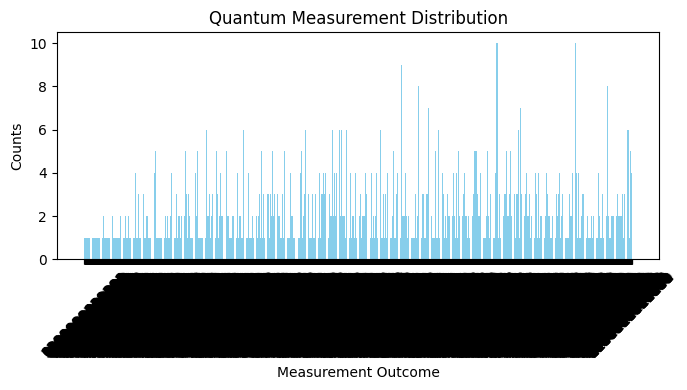

[I 2025-02-27 21:28:05,109] A new study created in memory with name: no-name-2f1d2e32-ce51-4ed5-abc8-3f3bf9c89dcf
[I 2025-02-27 21:28:54,678] Trial 0 finished with value: 41.339198038346204 and parameters: {'num_qubits': 4, 'num_layers': 2, 'shots': 2048, 'regularization_strength': 0.1, 'learning_rate': 0.04445780723817689, 'max_iter': 18}. Best is trial 0 with value: 41.339198038346204.


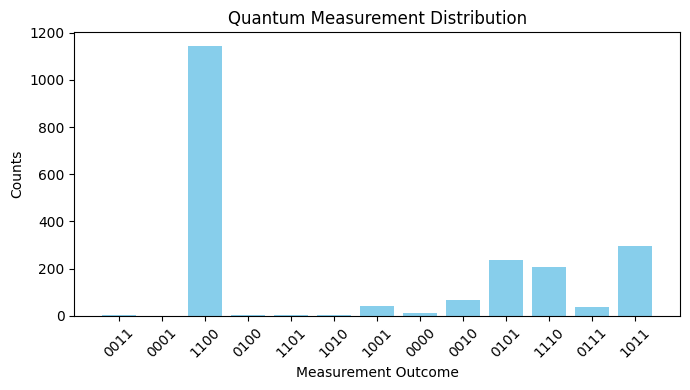


===== BEST HYPERPARAMS FROM OPTUNA =====
  num_qubits = 4
  num_layers = 2
  shots = 2048
  regularization_strength = 0.1
  learning_rate = 0.04445780723817689
  max_iter = 18
Best cost (Optuna): 41.3392
Final cost (re-run): 41.2457
Final entropy      : 2.0384
Connected to database quantummusic successfully.
Tables ensured.
Database connection closed.


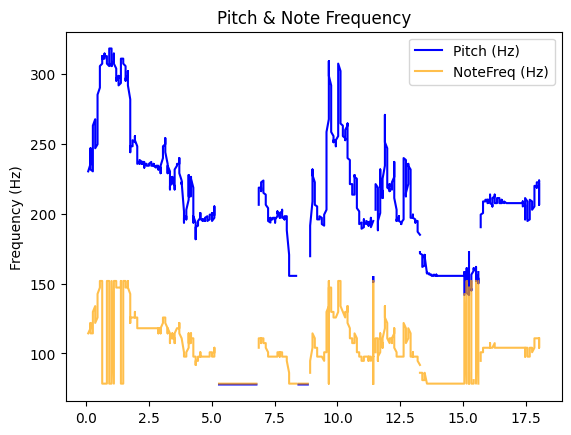

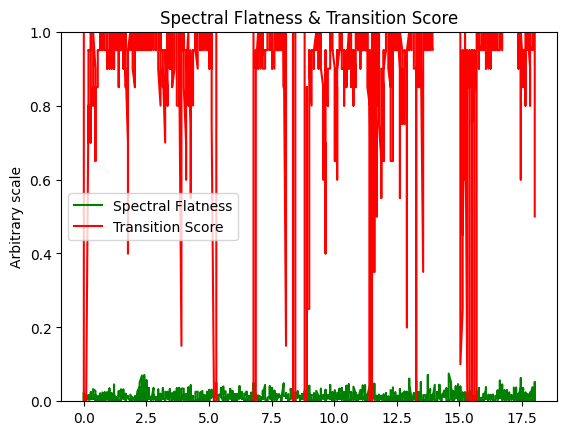

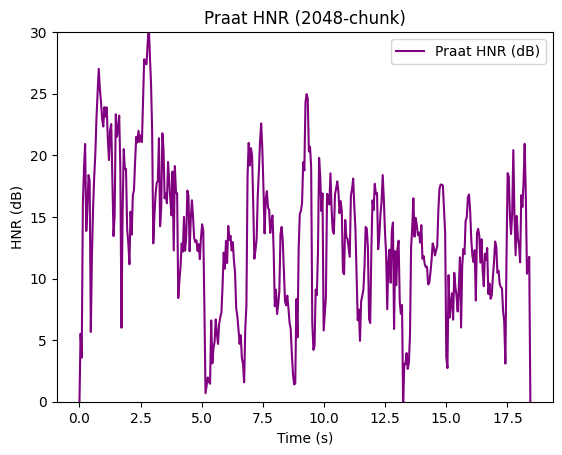

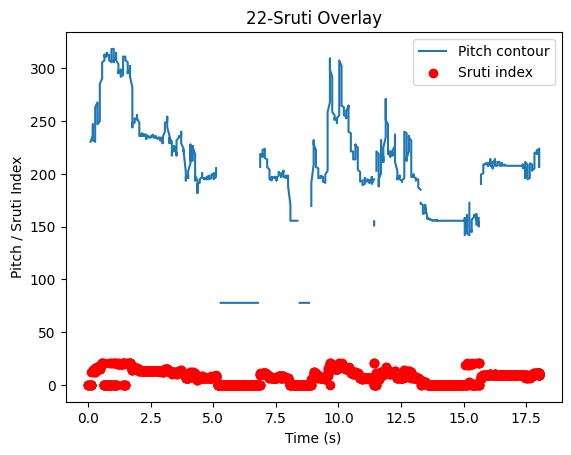

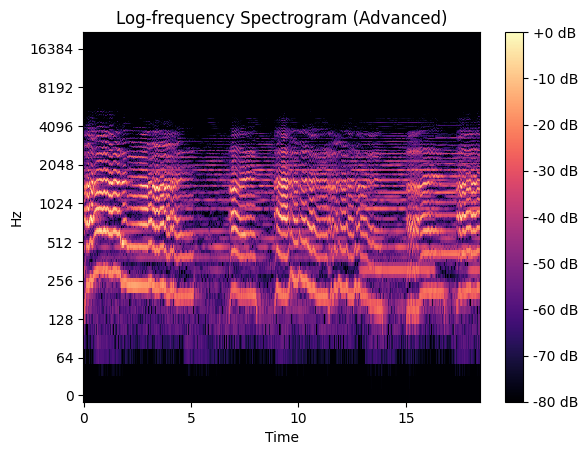

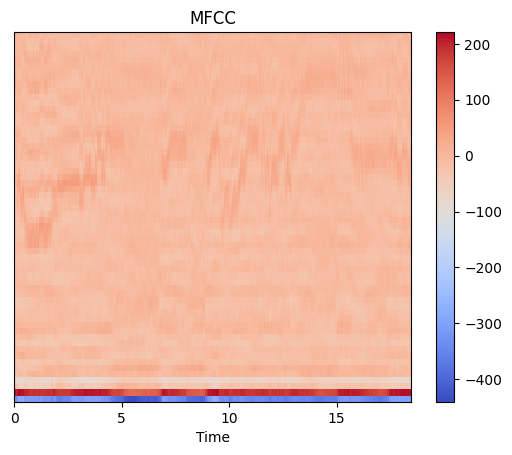

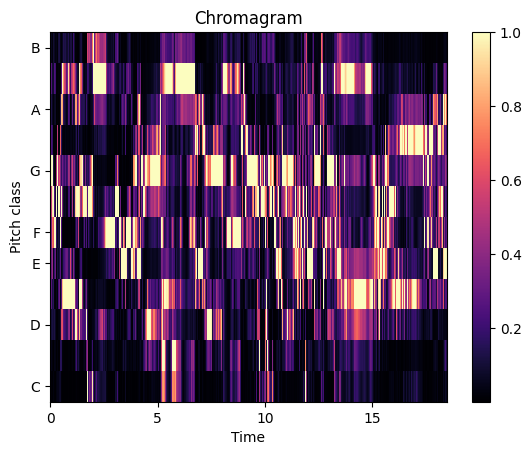

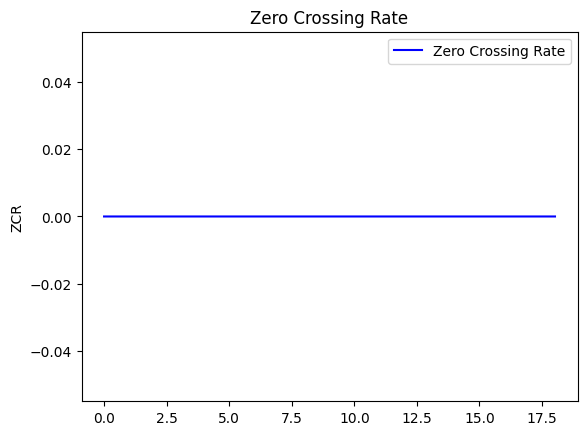

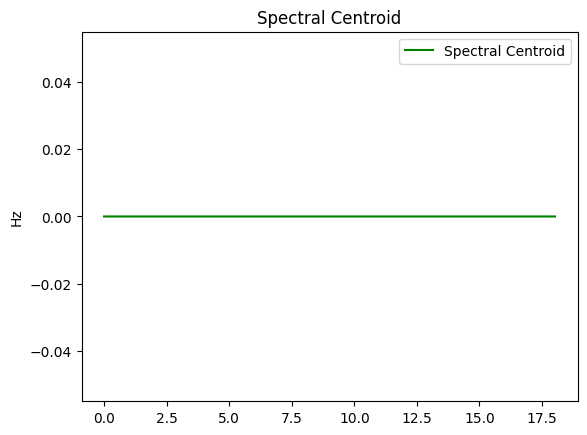

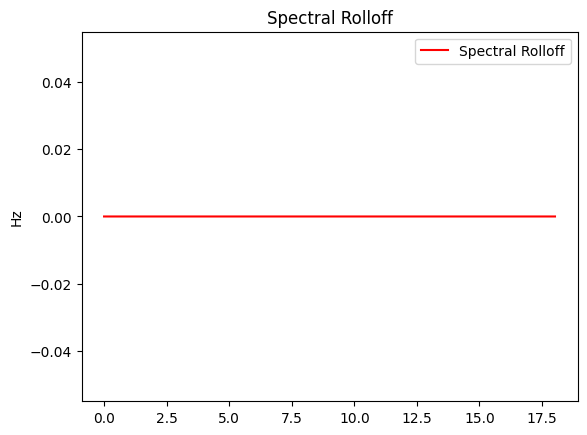

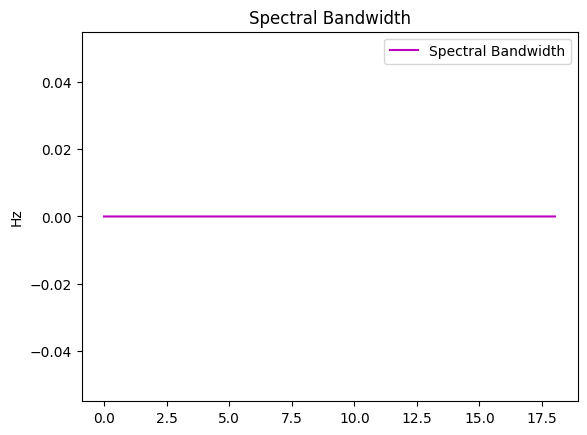

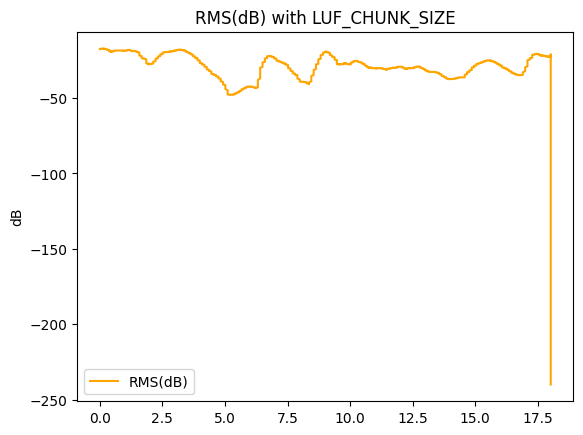

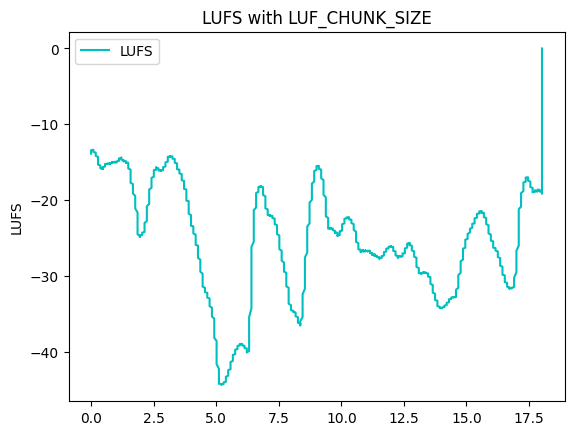

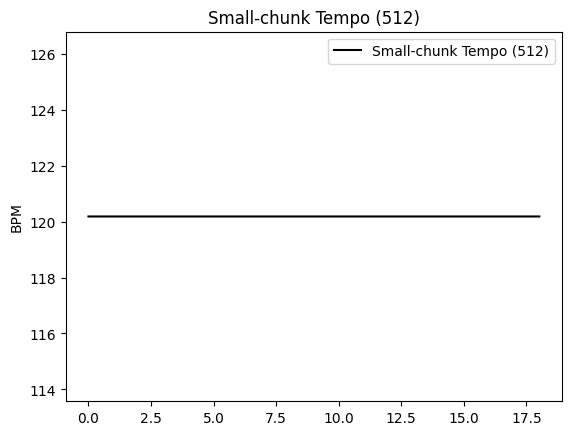

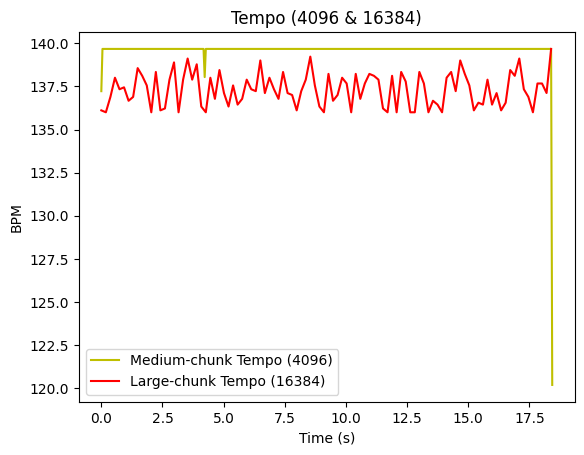

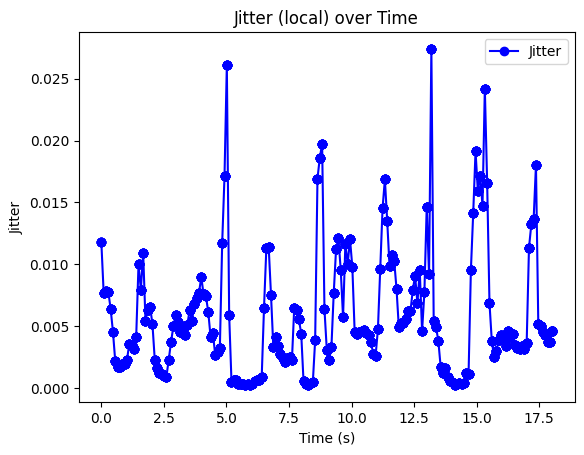

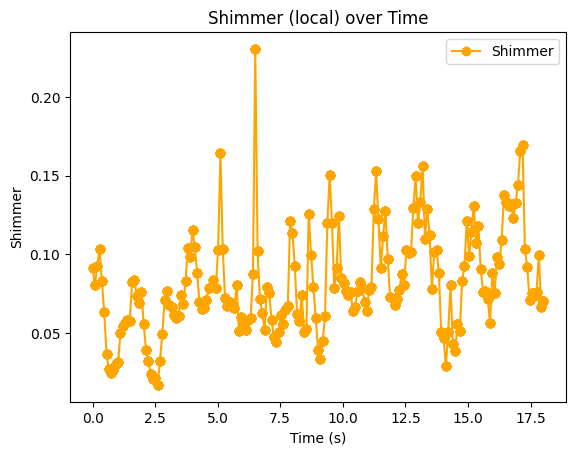

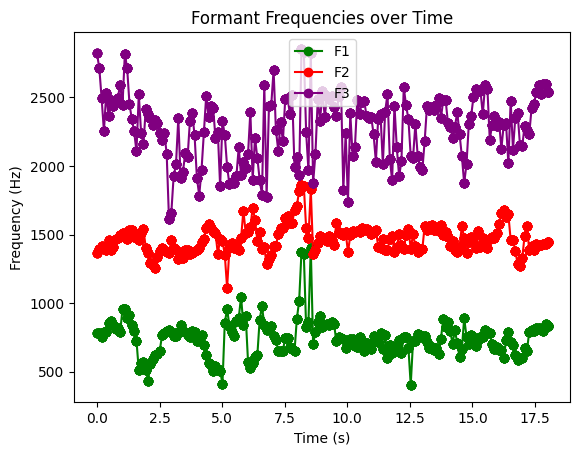

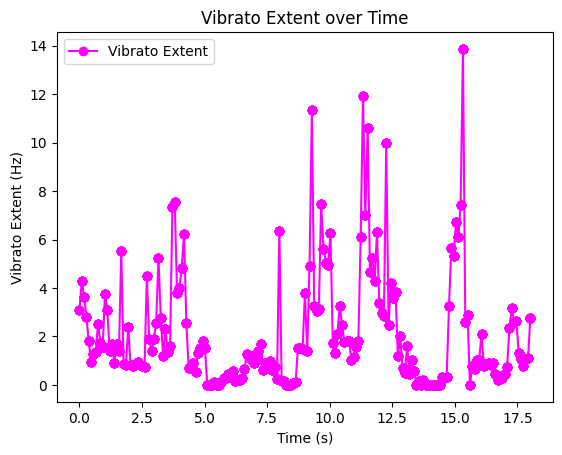

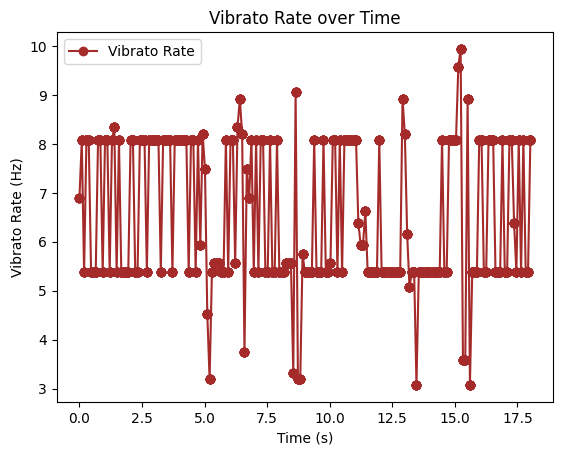

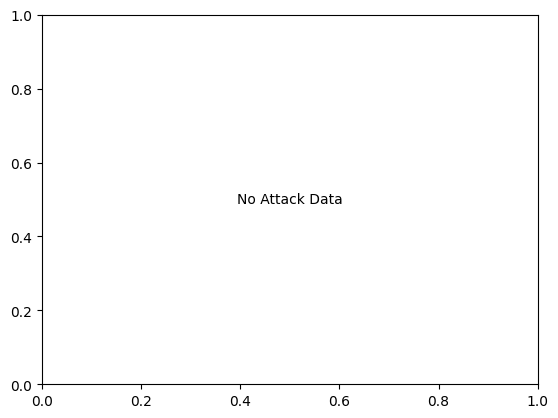

Processed & moved Basant5VenkatestKumar_0s_20s_Unknown.wav -> data/trainingdataoutput
All .wav files processed.


In [295]:
# === Cell 1: process_all_files function, plus example usage call ===

import os
import shutil

def process_all_files(
    grade_single_file,
    training_dir="data/trainingdata",
    output_dir="data/trainingdataoutput",
):
    """
    Processes all .wav files in `training_dir` using the provided
    `grade_single_file_func(file_name)` function (which already inserts
    its results into the database), then moves the processed files to `output_dir`.
    """
    if not callable(grade_single_file):
        raise ValueError("grade_single_file_func must be a callable that accepts a filename.")

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    files = [f for f in os.listdir(training_dir) if f.endswith(".wav")]
    if not files:
        print(f"No new .wav files found in {training_dir}")
        return

    for file in files:
        file_path = os.path.join(training_dir, file)
        print(f"Processing {file}...")

        try:
            # This call is assumed to do the DB insertion internally:
            result = grade_single_file(file)

            # Move the file to output_dir after processing
            shutil.move(file_path, os.path.join(output_dir, file))
            print(f"Processed & moved {file} -> {output_dir}")

        except Exception as e:
            print(f"Error processing {file}: {e}")

    print("All .wav files processed.")


# usage:
if __name__ == "__main__":
    process_all_files(
        grade_single_file,
        training_dir="data/trainingdata",
        output_dir="data/trainingdataoutput"
    )

## 50 DATA PROCESSING

In [ ]:
# If not installed, you may need:
# !pip install pydub gspread oauth2client yt-dlp

import os
import time
import shutil
import subprocess
from pydub import AudioSegment

# Google Sheets
import gspread
from oauth2client.service_account import ServiceAccountCredentials

##################################################
# A) GOOGLE SHEET CONFIG & AUTH
##################################################

SERVICE_ACCOUNT_JSON = os.path.join("data", "quantummusic-8dbce27ed321.json")
SCOPE = [
    "https://www.googleapis.com/auth/spreadsheets",
    "https://www.googleapis.com/auth/drive"
]

creds = ServiceAccountCredentials.from_json_keyfile_name(SERVICE_ACCOUNT_JSON, scopes=SCOPE)
gc = gspread.authorize(creds)

SPREADSHEET_URL = "https://docs.google.com/spreadsheets/d/1oD1Oyp5inbcog9eUQTl8xnmYi6y-ZMln8Iaxz9xHEtY/edit#gid=780967666"
workbook = gc.open_by_url(SPREADSHEET_URL)

metadata_sheet       = workbook.worksheet("metadata")
tempogroups_sheet    = workbook.worksheet("tempogroups")
outputchunks_sheet   = workbook.worksheet("outputchunks")

##################################################
# B) HELPER: Find column index by name
##################################################
def find_col_index(col_name, header_list):
    """
    Locate column index (0-based) for 'col_name' in 'header_list' (case-insensitive).
    Returns None if not found.
    """
    col_name_lower = col_name.lower()
    for i, h in enumerate(header_list):
        if h.lower() == col_name_lower:
            return i
    return None


##################################################
# C) FIRST PASS: Download from YouTube if Processed = -1
##################################################
def first_pass_downloads():
    print("=== FIRST PASS: Downloading from YouTube for rows with Processed = -1 ===")

    # 1) Read entire "metadata" sheet
    all_values = metadata_sheet.get_all_values()
    if not all_values:
        print("No data in 'metadata' sheet. Nothing to do.")
        return  # no data

    header = all_values[0]
    data_rows = all_values[1:]

    # Identify relevant columns
    tracksource_idx = find_col_index("TrackSource", header)
    processed_idx   = find_col_index("Processed", header)
    filename_idx    = find_col_index("FileName", header)

    if tracksource_idx is None or processed_idx is None or filename_idx is None:
        raise ValueError("Could not find 'TrackSource', 'FileName', or 'Processed' columns in metadata header.")

    # 2) Collect rows where Processed = -1
    rows_to_download = []
    for i, row in enumerate(data_rows):
        sheet_row = i + 2  # 1-based offset for header
        if len(row) <= max(tracksource_idx, processed_idx, filename_idx):
            continue
        
        tracksource_val = row[tracksource_idx].strip()
        processed_val   = row[processed_idx].strip()
        file_name_in_sheet = row[filename_idx].strip()

        if processed_val == "-1" and tracksource_val:
            rows_to_download.append((sheet_row, tracksource_val, file_name_in_sheet))

    print(f"Found {len(rows_to_download)} YouTube URLs to download (Processed=-1).")

    download_folder = os.path.join("data", "rawunprocessed")
    os.makedirs(download_folder, exist_ok=True)

    # We'll store final statuses in a dict: row -> new_processed_val
    status_updates = {}

    for (sheet_row_number, youtube_url, file_name_in_sheet) in rows_to_download:
        print(f"Downloading row {sheet_row_number}, URL: {youtube_url}")
        
        # Ensure the final filename ends with .mp3
        # (If user already put .mp3, we won't double-append it.)
        if not file_name_in_sheet.lower().endswith(".mp3"):
            file_name_in_sheet += ".mp3"

        # Full path for output
        output_path = os.path.join(download_folder, file_name_in_sheet)

        cmd = [
            "yt-dlp",
            "-f", "bestaudio/best",
            "--extract-audio",
            "--audio-format", "mp3",
            "--audio-quality", "320K",
            "-o", output_path,
            youtube_url
        ]
        try:
            result = subprocess.run(cmd, capture_output=True, text=True)
            if result.returncode == 0:
                print("Download succeeded.")
                # Mark processed=0 so it can be chunked in second pass
                status_updates[sheet_row_number] = "11"
            else:
                print(f"Download error (returncode={result.returncode}): {result.stderr}")
                # Mark processed=-2 to indicate error
                status_updates[sheet_row_number] = "-2"
        except Exception as e:
            print(f"Exception in download: {e}")
            status_updates[sheet_row_number] = "-2"
        
        # Wait 10 seconds before next
        time.sleep(10)
    
    # 3) Batch update sheet for these rows
    if status_updates:
        col_number = processed_idx + 1  # 1-based for Sheets
        cell_updates = []
        for row_idx, new_val in status_updates.items():
            cell_updates.append({
                'range': f"R{row_idx}C{col_number}",
                'values': [[new_val]]
            })
        metadata_sheet.batch_update(cell_updates)
        print(f"Updated {len(cell_updates)} rows in 'metadata' after YouTube downloads.")


##################################################
# D) SECOND PASS: Chunk if Processed = 0
##################################################

def second_pass_chunking():
    print("=== SECOND PASS: Chunking files for rows with Processed = 0 ===")

    # 1) Re-read "metadata" to see the updated states
    metadata_all_values = metadata_sheet.get_all_values()
    if not metadata_all_values:
        print("No data in 'metadata' sheet.")
        return

    metadata_header = metadata_all_values[0]
    metadata_data_rows = metadata_all_values[1:] if len(metadata_all_values) > 1 else []

    file_col_idx = find_col_index("FileName", metadata_header)
    processed_col_idx = find_col_index("Processed", metadata_header)
    if file_col_idx is None or processed_col_idx is None:
        raise ValueError("Could not find 'FileName' or 'Processed' column in metadata header.")

    # Build list of (sheet_row_number, file_name_in_sheet) where processed=0
    unprocessed_entries = []
    for i, row in enumerate(metadata_data_rows):
        sheet_row_number = i + 2
        if len(row) <= max(file_col_idx, processed_col_idx):
            continue
        
        file_name_in_sheet = row[file_col_idx].strip()
        processed_val = row[processed_col_idx].strip()
        if processed_val == "0":
            unprocessed_entries.append((sheet_row_number, file_name_in_sheet))

    print(f"Found {len(unprocessed_entries)} files marked Processed=0 in metadata for chunking.")

    # 2) Build set of base names for these
    unprocessed_base_names = set()
    for _, file_name_in_sheet in unprocessed_entries:
        base_name = os.path.splitext(file_name_in_sheet)[0]
        unprocessed_base_names.add(base_name)

    # 3) Read tempogroups, store only for these base names
    tempogroups_all = tempogroups_sheet.get_all_records()
    tempo_dict = {}
    for row in tempogroups_all:
        fname = row.get("FileName", "").strip()
        base_ = os.path.splitext(fname)[0]
        if base_ not in unprocessed_base_names:
            continue
        start_dur = float(row.get("StartDuration", 0))
        end_dur   = float(row.get("EndDuration", 0))
        tempo     = str(row.get("Tempo", "Unknown"))
        if base_ not in tempo_dict:
            tempo_dict[base_] = []
        tempo_dict[base_].append({
            "start": start_dur,
            "end": end_dur,
            "tempo": tempo
        })

    # Folders & settings
    data_folder      = "data"
    input_folder     = os.path.join(data_folder, "rawunprocessed")
    output_folder    = os.path.join(data_folder, "trainingdata")
    processed_folder = os.path.join(data_folder, "rawprocessed")
    error_folder     = os.path.join(data_folder, "rawerror")

    target_sample_rate = 44100
    chunk_duration_sec = 20

    os.makedirs(output_folder, exist_ok=True)
    os.makedirs(processed_folder, exist_ok=True)
    os.makedirs(error_folder, exist_ok=True)

    # Helper functions
    def process_audio_file(file_path, is_mp3):
        """Load MP3 or WAV, convert to target SR mono."""
        if is_mp3:
            audio = AudioSegment.from_file(file_path, format="mp3")
        else:
            audio = AudioSegment.from_file(file_path, format="wav")
        audio = audio.set_frame_rate(target_sample_rate).set_channels(1)
        duration_sec = len(audio) / 1000.0
        return audio, duration_sec

    def chunk_audio_by_tempo(audio, base_name, file_name_sheet, tempo_info):
        rows_for_sheet = []
        for tinfo in tempo_info:
            tempo_start = float(tinfo["start"])
            tempo_end   = float(tinfo["end"])
            tempo_label = tinfo["tempo"]
            chunk_start_sec = tempo_start

            while chunk_start_sec < tempo_end:
                chunk_end_sec = chunk_start_sec + chunk_duration_sec
                if chunk_end_sec > tempo_end:
                    actual_length_sec = tempo_end - chunk_start_sec
                    padded_sec = chunk_duration_sec - actual_length_sec
                    start_ms = int(chunk_start_sec * 1000)
                    end_ms   = int(tempo_end * 1000)
                    audio_chunk = audio[start_ms:end_ms]
                    if padded_sec > 0:
                        silence_chunk = AudioSegment.silent(duration=int(padded_sec * 1000))
                        audio_chunk = audio_chunk + silence_chunk

                    chunk_filename = f"{base_name}_{int(chunk_start_sec)}s_{int(chunk_end_sec)}s_{tempo_label}_padded.wav"
                    padded_flag = "Y"
                else:
                    start_ms = int(chunk_start_sec * 1000)
                    end_ms   = int(chunk_end_sec * 1000)
                    audio_chunk = audio[start_ms:end_ms]
                    chunk_filename = f"{base_name}_{int(chunk_start_sec)}s_{int(chunk_end_sec)}s_{tempo_label}.wav"
                    padded_flag = "N"

                out_path = os.path.join(output_folder, chunk_filename)
                audio_chunk.export(out_path, format="wav")

                rows_for_sheet.append({
                    "FileName": file_name_sheet,
                    "ChunkFileName": chunk_filename,
                    "Start Duration": f"{chunk_start_sec:.2f}",
                    "End Duration": f"{min(chunk_end_sec, tempo_end):.2f}",
                    "Tempo": tempo_label,
                    "Padded": padded_flag
                })

                chunk_start_sec += chunk_duration_sec

        return rows_for_sheet

    all_output_rows = []
    status_updates_for_chunk = {}

    # 4) Loop over entries with Processed=0
    for (sheet_row_number, file_name_in_sheet) in unprocessed_entries:
        local_path = os.path.join(input_folder, file_name_in_sheet)
        lower_name = file_name_in_sheet.lower()

        if not os.path.exists(local_path):
            print(f"Error: File '{file_name_in_sheet}' not found in rawunprocessed. Skipping.")
            # Mark processed = -3
            status_updates_for_chunk[sheet_row_number] = "-3"
            continue

        if not (lower_name.endswith(".mp3") or lower_name.endswith(".wav")):
            print(f"Error: File '{file_name_in_sheet}' is not .mp3 or .wav. Skipping.")
            status_updates_for_chunk[sheet_row_number] = "-3"
            continue

        try:
            is_mp3 = lower_name.endswith(".mp3")
            audio, total_sec = process_audio_file(local_path, is_mp3)
            base_name = os.path.splitext(file_name_in_sheet)[0]
            if base_name in tempo_dict and tempo_dict[base_name]:
                tempo_info = tempo_dict[base_name]
            else:
                tempo_info = [{
                    "start": 0,
                    "end": total_sec,
                    "tempo": "Unknown"
                }]

            chunk_rows = chunk_audio_by_tempo(audio, base_name, file_name_in_sheet, tempo_info)
            all_output_rows.extend(chunk_rows)

            # Move original file to processed
            shutil.move(local_path, os.path.join(processed_folder, file_name_in_sheet))
            status_updates_for_chunk[sheet_row_number] = "1"  # success

        except Exception as e:
            print(f"Error processing {file_name_in_sheet}: {e}")
            if os.path.exists(local_path):
                shutil.move(local_path, os.path.join(error_folder, file_name_in_sheet))
            status_updates_for_chunk[sheet_row_number] = "-3"

    # 5) Single append to 'outputchunks'
    if all_output_rows:
        rows_to_append = []
        for row in all_output_rows:
            rows_to_append.append([
                row["FileName"],
                row["ChunkFileName"],
                row["Start Duration"],
                row["End Duration"],
                row["Tempo"],
                row["Padded"]
            ])
        outputchunks_sheet.append_rows(rows_to_append, value_input_option='RAW')
        print(f"Appended {len(rows_to_append)} rows to 'outputchunks' in second pass.")

    # 6) Batch update "Processed" for chunk results
    if status_updates_for_chunk:
        col_number = processed_col_idx + 1
        cell_updates = []
        for row_idx, new_val in status_updates_for_chunk.items():
            cell_updates.append({
                'range': f"R{row_idx}C{col_number}",
                'values': [[new_val]]
            })
        metadata_sheet.batch_update(cell_updates)
        print(f"Updated {len(cell_updates)} rows in 'metadata' after chunking pass.")


##################################################
# E) SINGLE CELL MAIN LOGIC
##################################################

def run_all_passes():
    """
    1) First pass: download from YouTube where Processed=-1, set them to 0 or -2
    2) Second pass: chunk audio where Processed=0, set them to 1 or -3
    """
    first_pass_downloads()
    second_pass_chunking()
    print("All passes completed.")

# Finally, just call run_all_passes():
if __name__ == "__main__":
    run_all_passes()

## Machine Learning Models

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchaudio.transforms import MelSpectrogram
import librosa
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import random
from transformers import ASTModel

# Settings
OUTPUT_DIR = "data/trainingdataoutput"
BATCH_SIZE = 8
EPOCHS = 10
LEARNING_RATE_MAIN = 5e-5
LEARNING_RATE_HEAD = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

###########################################################################
# Minimal DB to fetch analysis_data
###########################################################################
class QuantumMusicDBFetchOnly:
    """Minimal class to fetch analysis_data from the DB for ML."""
    def __init__(self, db_name="quantummusic", host="localhost", user="postgres", password="postgres"):
        import psycopg2
        self.psycopg2 = psycopg2
        self.db_name = db_name
        self.host = host
        self.user = user
        self.password = password
        self.conn = None
        self.connect()

    def connect(self):
        try:
            self.conn = self.psycopg2.connect(
                dbname=self.db_name,
                host=self.host,
                user=self.user,
                password=self.password
            )
            print(f"Connected to database {self.db_name}. (fetch-only)")
        except Exception as e:
            print(f"Error connecting to database: {e}")

    def close(self):
        if self.conn:
            self.conn.close()
            print("Database connection closed.")

    def fetch_all_analysis_data(self):
        with self.conn.cursor() as cur:
            cur.execute("SELECT analysis_data FROM audio_analysis")
            rows = cur.fetchall()
        return rows


###########################################################################
# Convert quantum measurement counts -> probability vector
###########################################################################
def convert_counts_to_probs_feature(counts_dict, max_bits=5):
    total_counts = sum(counts_dict.values())
    if total_counts == 0:
        return np.zeros(2**max_bits, dtype=np.float32)

    feature_vec = np.zeros(2**max_bits, dtype=np.float32)
    for bitstring, c in counts_dict.items():
        if len(bitstring) > max_bits:
            truncated = bitstring[-max_bits:]
        else:
            truncated = bitstring.rjust(max_bits, '0')
        idx = int(truncated, 2)
        feature_vec[idx] += c / total_counts
    return feature_vec


###########################################################################
# Fetch Training Data
###########################################################################
def fetch_training_data():
    db = QuantumMusicDBFetchOnly()
    rows = db.fetch_all_analysis_data()
    db.close()
    if not rows:
        print("No data found in DB.")
        return None, None, None, None

    audio_feats, scalar_feats, quantum_feats, labels = [], [], [], []
    # We'll also store distribution-based quantum features
    dist_feats = []

    for (analysis_data,) in rows:
        # file path
        fpath = os.path.join(OUTPUT_DIR, analysis_data["file_name"])
        if not os.path.exists(fpath):
            continue

        # load audio => mel spec
        y, sr = librosa.load(fpath, sr=None)
        meltr = MelSpectrogram(n_mels=128)
        mel = meltr(torch.tensor(y).float()).numpy()  # shape(128, frames)
        mel = np.expand_dims(mel, axis=0)             # shape(1, 128, frames)
        audio_feats.append(mel)

        # gather scalar features
        res = analysis_data.get("results", {})
        avg_dev = res.get("average_dev_cents", 0.0)
        std_dev = res.get("std_dev_cents", 0.0)
        avg_hnr = res.get("avg_praat_hnr", 0.0)
        avg_tnr = res.get("avg_tnr", 0.0)
        # placeholder
        scal = [avg_dev, std_dev, avg_hnr, avg_tnr, 0.0, 0.0]
        scalar_feats.append(scal)

        # gather quantum angles
        quantum_dict = analysis_data.get("quantum_analysis", {})
        angles = quantum_dict.get("scaled_angles", [])
        max_len = 10
        angle_arr = np.zeros(max_len, dtype=np.float32)
        for i in range(min(max_len, len(angles))):
            angle_arr[i] = angles[i]

        # gather quantum distribution
        qv = analysis_data.get("quantum_analysis_variational", {})
        counts_d = qv.get("counts", {})
        dist_vec = convert_counts_to_probs_feature(counts_d, max_bits=5)  # shape(32,)

        quantum_feats.append(angle_arr)
        dist_feats.append(dist_vec)

        # label
        lab = random.randint(0, 1)
        labels.append(lab)

    # combine quantum data
    final_q_feats = []
    for i in range(len(quantum_feats)):
        concat_ = np.concatenate([quantum_feats[i], dist_feats[i]], axis=0)
        final_q_feats.append(concat_)
    final_q_feats = np.array(final_q_feats, dtype=np.float32)

    return (
        np.array(audio_feats, dtype=np.float32),
        np.array(scalar_feats, dtype=np.float32),
        final_q_feats,
        np.array(labels, dtype=np.int64),
    )


###########################################################################
# PyTorch Dataset
###########################################################################
class AudioDataset(Dataset):
    def __init__(self, aud, scal, quan, labs):
        self.aud = torch.tensor(aud, dtype=torch.float32)
        self.scal = torch.tensor(scal, dtype=torch.float32)
        self.quan = torch.tensor(quan, dtype=torch.float32)
        self.labs = torch.tensor(labs, dtype=torch.long)

    def __len__(self):
        return len(self.labs)

    def __getitem__(self, idx):
        return (
            self.aud[idx],
            self.scal[idx],
            self.quan[idx],
            self.labs[idx]
        )


###########################################################################
# Hybrid AST Model
###########################################################################
class HybridASTModel(nn.Module):
    def __init__(self, scalar_dim, quantum_dim, output_dim=2, freeze_ast=True):
        super().__init__()
        self.ast = ASTModel.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")

        if freeze_ast:
            for p in self.ast.parameters():
                p.requires_grad = False

        self.scalar_fc = nn.Sequential(
            nn.Linear(scalar_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
        )
        self.quantum_fc = nn.Sequential(
            nn.Linear(quantum_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
        )

        # pooler_output => 768 dims
        self.final_fc = nn.Linear(768 + 64 + 64, output_dim)

    def forward(self, audio_input, scalar_input, quantum_input):
        ast_out = self.ast(audio_input).pooler_output
        s = self.scalar_fc(scalar_input)
        q = self.quantum_fc(quantum_input)
        fused = torch.cat([ast_out, s, q], dim=1)
        return self.final_fc(fused)


###########################################################################
# Training Pipeline
###########################################################################
def train_model():
    data = fetch_training_data()
    if data[0] is None:
        print("No data to train.")
        return None
    audio_features, scalar_features, quantum_features, labels = data

    from sklearn.preprocessing import StandardScaler
    sc1 = StandardScaler()
    scalar_features = sc1.fit_transform(scalar_features)

    sc2 = StandardScaler()
    quantum_features = sc2.fit_transform(quantum_features)

    from sklearn.model_selection import train_test_split
    Xaud_tr, Xaud_te, Xs_tr, Xs_te, Xq_tr, Xq_te, y_tr, y_te = train_test_split(
        audio_features, scalar_features, quantum_features, labels,
        test_size=0.2, random_state=42
    )

    train_ds = AudioDataset(Xaud_tr, Xs_tr, Xq_tr, y_tr)
    test_ds  = AudioDataset(Xaud_te, Xs_te, Xq_te, y_te)

    train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    test_dl  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

    model = HybridASTModel(
        scalar_dim=scalar_features.shape[1],
        quantum_dim=quantum_features.shape[1],
        output_dim=2,
        freeze_ast=False
    ).to(DEVICE)

    # separate param groups
    ast_params, head_params = [], []
    for name, param in model.named_parameters():
        if "ast." in name:
            ast_params.append(param)
        else:
            head_params.append(param)

    optimizer = optim.Adam([
        {"params": ast_params,  "lr": LEARNING_RATE_MAIN},
        {"params": head_params, "lr": LEARNING_RATE_HEAD},
    ])
    crit = nn.CrossEntropyLoss()

    train_losses = []
    test_losses = []

    for epoch in range(EPOCHS):
        model.train()
        run_loss = 0
        for aud, sc, qu, lab in train_dl:
            aud = aud.to(DEVICE)
            sc  = sc.to(DEVICE)
            qu  = qu.to(DEVICE)
            lab = lab.to(DEVICE)
            optimizer.zero_grad()
            out = model(aud, sc, qu)
            loss = crit(out, lab)
            loss.backward()
            optimizer.step()
            run_loss += loss.item()
        avg_tr_loss = run_loss / len(train_dl)
        train_losses.append(avg_tr_loss)

        # test
        model.eval()
        run_loss_te = 0
        with torch.no_grad():
            for aud, sc, qu, lab in test_dl:
                aud, sc, qu = aud.to(DEVICE), sc.to(DEVICE), qu.to(DEVICE)
                lab = lab.to(DEVICE)
                out = model(aud, sc, qu)
                loss = crit(out, lab)
                run_loss_te += loss.item()
        avg_te_loss = run_loss_te / len(test_dl)
        test_losses.append(avg_te_loss)

        print(f"Epoch {epoch+1}/{EPOCHS}, train_loss={avg_tr_loss:.4f}, test_loss={avg_te_loss:.4f}")

    print("Training complete.")

    # Confusion matrix
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    all_preds, all_labels = [], []
    model.eval()
    with torch.no_grad():
        for aud, sc, qu, lab in test_dl:
            aud, sc, qu = aud.to(DEVICE), sc.to(DEVICE), qu.to(DEVICE)
            preds = model(aud, sc, qu).argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(lab.numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(cm, display_labels=[0,1])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

    # Plot training curves
    plt.figure()
    plt.plot(train_losses, label="Train Loss")
    plt.plot(test_losses, label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training Curves")
    plt.show()

    return model

# Example usage if you want to run it directly:
# if __name__ == "__main__":
#     trained_model = train_model()

## Attempting local llama models

In [ ]:
import ollama

response = ollama.chat(
    model='llama3.2-vision:90b',
    messages=[{
        'role': 'user',
        'content': 'What is in this image?',
        'images': ['IMG_3310.jpg']
    }]
)

print(response)